# Deep Learning for Neanderthal Introgression

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
In this notebook, I will demonstrate how we can use Deep Learning for calling regions of Neanderthal introgression in modern humans. We mostly are going to use the methodology developed within the Natural Language Processing (NLP) framework and apply it to ancient and modern DNA considering the DNA sequence as a biological molecular text. However first we start with a simple Sentiment Analysis which is Gene vs. Non-Gene regions classification.

### Table of Contents:
* [Neanderthal DNA in Modern Human Genomes is Not Silent](#Neanderthal-DNA-in-Modern-Human-Genomes-is-Not-Silent)
* [Gene vs. Non-Gene Sequence Classification](#Gene-vs.-Non-Gene-Sequence-Classification)
* [Neanderthal Introgressed vs. Depleted Sequence Classification](#Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification)
    * [2D CNN for Neanderthal Introgressed vs. Depleted Sequence Classification](#2D-CNN-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification)
* [Intersect Neanderthal Segments with Genes](#Intersect-Neanderthal-Segments-with-Genes)
* [Ranking Genes by Their GC- and AT-Content](#Ranking-Genes-by-Their-GC--and-AT-Content)
* [Bag of Words for Neanderthal Introgressed vs. Depleted Sequence Classification](#Bag-of-Words-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification)
    * [CountVectorizer and Random Forest Classification](#CountVectorizer-and-Random-Forest-Classification)
    * [Detecting Genes Inherited from Neanderthals](#Detecting-Genes-Inherited-from-Neanderthals)
* [Multilayer Perceptron for Neanderthal Introgressed vs. Depleted Sequence Classification](#Multilayer-Perceptron-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification)
* [Multilayer Perceptron + Embedding Layer for Neanderthal Introgressed vs. Depleted Sequence Classification](#Multilayer-Perceptron-+-Embedding-Layer-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification)
* [CNN + Embedding Layer for Neanderthal Introgressed vs. Depleted Sequence Classification](#CNN-+-Embedding-Layer-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification)
* [LSTM + Embedding Layer for Neanderthal Introgressed vs. Depleted Sequence Classification](#LSTM-+-Embedding-Layer-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification)
* [Visualization of K-mer Word2Vec Embeddings](#Visualization-of-K-mer-Word2Vec-Embeddings)

### Neanderthal DNA in Modern Human Genomes is Not Silent  <a class="anchor" id="Neanderthal-DNA-in-Modern-Human-Genomes-is-Not-Silent"></a>

Since the revolutionary draft of Neanderthal genome https://science.sciencemag.org/content/328/5979/710 paper, a few studies had been carried out to systematically establish the maps of regions of Neanderthal introgression into modern humans. Those regions had were hypothesized to have multiple functional effects related to skin color, male fertility etc.

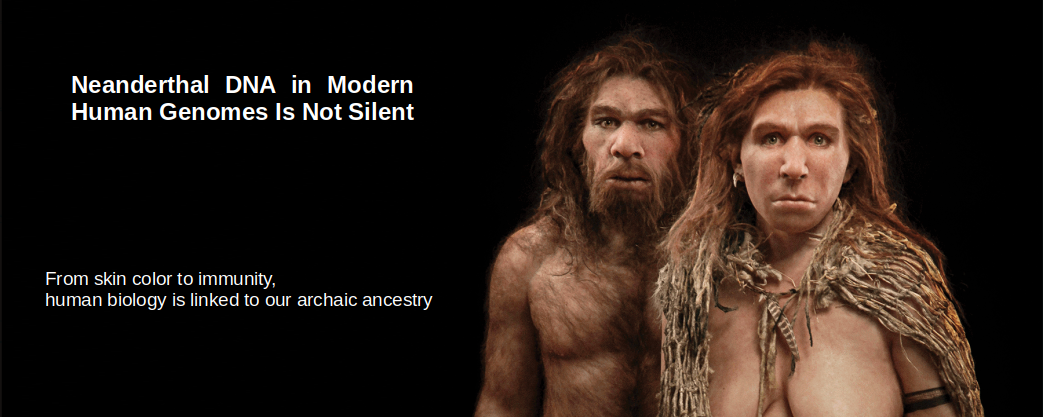

In [1]:
from IPython.display import Image
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/'
Image(Path + 'neanderthal_dna.png', width=2000)

The current dominating hypothesis of human evolution is that anatomically modern humans originated in Africa and migrated to Europe and Asia approximately ~ 50 000 years ago. In Aeurope and Asia they met Neanderthals and Denisovans, who the latter ones happened to come to Europe and Asia is not clear. We know that modern humans interbred with Neanderthals and Denisovans and had common offsprings. Modern humans of non-African ancestry have estimated fraction of 2%-5% of Neanderthal DNA. This became know in 2010 when the group of Svante Pääbo sequenced draft Neanderthal genome. 

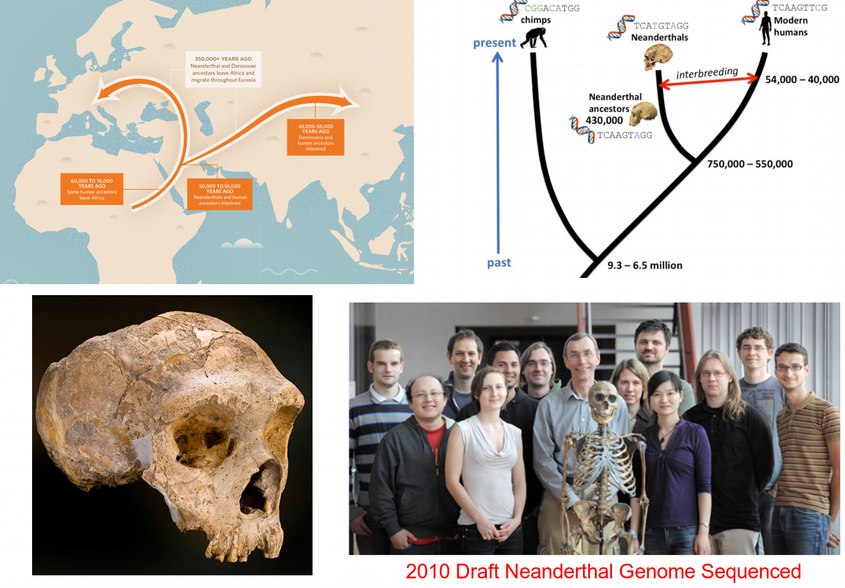

In [2]:
from IPython.display import Image
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/'
Image(Path + 'BriefHistory.png', width=2000)

Since the sequencing of the draft Neanderthal genome there were a few studies that systematically attempted to detect regions of Neanderthal introgression in modern human genomes using mostly individuals from the 1000G project:

* Sankararaman and Reich, Nature 2014 https://www.nature.com/articles/nature12961
* Vernot and Akey, Science 2014 https://science.sciencemag.org/content/343/6174/1017.abstract
* Vernot and Akey, Science 2016 https://science.sciencemag.org/content/352/6282/235
* Sankararaman and Reich, Current Biology 2016 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4864120/
* Skov and Durbin, Plos Genetics 2019 https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007641

All the methods of detecting regions of Neanderthal introgression are based on camparing a test modern genome of European or Asian ancestry with the high-coverage Neanderthal and Denisovan genomes one the one hand and with sub-Saharan African (Yoroba) genome on the other hand. The candidate regions should be as similar as possible to the Neanderthal / Denisovan DNA and as divergent as possible from the African genome. Usually a test statistic such as **Conditional Random Field (CRF)**, **S*** or **Hidden Markov Model (HMM)** are used in sliding window across the whole test genome. The disadvantage of those methods is their memoryless nature, i.e. no memory about nucleotide sequence is kept in the model. Here we will develop a Deep Learning based method for detecting regions of Neanderthal introgression in modern human genomes. The advantage of this approach is the long memory about the nucleotide sequence which possibly will bring new interesting candidate regions compared to the previous methods. 

### Gene vs. Non-Gene Sequence Classification  <a class="anchor" id="Gene-vs.-Non-Gene-Sequence-Classification"></a>

Before diving into Deep Learning modeles for calling regions of Neanderthal introgression in modern genomes, let us perform a simpler experiment and try to classify sequences that belong to either gene or intergenic regions. Since both Reich and Akey did their 1000G Neanderthal Introgression calls using hg19 version of human reference genome, we downloaded the hg19 version from http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/ and prepared it for fast sequence extraction with samtools faidx. Next, we are going to build an annotation file for protein-coding genes. We downloaded the RefSeq annotation file from http://genome.ucsc.edu/cgi-bin/hgTables for hg19 as a text-file and used "genePredToGtf" tool to build the refGene_hg19.gtf gtf-annotation file. The gtf-annotation looks messy, it includes both gene and exon annotation, we will select only gene annotation with the keyword "transcript" in the third column.

In [1]:
%%bash
cd /home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes
awk -v OFS='\t' '{if($3=="transcript") print $1,$4,$5,$10}' refGene_hg19.gtf | \
tr -d '\"' | sed 's/\;//g' | sort | uniq > gene_coords.txt
echo
head gene_coords.txt
echo
wc -l gene_coords.txt


chr10	100007443	100028007	LOXL4
chr10	100143322	100174978	PYROXD2
chr10	100154975	100155064	MIR1287
chr10	100175955	100206720	HPS1
chr10	100188903	100206720	HPS1
chr10	100191049	100191117	MIR4685
chr10	100206078	100213562	LOC101927278
chr10	100216834	100995632	HPSE2
chr10	100684256	100684325	MIR6507
chr10	10100685	10105465	LOC101928298

40996 gene_coords.txt


We can see that we have 40996 RefSeq genes which sounds a lot as we know that human genome has approximately ~20 000 protein coding genes. This descrepancy is explained by the non-uniqueness of the gene symbols in the last column. You can see that there are at least two HPS1 genes with different coordinates. This is a knwon fact, that is why they have Ensembl gene IDs which are unique, so that one gene symbol can correcspond to multiple Ensembl IDs.

In [2]:
%%bash
cd /home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes
cut -f4 gene_coords.txt | sort | uniq | wc -l

27565


If we check how many unique gene symbols we have, we get 27 565 genes which is closer to the number of protein coding genes in human genome. Further, if we exclude non-coding RNA and LOC-genes, we get almost the correct number of protein coding genes.

In [3]:
%%bash
cd /home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes
cut -f4 gene_coords.txt | sort | uniq | grep -v "LOC" | grep -v "MIR" | grep -v "LINC" | wc -l

22432


For now we are going to keep all the 40 996 genes assuming that they all have unique Ensembl ID even though they might be duplicates in sense of gene symbol. Now we are going to read the gene coordinates into Python and plot the distribution of gene lengths.

In [4]:
import pandas as pd
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/'
gene_coords = pd.read_csv(Path + 'gene_coords.txt', header=None, sep="\t")
gene_coords.sort_values(by = [0, 1, 2], inplace = True)
gene_coords.to_csv(Path + 'gene_coords.txt', index = False, header = False, sep = '\t')
gene_coords.head()

0      1      2          3
2596  chr1  11874  14409    DDX11L1
3030  chr1  14362  29370     WASH7P
4909  chr1  17369  17436  MIR6859-1
4910  chr1  17369  17436  MIR6859-2
4911  chr1  17369  17436  MIR6859-3

In [5]:
gene_coords.shape

(40996, 4)

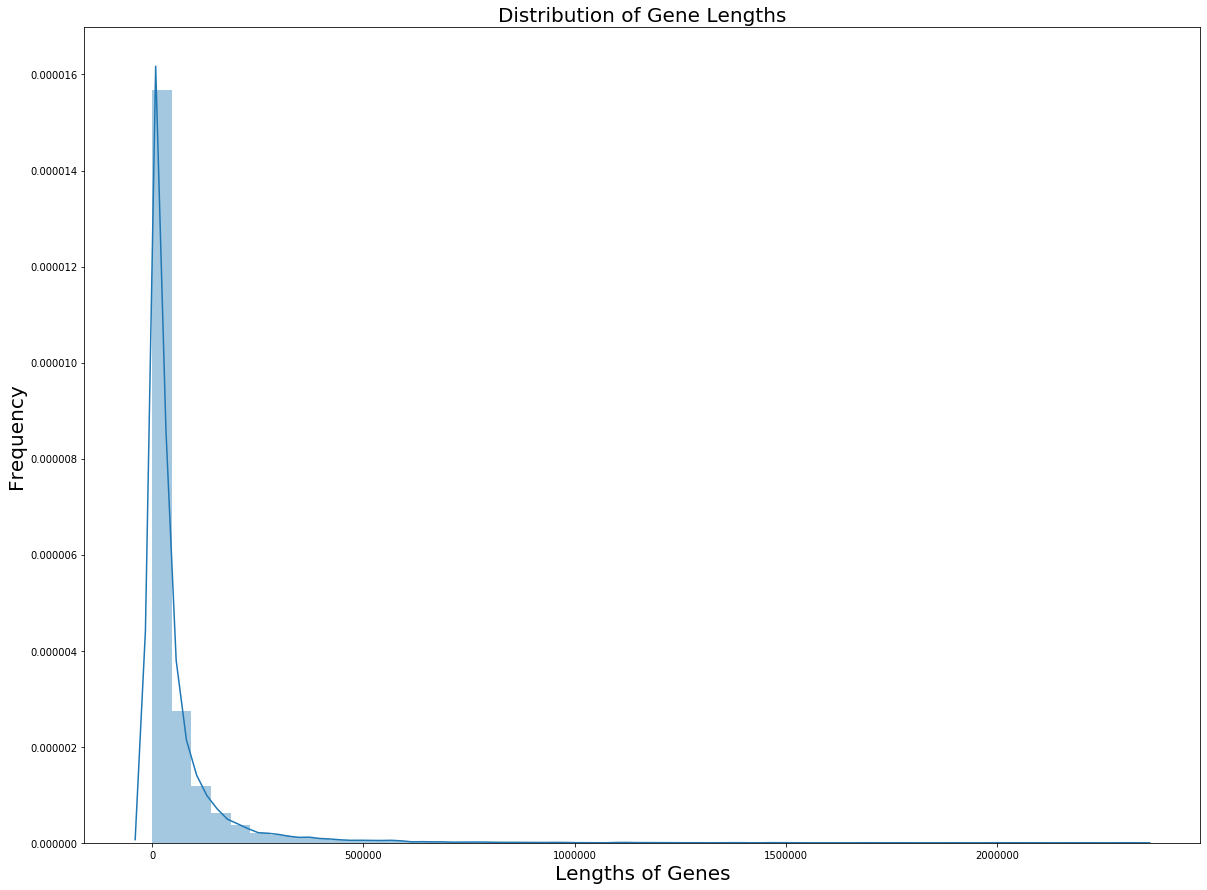

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
gene_lengths = gene_coords.iloc[:, 2]-gene_coords.iloc[:, 1]
sns.distplot(gene_lengths)
plt.title("Distribution of Gene Lengths", fontsize = 20)
plt.xlabel("Lengths of Genes", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

In [8]:
from scipy import stats
print(stats.describe(gene_lengths))

DescribeResult(nobs=40996, minmax=(19, 2320933), mean=52554.41474778027, variance=12473868428.7287, skewness=6.621632083720264, kurtosis=72.16643584088652)


We can see that the lengths of genes vary from minimal length 19 bp up to 2.3 Mbp with the mean length 52 kbp. These numbers are good to keep in mind for further downstream analysis. Now we are going to use the coordinates of the genes and the human reference genome hg19 fasta-file which we downloaded from http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/ in oder to extract the sequences of the genes using the **samtools**. One can of course do it in Python, but samtools is much faster, so we will use samtools here, but run it from Python.

In [9]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/')
with open('hg19_gene_regions.fa', 'a') as fp:
    for i in range(gene_coords.shape[0]):
        coord = str(str(gene_coords.iloc[i, 0]) + ':' 
                    + str(gene_coords.iloc[i, 1]) + '-' + str(gene_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)

Now we have a fasta-file with 40 996 nucleotide sequences of genes from hg19 human genome. Since we want to learn DNA motifs that discriminate between genes and non-genes, we need to build another fasta-file with 40 996 sequences of non-gene (intergenic) regions, each of them is of exactly the same length as the corresponding gene regions. To do this, we will need to know the lengths of each chromosome in order to randomly draw intergenic regions. When indexing the hg19 reference genome, samtools created a fai-file which contains the lengths of the cromosomes in the second column, we will read and sort it:

In [10]:
chr_sizes = pd.read_csv("hg19.fa.gz.fai", header = None, sep = "\t")
chr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)
#chr_sizes = chr_sizes[chr_sizes[0].isin(['chr' + str(i) for i in list(range(1,23)) + ['X', 'Y']])]
#sex_chr_sizes = chr_sizes[chr_sizes[0].str.match('|'.join(['chrX','chrY']))]
#chr_sizes = chr_sizes.drop(chr_sizes[chr_sizes[0] == 'chrX'].index, axis = 0)
#chr_sizes = chr_sizes.drop(chr_sizes[chr_sizes[0] == 'chrY'].index, axis = 0)
#chr_sizes['temp'] = chr_sizes[0].str.split('chr').str[1]
#chr_sizes['temp'] = chr_sizes['temp'].astype(int)
#chr_sizes = chr_sizes.sort_values('temp')
#chr_sizes = chr_sizes.drop('temp', axis = 1)
#chr_sizes = chr_sizes.append(sex_chr_sizes)
chr_sizes.head()

0          1
0  chr1  249250621
1  chr2  243199373
2  chr3  198022430
3  chr4  191154276
4  chr5  180915260

Now for each gene in the **gene_coords** DataFrame, we are going to randomly draw a region of the same length as the gene on the same chromosome and check whether this region overlaps with any other gene (not only with this one) on the same chromosome. If it does not, we will add this region to the **notgene_coords** DataFrame. If it does overlap, we repeat the random drawing of the region gain and again until we succeeed in selecting a truly intergenic region of the same length as the given gene.

In [11]:
import numpy as np
chr_list = []
start_list = []
end_list = []
gene_lengths = list(gene_coords.iloc[:, 2] - gene_coords.iloc[:, 1])
a = 0
for i in range(gene_coords.shape[0]):
    chr_df = gene_coords[gene_coords[0].isin([gene_coords.iloc[i,0]])]
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == gene_coords.iloc[i,0]].iloc[:,1]))
        reg_end = reg_start + gene_lengths[i]
        for j in range(chr_df.shape[0]):
            b1 = chr_df.iloc[j,1]
            b2 = chr_df.iloc[j,2]
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or \
            (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):
                overlap = True
                break
            else:
                overlap = False
    chr_list.append(gene_coords.iloc[i,0])
    start_list.append(reg_start)
    end_list.append(reg_end)
    a = a + 1
    if a%10000 == 0:
            print('Finished ' + str(a) + ' genes')
notgene_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
notgene_coords.to_csv("notgene_coords.txt", index = False, header = False, sep = "\t")
notgene_coords.head()

Finished 10000 genes
Finished 20000 genes
Finished 30000 genes
Finished 40000 genes


0          1          2
0  chr1  122614392  122616927
1  chr1   14589063   14604071
2  chr1  113873155  113873222
3  chr1  131976299  131976366
4  chr1  149163069  149163136

Let us now conform that the gene and intergenic regions indeed do not overlap. We will use **bedtools intersect** for this purpose. This command returns coordinate of interesects between two sets of genetic regions. If it does not return anything, it implies there are no intersects between the gene and intergenic regions, as we want to have it.

In [12]:
!bedtools intersect -a gene_coords.txt -b notgene_coords.txt | wc -l

0


We get zero intersects meaning that we indeed managed to build a set of intergenic regions that do not overlap with the gene regions. Now we are going to use the set of intergenic regions and extract the sequences of hg19 human reference genome corresponding to the intergenic coordinates. We wgain will use **samtools** for this purpose.

In [13]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/')
with open('hg19_notgene_regions.fa', 'a') as fp:
    for i in range(notgene_coords.shape[0]):
        coord = str(str(notgene_coords.iloc[i, 0]) + ':' 
                    + str(notgene_coords.iloc[i, 1]) + '-' + str(notgene_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)

Everything looks good at first glance, howeever taking a closer look we can see that we have quite a few sequences with N-nulceotides. This is a kind of missing data since N implies nucleotides that could not be identified by the sequencer. A fast way to see the presense of N-nucleoties is to grep them.

In [14]:
!grep -c N hg19_gene_regions.fa

118075


In [15]:
!grep -c N hg19_notgene_regions.fa

8991350


However we know that samtools splits sequences into multiple lines, so grep does not actually detect the number of N-containing entries but the number of N-containing lines. In order to be more precise, we can quickly count using Bio Python the numbers of entries in each fasta-file that contain at least one N-nucleotide.

In [16]:
from Bio import SeqIO

i = 0
for record in SeqIO.parse('hg19_gene_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        i = i + 1
print('Gene regions file contains ' + str(i) + ' entries with at least one N-nucleotide')

j = 0
for record in SeqIO.parse('hg19_notgene_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        j = j + 1
print('Intergenic regions file contains ' + str(j) + ' entries with at least one N-nucleotide')

Gene regions file contains 131 entries with at least one N-nucleotide
Intergenic regions file contains 7123 entries with at least one N-nucleotide


In case fractions of missing data are different between gene and intergenic regions, this might be treated as a signal by Convolutional Neural Networks (CNNs), and this is not what we are interested in. Therefore for simplicity we will remove all entries containing N-nucleotides in either gene or intergenic regions. For example, if a gene region contains at least one N-nucleotides, we will drop the region together with the corresponding intergenic region despite that one might not contain N-nucleotides. This is needed for a better correspondence between the gene and intergenic fasta-files.

In [17]:
from Bio import SeqIO

gene_file = 'hg19_gene_regions.fa'
notgene_file = 'hg19_notgene_regions.fa'
a = 0
i = 0
with open('hg19_gene_clean.fa', 'a') as gene_out, open('hg19_notgene_clean.fa', 'a') as notgene_out:
    for gene, notgene in zip(SeqIO.parse(gene_file, 'fasta'), SeqIO.parse(notgene_file, 'fasta')):
        upper_gene = gene.seq.upper()
        upper_notgene = notgene.seq.upper()
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_gene) and 'N' not in str(upper_notgene):
            gene.seq = upper_gene
            SeqIO.write(gene, gene_out, 'fasta')
            notgene.seq = upper_notgene
            SeqIO.write(notgene, notgene_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries
Finished 40000 entries
We have processed 40996 entries and written 33791 entries to two fasta-files


Thus we have removed approximately 7000 entries, but still have plenty of sequences left to run CNNs for gene vs. intergenic region classification. Now let us quickly check using grep whether we indeed are free of N-containing sequences. 

In [18]:
!grep -c N hg19_gene_clean.fa

0


In [19]:
!grep -c N hg19_notgene_clean.fa

0


Looks good! Now it is time to start building the input matrix of sequences to be fed int othe CNN. Since I have limited memory on my laptop, I will not read all the sequences into memory but extract first **cut = 500** nucleotides from each sequence. The gene and intergenic sequences of length less than **cut = 500** nucleotides will be ignored and not included into the CNN input matrix. We also have to make sure that all 4 nucleotides are present at each sequence, i.e. we will omit e.g. AT or CG repeat sequences.

In [1]:
import os
from Bio import SeqIO

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/')

gene_file = 'hg19_gene_clean.fa'
notgene_file = 'hg19_notgene_clean.fa'

a = 0
gene_seqs = []
notgene_seqs = []
for gene, notgene in zip(SeqIO.parse(gene_file, 'fasta'), SeqIO.parse(notgene_file, 'fasta')):
    cut = 500
    if len(str(gene.seq)) < cut or len(str(notgene.seq)) < cut:
        continue
    s_gene = str(gene.seq)[0:cut]
    s_notgene = str(notgene.seq)[0:cut]
    if s_gene.count('A')>0 and s_gene.count('C')>0 and s_gene.count('G')>0 and s_gene.count('T')>0 and \
    s_notgene.count('A')>0 and s_notgene.count('C')>0 and s_notgene.count('G')>0 and s_notgene.count('T')>0:
        gene_seqs.append(s_gene)
        notgene_seqs.append(s_notgene)
    a = a + 1
    if a%10000 == 0:
        print('Finished ' + str(a) + ' entries')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries


Next, we will concatenate the gene and intergenic sequences into a data set. Checking the length of this large list of sequences, we can see that we have a fair number of statistical observations to run Convolutional Neural Networks (CNNs).

In [2]:
sequences = gene_seqs + notgene_seqs
len(sequences)

62318

Here we prepare a list of sequence labels to be used in the CNN. We denote gene sequences as 1 and intergenic regions as 0. The length of this list of labels is of course equal to the length of the list of sequences above.

In [3]:
import numpy as np
labels = list(np.ones(len(gene_seqs))) + list(np.zeros(len(notgene_seqs)))
len(labels)

62318

Now we need to one-hot-encode both sequences and lables for a correct input to CNN. We will use scikitlearn classes **LabelEncoder** and **OneHotEncoder**. The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3. The OneHotEncoder converts an array of integers to a sparse matrix where each row corresponds to one possible value of each feature, i.e. only 01 and 1 are present in the matrix.

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
#print(input_features.shape)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 TCCTGCACAG ... GGGTGGTTGG
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]]


In [5]:
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


Next is the standard step of splitting the data set into training and test sub-sets. The latter will be used for the final evaluation of the model. Please note that the one-hot-encoded data set of sequences is  three dimensional array analagous to how images are encoded for image recognition problems. First number in the array is the amount of statistical observations (sequences), second is the dimensionality of the data (length of the sequences) equal to the **cut** variable, and the third number denotes the numberof channels i.e. nucleotides (4 possible nucleotides, i.e. A, C, G and T). Overall the data looks like a 1D image, a proper 2D image would be represented by a four-dimensional array, where second and third dimensions would correspond to the height and width (in pixels) of the 2D images, the fourth dimension would be the number of color channels, e.g. R, G and B.

In [6]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size = 0.2, random_state = 42)

In [7]:
train_features.shape

(49854, 500, 4)

In [8]:
train_labels.shape

(49854, 2)

In [9]:
test_features.shape

(12464, 500, 4)

In [10]:
test_labels.shape

(12464, 2)

Finally it is time to contract a simple shallow Convolutional Neural Network (CNN) and start training it. We construct quite a shallow one-block VGG-like CNN, i.e. two consequent 1D convolutional layers followed by a 1D max-pooling layer. Light dropout regularization is used to prevent overfitting.

In [14]:
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation
from keras.models import Sequential
from keras.regularizers import l1

import warnings
warnings.filterwarnings('ignore')

model = Sequential()

model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform', 
                 input_shape = (train_features.shape[1], 4)))
model.add(Activation("relu"))
model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(8, kernel_initializer = 'he_uniform'))
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation = 'softmax'))

epochs = 100
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 500, 16)           336       
_________________________________________________________________
activation_7 (Activation)    (None, 500, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 500, 16)           1296      
_________________________________________________________________
activation_8 (Activation)    (None, 500, 16)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 16)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 250, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4000)              0         
__________

In [15]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(train_features, train_labels, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True)

Train on 39883 samples, validate on 9971 samples
Epoch 1/100
39883/39883 [==============================] - 16s 396us/step - loss: 0.5448 - binary_accuracy: 0.7218 - val_loss: 0.4346 - val_binary_accuracy: 0.8115
Epoch 2/100
39883/39883 [==============================] - 17s 427us/step - loss: 0.4601 - binary_accuracy: 0.7944 - val_loss: 0.4137 - val_binary_accuracy: 0.8270
Epoch 3/100
39883/39883 [==============================] - 17s 429us/step - loss: 0.4436 - binary_accuracy: 0.8078 - val_loss: 0.3960 - val_binary_accuracy: 0.8383
Epoch 4/100
39883/39883 [==============================] - 17s 429us/step - loss: 0.4355 - binary_accuracy: 0.8152 - val_loss: 0.3973 - val_binary_accuracy: 0.8366
Epoch 5/100
39883/39883 [==============================] - 17s 427us/step - loss: 0.4220 - binary_accuracy: 0.8216 - val_loss: 0.3915 - val_binary_accuracy: 0.8402
Epoch 6/100
39883/39883 [==============================] - 17s 432us/step - loss: 0.4157 - binary_accuracy: 0.8249 - val_loss: 0.38

Epoch 100/100
39883/39883 [==============================] - 17s 422us/step - loss: 0.3025 - binary_accuracy: 0.8699 - val_loss: 0.3872 - val_binary_accuracy: 0.8522


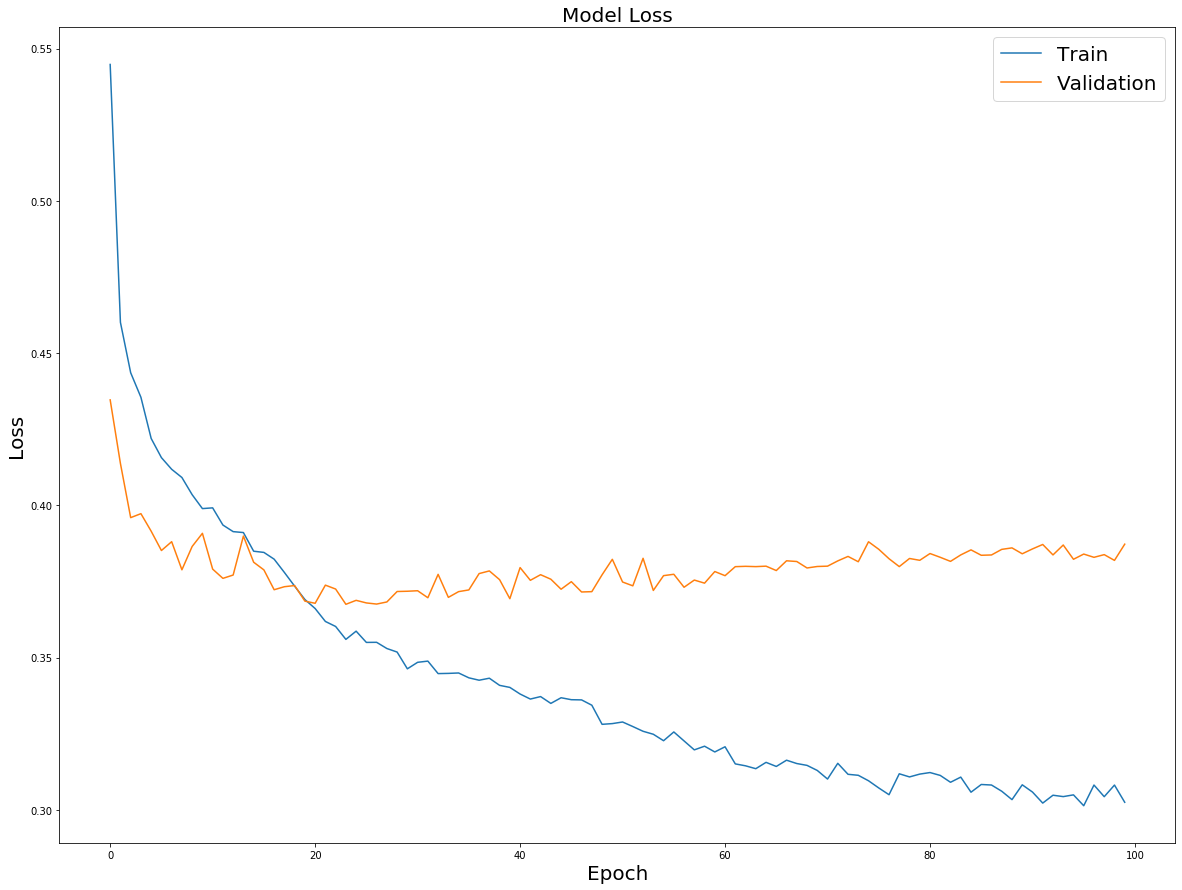

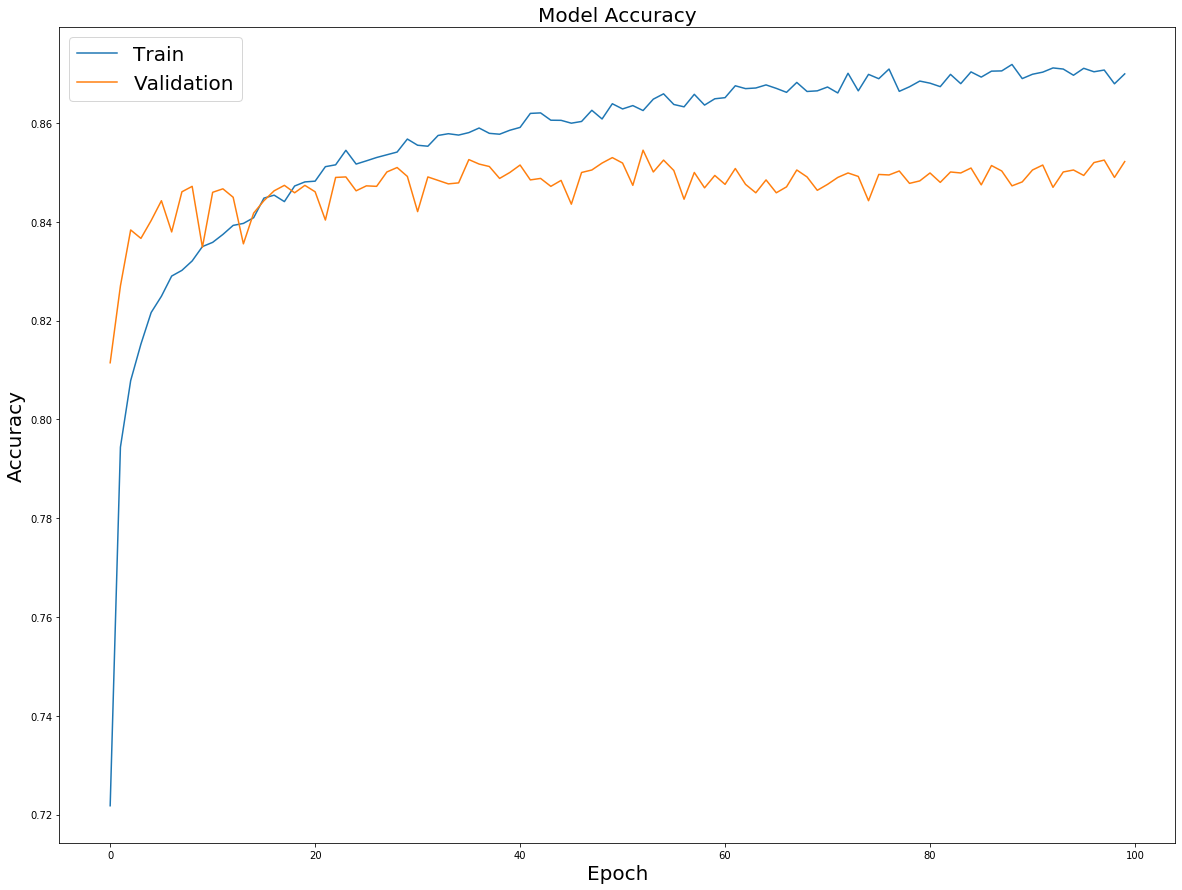

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

The training curves behave fairly normal, we reach quite a high accuracy of 85% of classification. Slight overfitting is present after approximately 20 epochs of training, however nothing very dangerous, the training and validation curves are still in a close proximity from each other.

Confusion matrix:
 [[5672  602]
 [1217 4973]]


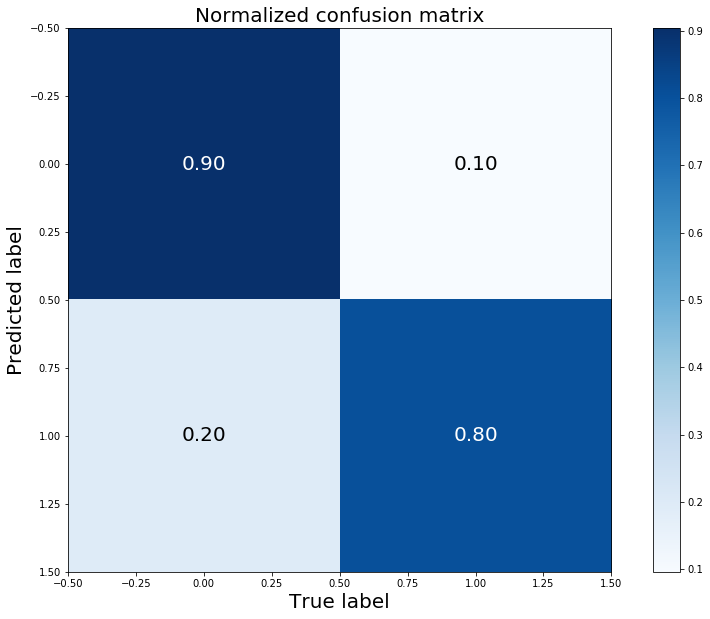

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [19]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.41%


The confusion matrix and final evaluation on the test data set demonstrate a good accuracy of 85% of sequence classification. At some point it would be interesting to have a look at the missclassified sequneces in order to understand what is wrong with them an why the CNN faild to classify them correctly. For each sequence we can not construct so-called Saliency Map, i.e. importance of each nucleotide for sequence classification. In this way we can see whether the CNN learnt certain patterns to be most important for gene vs. intergenic sequence classification.

In [20]:
import keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

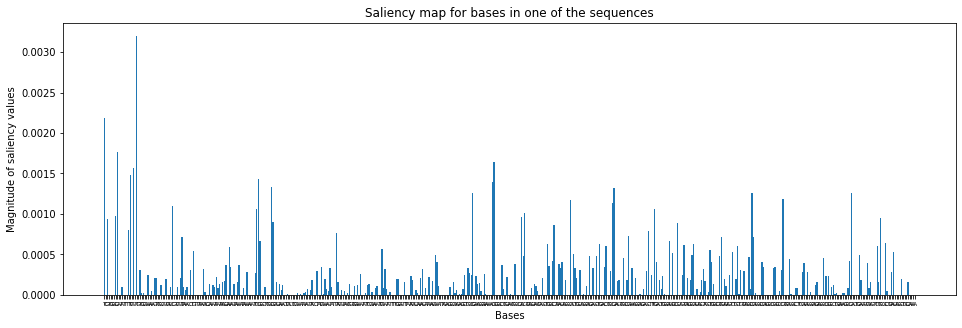

In [21]:
sequence_index = 12
K.set_learning_phase(1) #set learning phase
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
zoom = len(sal)
barlist = plt.bar(np.arange(len(sal[0:zoom])), sal[0:zoom])
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal[0:zoom])), list(sequences[sequence_index][0:zoom]), size = 6);
plt.title('Saliency map for bases in one of the sequences');
plt.show()

### Neanderthal Introgressed vs. Depleted Sequence Classification  <a class="anchor" id="Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification"></a>

Now we are going to apply a similar methodology as the one used for gene vs. intergenic sequence classification, but now we will apply it to classify regions of Neanderthal introgression within modern human genome vs. regions of depleted Neanderthal ancestry. We are goin to train our CNN model on Neanderthal introgressed haplotypes identified using S*-statistic in the study of Vernot and Akey, Science 2016, on Europeans and Asians from the 1000 Genomes project from here https://drive.google.com/drive/folders/0B9Pc7_zItMCVWUp6bWtXc2xJVkk. We used the coordinates of introgressed haplotypes from the file introgressed_haplotypes/LL.callsetEUR.mr_0.99.neand_calls_by_hap.bed.merged.by_chr.bed and selected only unique coordinates, so we ended up with 83 601 regions of Neanderthal introgression in modern Europeans. Let us read these coordinates and have a look at the length distribution of the Neanderthal introgressed regions.

In [1]:
import os
import pandas as pd
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')
intr_coords = pd.read_csv('Akey_intr_coords.bed', header = None, sep = "\t")
intr_coords.head()

0        1        2
0  chr1  2903159  2915884
1  chr1  2932446  2972497
2  chr1  2960608  2996556
3  chr1  2960608  2999518
4  chr1  2960608  3001253

In [2]:
intr_coords.shape

(83601, 3)

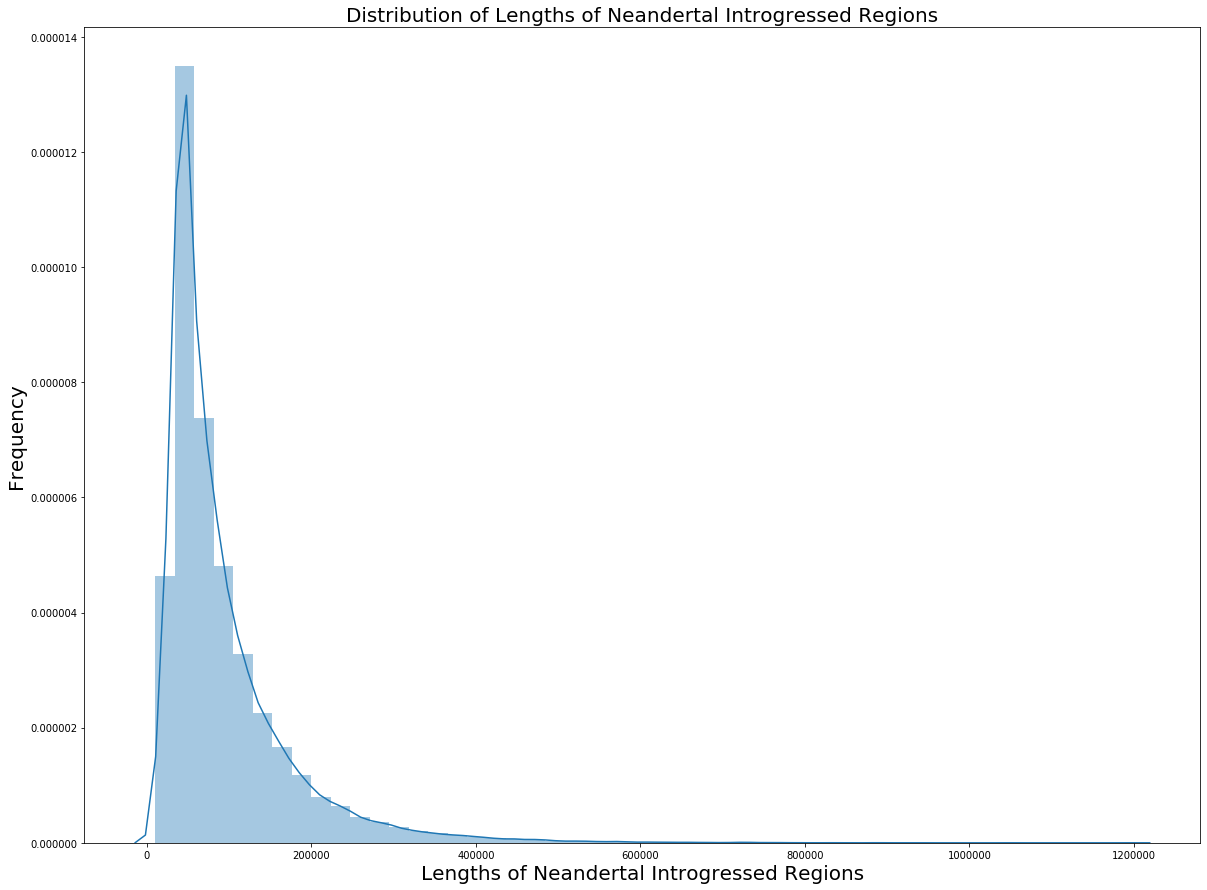

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
intr_lengths = intr_coords.iloc[:, 2]-intr_coords.iloc[:, 1]
sns.distplot(intr_lengths)
plt.title("Distribution of Lengths of Neandertal Introgressed Regions", fontsize = 20)
plt.xlabel("Lengths of Neandertal Introgressed Regions", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

In [5]:
from scipy import stats
print(stats.describe(intr_lengths))

DescribeResult(nobs=83601, minmax=(10002, 1194940), mean=92137.5803877944, variance=6139175379.516866, skewness=2.7095069302166377, kurtosis=11.38558261567325)


We can see that the regions of Neanderthal introgression are much longer compared to the lengths of genes. Here we have the sortest introgressed haplotype of length 10 kb with the median length around 100 kb. Let us now as previously use **samtools** for extracting the sequences of the Neanderthal introgressed regions from the hg19 build of human reference genome.

In [6]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')
a = 0
with open('hg19_intr_regions.fa', 'a') as fp:
    for i in range(intr_coords.shape[0]):
        coord = str(str(intr_coords.iloc[i, 0]) + ':' 
                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')

Finished 10000 Neanderthal introgressed haplotypes
Finished 20000 Neanderthal introgressed haplotypes
Finished 30000 Neanderthal introgressed haplotypes
Finished 40000 Neanderthal introgressed haplotypes
Finished 50000 Neanderthal introgressed haplotypes
Finished 60000 Neanderthal introgressed haplotypes
Finished 70000 Neanderthal introgressed haplotypes
Finished 80000 Neanderthal introgressed haplotypes


Next we will need to build a fasta-file with sequences of the same lengths but located outside of the Neanderthal introgressed regions. For this purpose we need the lengths of the human chromosomes which we can easily extract from the fai-file generated when indexing the hg19 human reference genome.

In [6]:
chr_sizes = pd.read_csv("hg19.fa.gz.fai", header = None, sep = "\t")
chr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)
chr_sizes.head()

0          1
0  chr1  249250621
1  chr2  243199373
2  chr3  198022430
3  chr4  191154276
4  chr5  180915260

Now for each gene in the **intr_coords** DataFrame, we are going to randomly draw a region of the same length as the gene on the same chromosome and check whether this region overlaps with any other gene (not only with this one) on the same chromosome. If it does not, we will add this region to the **depl_coords** DataFrame. If it does overlap, we repeat the random drawing of the region gain and again until we succeeed in selecting a truly intergenic region of the same length as the given gene.

In [10]:
import numpy as np
chr_list = []
start_list = []
end_list = []
intr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])
a = 0
for i in range(intr_coords.shape[0]):
    chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1]))
        reg_end = reg_start + intr_lengths[i]
        for j in range(chr_df.shape[0]):
            b1 = chr_df.iloc[j,1]
            b2 = chr_df.iloc[j,2]
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or \
            (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):
                overlap = True
                break
            else:
                overlap = False
    chr_list.append(intr_coords.iloc[i,0])
    start_list.append(reg_start)
    end_list.append(reg_end)
    a = a + 1
    if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')
depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
depl_coords.to_csv("Akey_depl_coords.bed", index = False, header = False, sep = "\t")
depl_coords.head()

Finished 10000 Neanderthal introgressed haplotypes
Finished 20000 Neanderthal introgressed haplotypes
Finished 30000 Neanderthal introgressed haplotypes
Finished 40000 Neanderthal introgressed haplotypes
Finished 50000 Neanderthal introgressed haplotypes
Finished 60000 Neanderthal introgressed haplotypes
Finished 70000 Neanderthal introgressed haplotypes
Finished 80000 Neanderthal introgressed haplotypes


0          1          2
0  chr1   88370430   88383155
1  chr1  248465646  248505697
2  chr1  153182329  153218277
3  chr1  132975937  133014847
4  chr1  175694680  175735325

Let us make sure that we indeed managed to contruct a set of regions of equal size as the Neanderthal introgressed regions but not overlapping with the later ones. For this purpose, we will use **bedtools intersect** and feed the introgression and depletion coordinates, the tool should not find any overlapping intervals.

In [11]:
!bedtools intersect -a Akey_intr_coords.bed -b Akey_depl_coords.bed | wc -l

0


Excellent, the two sets of coordinates do not overlap. We can continue with using the depletion coordinates and extract the actual sequences from the human reference genome hg19 using samtools.

In [12]:
import os
import subprocess
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')
a = 0
with open('hg19_depl_regions.fa', 'a') as fp:
    for i in range(depl_coords.shape[0]):
        coord = str(str(depl_coords.iloc[i, 0]) + ':' 
                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal ancestry depleted regions')

Finished 10000 Neanderthal ancestry depleted regions
Finished 20000 Neanderthal ancestry depleted regions
Finished 30000 Neanderthal ancestry depleted regions
Finished 40000 Neanderthal ancestry depleted regions
Finished 50000 Neanderthal ancestry depleted regions
Finished 60000 Neanderthal ancestry depleted regions
Finished 70000 Neanderthal ancestry depleted regions
Finished 80000 Neanderthal ancestry depleted regions


Everything looks good at first glance, howeever taking a closer look we can see that we have quite a few sequences with N-nulceotides. This is a kind of missing data since N implies nucleotides that could not be identified by the sequencer. A fast way to see the presense of N-nucleoties is to grep them.

In [13]:
!grep -c N hg19_intr_regions.fa

863


In [14]:
!grep -c N hg19_depl_regions.fa

14823006


However we know that samtools splits sequences into multiple lines, so grep does not actually detect the number of N-containing entries but the number of N-containing lines. In order to be more precise, we can quickly count using Bio Python the numbers of entries in each fasta-file that contain at least one N-nucleotide.

In [15]:
from Bio import SeqIO

i = 0
for record in SeqIO.parse('hg19_intr_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        i = i + 1
print('Introgressed regions file contains ' + str(i) + ' entries with at least one N-nucleotide')

j = 0
for record in SeqIO.parse('hg19_depl_regions.fa', 'fasta'):
    upper_record = record.seq.upper()
    if 'N' in upper_record:
        j = j + 1
print('Depleted regions file contains ' + str(j) + ' entries with at least one N-nucleotide')

Introgressed regions file contains 54 entries with at least one N-nucleotide
Depleted regions file contains 9817 entries with at least one N-nucleotide


In case fractions of missing data are different between Neanderthal introgressed and depleted regions, this might be treated as a signal by Convolutional Neural Networks (CNNs), and this is not what we are interested in. Therefore for simplicity we will remove all entries containing N-nucleotides in either Neanderthal introgressed or depleted regions. For example, if a Neanderthal introgressed region contains at least one N-nucleotide, we will drop the region together with the corresponding Neadnerthal depleted region despite that one might not contain N-nucleotides. This is needed for a better correspondence between the introgressed and depleted fasta-files.

In [16]:
from Bio import SeqIO

intr_file = 'hg19_intr_regions.fa'
depl_file = 'hg19_depl_regions.fa'
a = 0
i = 0
with open('hg19_intr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:
    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
        upper_intr = intr.seq.upper()
        upper_depl = depl.seq.upper()
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):
            intr.seq = upper_intr
            SeqIO.write(intr, intr_out, 'fasta')
            depl.seq = upper_depl
            SeqIO.write(depl, depl_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries
Finished 40000 entries
Finished 50000 entries
Finished 60000 entries
Finished 70000 entries
Finished 80000 entries
We have processed 83601 entries and written 73734 entries to two fasta-files


Thus we have removed approximately 10000 entries, but still have plenty of sequences left to run CNNs for Neanderthal introgressed vs. depleted region classification. Now let us quickly check using grep whether we indeed are free of N-containing sequences. 

In [17]:
!grep -c N hg19_intr_clean.fa

0


In [18]:
!grep -c N hg19_depl_clean.fa

0


Excellent! Now it is time to start building the input matrix of sequences to be fed int othe CNN. Since I have limited memory on my laptop, I will not read all the sequences into memory but extract first **cut = 1000** nucleotides from each sequence. The Neanderthal introgressed and depleted sequences of length less than **cut = 1000** nucleotides will be ignored and not included into the CNN input matrix. We also have to make sure that all 4 nucleotides are present at each sequence, i.e. we will omit e.g. AT or CG repeat sequences.

In [1]:
import os
from Bio import SeqIO

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

a = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    cut = 1000
    if len(str(intr.seq)) < cut or len(str(depl.seq)) < cut:
        continue
    s_intr = str(intr.seq)[0:cut]
    s_depl = str(depl.seq)[0:cut]
    if s_intr.count('A')>0 and s_intr.count('C')>0 and s_intr.count('G')>0 and s_intr.count('T')>0 and \
    s_depl.count('A')>0 and s_depl.count('C')>0 and s_depl.count('G')>0 and s_depl.count('T')>0:
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
    a = a + 1
    if a%10000 == 0:
        print('Finished ' + str(a) + ' entries')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries
Finished 40000 entries
Finished 50000 entries
Finished 60000 entries
Finished 70000 entries


In [2]:
sequences = intr_seqs + depl_seqs
len(sequences)

147468

In [3]:
import numpy as np
labels = list(np.ones(len(intr_seqs))) + list(np.zeros(len(depl_seqs)))
len(labels)

147468

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 AATGACATTA ... GGGATGGTGT
One hot encoding of Sequence #1:
 [[1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 1.]]


In [5]:
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [6]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size = 0.2, random_state = 42)

In [7]:
train_features.shape

(117974, 1000, 4)

In [8]:
train_labels.shape

(117974, 2)

In [9]:
test_features.shape

(29494, 1000, 4)

In [10]:
test_labels.shape

(29494, 2)

In [12]:
from keras.models import Sequential
from keras.regularizers import l2, l1
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Conv1D, Conv2D, Dense, MaxPooling1D, MaxPooling2D, Flatten, Dropout, Activation

import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', 
                 input_shape = (train_features.shape[1], train_features.shape[2])))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size = 2))
#model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(1000, kernel_regularizer = l1(0.00001)))
model.add(Activation("sigmoid"))
#model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))

epochs = 100
lrate = 0.001
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#sgd = SGD(lr = lrate, momentum = 0.9, nesterov = False)
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_binary_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'max')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1000, 16)          336       
_________________________________________________________________
activation_3 (Activation)    (None, 1000, 16)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 500, 16)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              8001000   
_________________________________________________________________
activation_4 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2002      
Total para

In [14]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(train_features, train_labels, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 94379 samples, validate on 23595 samples
Epoch 1/100
94379/94379 [==============================] - 307s 3ms/step - loss: 1.7224 - binary_accuracy: 0.5108 - val_loss: 1.7024 - val_binary_accuracy: 0.5140

Epoch 00001: val_binary_accuracy improved from -inf to 0.51396, saving model to weights.best.hdf5
Epoch 2/100
94379/94379 [==============================] - 315s 3ms/step - loss: 1.6905 - binary_accuracy: 0.5365 - val_loss: 1.6725 - val_binary_accuracy: 0.5497

Epoch 00002: val_binary_accuracy improved from 0.51396 to 0.54974, saving model to weights.best.hdf5
Epoch 3/100
94379/94379 [==============================] - 319s 3ms/step - loss: 1.6603 - binary_accuracy: 0.5561 - val_loss: 1.6470 - val_binary_accuracy: 0.5659

Epoch 00003: val_binary_accuracy improved from 0.54974 to 0.56588, saving model to weights.best.hdf5
Epoch 4/100
94379/94379 [==============================] - 322s 3ms/step - loss: 1.6295 - binary_accuracy: 0.5818 - val_loss: 1.6230 - val_binary_accuracy: 0.

94379/94379 [==============================] - 319s 3ms/step - loss: 1.1593 - binary_accuracy: 0.6850 - val_loss: 1.2315 - val_binary_accuracy: 0.6162

Epoch 00034: val_binary_accuracy improved from 0.61483 to 0.61623, saving model to weights.best.hdf5
Epoch 35/100
94379/94379 [==============================] - 321s 3ms/step - loss: 1.1500 - binary_accuracy: 0.6861 - val_loss: 1.2229 - val_binary_accuracy: 0.6161

Epoch 00035: val_binary_accuracy did not improve from 0.61623
Epoch 36/100
94379/94379 [==============================] - 323s 3ms/step - loss: 1.1413 - binary_accuracy: 0.6874 - val_loss: 1.2313 - val_binary_accuracy: 0.6093

Epoch 00036: val_binary_accuracy did not improve from 0.61623
Epoch 37/100
94379/94379 [==============================] - 325s 3ms/step - loss: 1.1322 - binary_accuracy: 0.6875 - val_loss: 1.2080 - val_binary_accuracy: 0.6176

Epoch 00037: val_binary_accuracy improved from 0.61623 to 0.61759, saving model to weights.best.hdf5
Epoch 38/100
94379/94379 [=


Epoch 00067: val_binary_accuracy did not improve from 0.65582
Epoch 68/100
94379/94379 [==============================] - 320s 3ms/step - loss: 0.7996 - binary_accuracy: 0.8195 - val_loss: 1.0641 - val_binary_accuracy: 0.6599

Epoch 00068: val_binary_accuracy improved from 0.65582 to 0.65989, saving model to weights.best.hdf5
Epoch 69/100
94379/94379 [==============================] - 320s 3ms/step - loss: 0.7791 - binary_accuracy: 0.8326 - val_loss: 1.0512 - val_binary_accuracy: 0.6665

Epoch 00069: val_binary_accuracy improved from 0.65989 to 0.66645, saving model to weights.best.hdf5
Epoch 70/100
94379/94379 [==============================] - 319s 3ms/step - loss: 0.7532 - binary_accuracy: 0.8477 - val_loss: 1.0178 - val_binary_accuracy: 0.6648

Epoch 00070: val_binary_accuracy did not improve from 0.66645
Epoch 71/100
94379/94379 [==============================] - 320s 3ms/step - loss: 0.7268 - binary_accuracy: 0.8636 - val_loss: 1.0189 - val_binary_accuracy: 0.6779

Epoch 00071: 

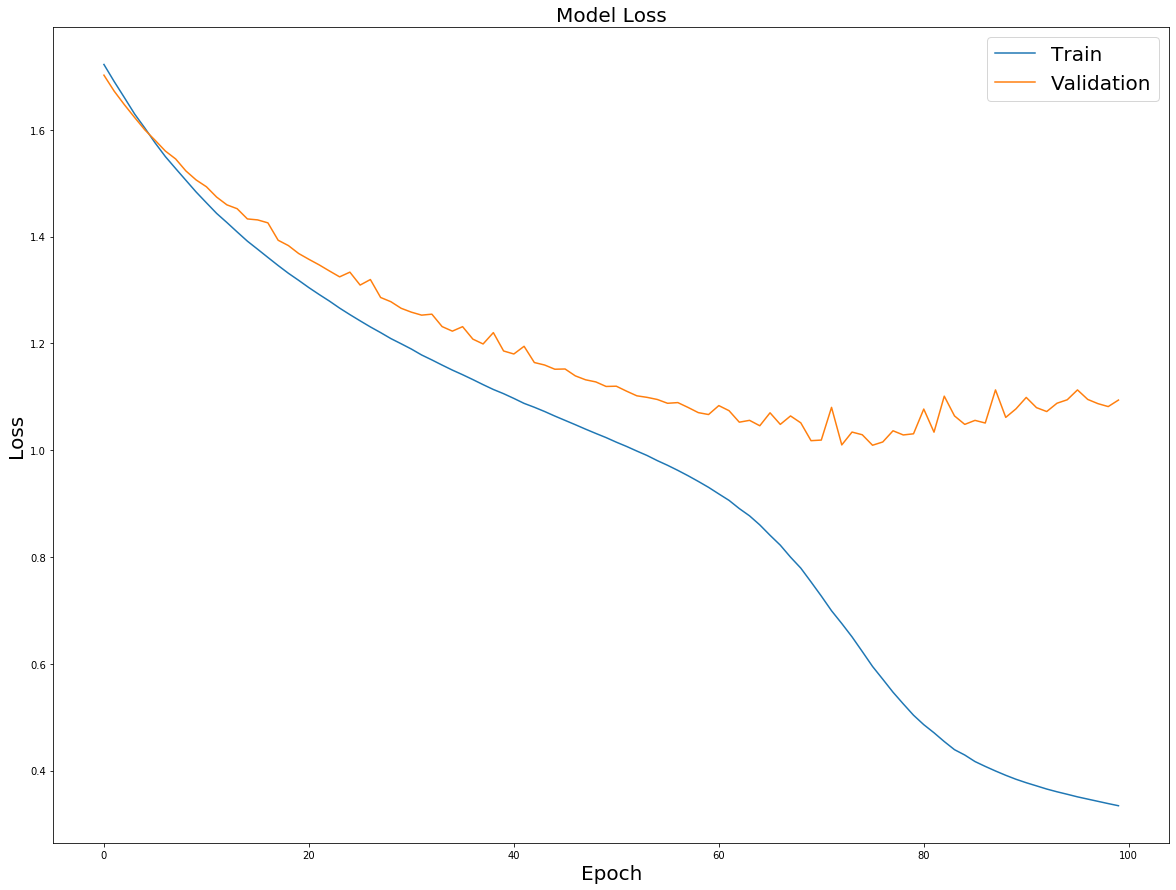

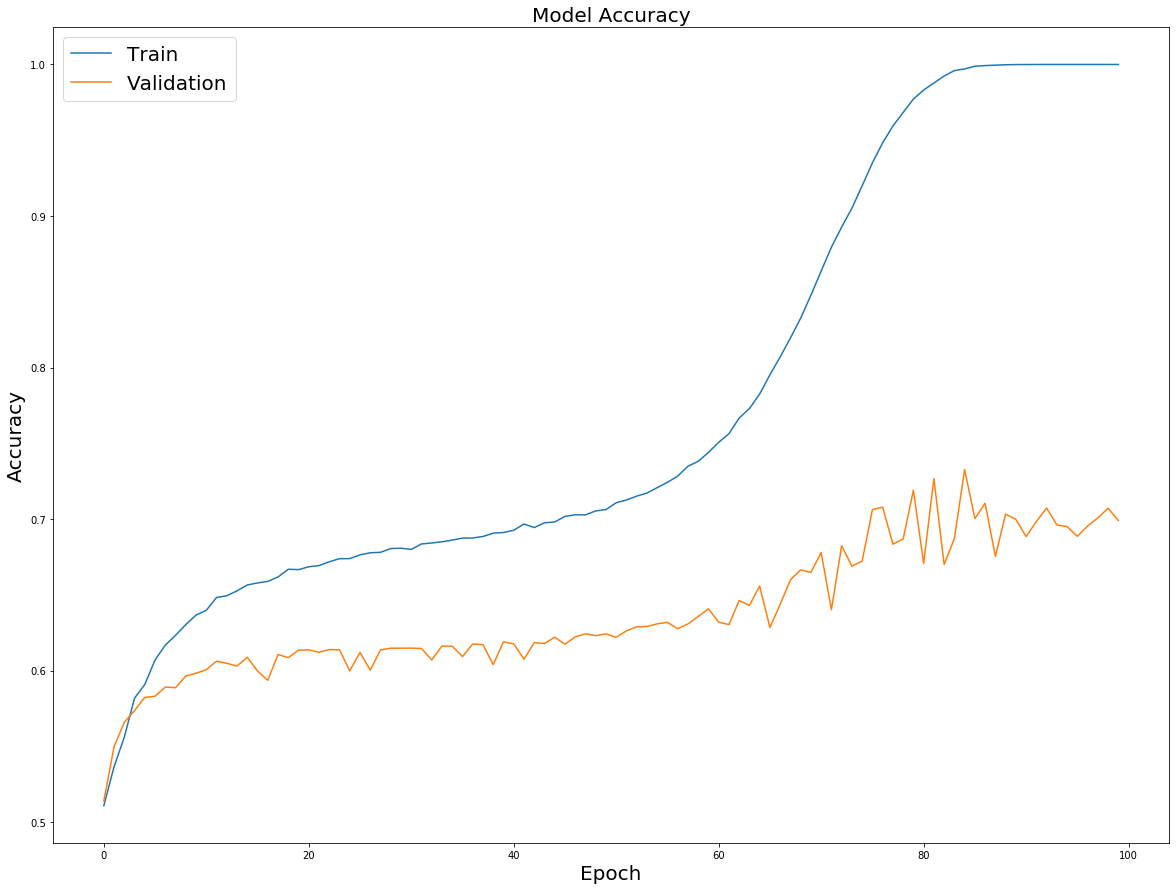

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

We can see that the model starts overfitting almost immediately and it is hard to regularize it, i.e. adding heavier Dropout prevents model from starting leraning. Hard to say why we observe this behavior. The number of examples for training is almost 100 000 which seems to be a lot, although it is still not enough if you look at how many parameters the CNN used. What we definitely observe is that increasing the length of the segments **cut** provides higher and higher accuracy of classification. Here I am restricted by the memory of my laptop and can not further increase the length of the segments. In addition, it would lead to even larger parameter space, i.e. even heavier overfitting. Perhaps more examples would help, for example chopping each Neanderthal introgression segment into multiple short ~100 bp segments would increase the training set without increasing the parameter space.

Confusion matrix:
 [[ 9864  5049]
 [ 3554 11027]]


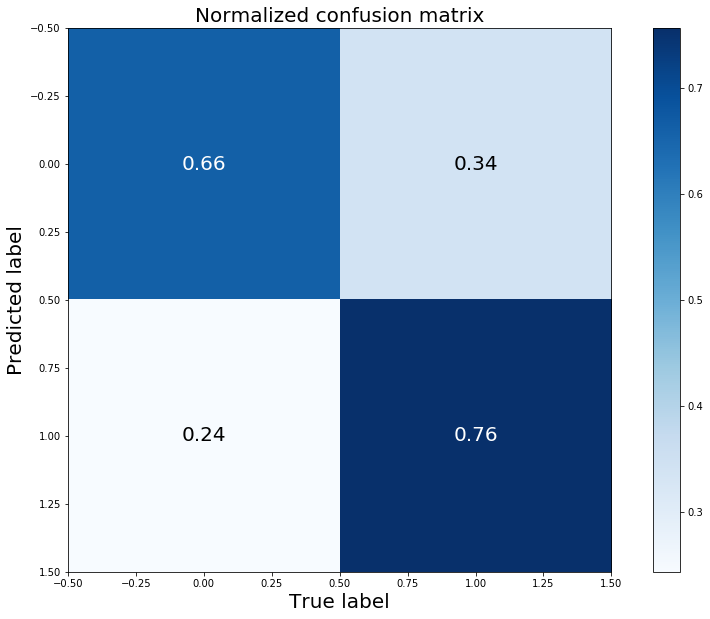

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [20]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.0f%%" % (scores[1]*100))

Accuracy: 71%


We reach quite good accuracy of 71% on the test data set. This is not fantastic but perhaps can be improved by a more clever selection of the regions of Neanderthal introgression, i.e. applying RepeatMasker or something like this. Again, similar to the gene vs. intergenic regions calssification, for each sequence we can not construct so-called Saliency Map, i.e. importance of each nucleotide for sequence classification. In this way we can see whether the CNN learnt certain patterns to be most important for Neanderthal introgression vs. depletion sequence classification.

In [21]:
import keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

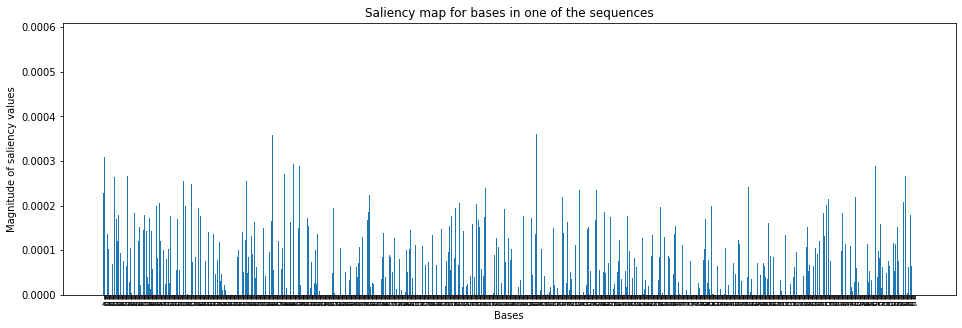

In [22]:
sequence_index = 5
K.set_learning_phase(1) #set learning phase
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
zoom = len(sal)
barlist = plt.bar(np.arange(len(sal[0:zoom])), sal[0:zoom])
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal[0:zoom])), list(sequences[sequence_index][0:zoom]), size = 6);
plt.title('Saliency map for bases in one of the sequences');
plt.show()

#### 2D CNN for Neanderthal Introgressed vs. Depleted Sequence Classification <a class="anchor" id="2D-CNN-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification"></a>

Here we will try to convert our sequences into 2D images and run a 2D Convolutional Neural Network (CNN) as if we were to solve a pattern recognition task for image classification. The problem is that the final numpy array will be 4-dimensional: first dimension is the number of sequences / statistical observations / examples for training, second and third dimensions will be the 2D image size (aka in pixels, where one pixel means one nucleotide), fourth dimension will be the probability to observe one of the 4 nucleotides (A, C, T or G) or this can be seen as a dimension corresponding to 4 channels in a CMYK color coding. Because of the 4D structure of the input data set, I will need more memory than I have on my laptop. Currently I can input 1000bp stretches of DNA (with the following one-hot-encoding) when implementing 1D CNN, or alternatively I can input 32bp stretches of DNA working with 2D CNN since $32x32 \approx 1000$.

In [ ]:
import os
from Bio import SeqIO

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

a = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    cut = 32
    if len(str(intr.seq)) < cut or len(str(depl.seq)) < cut:
        continue
    s_intr = str(intr.seq)[0:cut]
    s_depl = str(depl.seq)[0:cut]
    if s_intr.count('A')>0 and s_intr.count('C')>0 and s_intr.count('G')>0 and s_intr.count('T')>0 and \
    s_depl.count('A')>0 and s_depl.count('C')>0 and s_depl.count('G')>0 and s_depl.count('T')>0:
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
    a = a + 1
    if a%10000 == 0:
        print('Finished ' + str(a) + ' entries')

In [ ]:
sequences = intr_seqs + depl_seqs
len(sequences)

In [ ]:
import numpy as np
labels = list(np.ones(len(intr_seqs))) + list(np.zeros(len(depl_seqs)))
len(labels)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

In [ ]:
one_hot_encoder = OneHotEncoder()
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

In [ ]:
input_features.shape

In [ ]:
B = np.array(np.repeat(input_features[:, :, np.newaxis, :], repeats = input_features.shape[1], axis = 2))
B.shape

In [ ]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    B, input_labels, test_size = 0.2, random_state = 42)

In [ ]:
from keras.models import Sequential
from keras.regularizers import l2, l1
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Conv1D, Conv2D, Dense, MaxPooling1D, MaxPooling2D, Flatten, Dropout, Activation

import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', 
                 input_shape = (train_features.shape[1], train_features.shape[2], train_features.shape[3])))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
#model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(10)) # kernel_regularizer = l1(0.00001)
model.add(Activation("sigmoid"))
#model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))

epochs = 100
lrate = 0.001
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#sgd = SGD(lr = lrate, momentum = 0.9, nesterov = False)
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_binary_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'max')
model.summary()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(train_features, train_labels, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

### Intersect Neanderthal Segments with Genes  <a class="anchor" id="Intersect-Neanderthal-Segments-with-Genes"></a>

Here we are going to ask a simple question: do human genes from hg19 refernce genome predominantly overlap with Neanderthal introgressed or depleted regions? To answer this question we are going to do heavy randomizations. First, we will use **bedtools** to calculate the number of intersects between Neanderthal introgressed regions and genes. Second, we are going to randomly draw Neanderthal depleted regions of the same length as the introgressed regions a number of times and calculate intersects with the genes for each draw. In this way we will plot the distribution of the intersects between the depleted and gene regions and show whether the genes predominantly overlap with the Neanderthal introgressed or depleted regions. Let us start with reading the coordinates of the introgressed regions:

In [1]:
import os
import pandas as pd
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')
intr_coords = pd.read_csv('Akey_intr_coords.bed', header = None, sep = "\t")
intr_coords.head()

0        1        2
0  chr1  2903159  2915884
1  chr1  2932446  2972497
2  chr1  2960608  2996556
3  chr1  2960608  2999518
4  chr1  2960608  3001253

Now let us check the number of intersects between the introgressed regions and the genes from hg19 human reference genome:

In [2]:
%%bash
Path=/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes
bedtools intersect -a Akey_intr_coords.bed -b $Path/gene_coords.txt | wc -l

140821


And for comparision let us check the number of intersects between the depleted regions and the genes from hg19 human reference genome:

In [3]:
%%bash
Path=/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes
bedtools intersect -a Akey_depl_coords.bed -b $Path/gene_coords.txt | wc -l

150438


We can see that genes intersect with depleted regions more often than with the introgressed ones. However what if we just managed by chance select "good" depleted regions that happen to overlap more often with the genes. To make a robust statement about overlapping of introgressed vs. depleted regions with genes we need to randomly draw depleted regions at least a few more times. To do that we again need to know the lengths of the chromosomes from hg19.

In [4]:
chr_sizes = pd.read_csv("hg19.fa.gz.fai", header = None, sep = "\t")
chr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)
chr_sizes.head()

0          1
0  chr1  249250621
1  chr2  243199373
2  chr3  198022430
3  chr4  191154276
4  chr5  180915260

Now we repeat drawing depleted regions a few times. This procedure takes quite a lot of time due to my non-optimal code implementation. So I will repeat this ~10-20 times, which should be enough to demonstrate that the number of intersects between depeleted regions and genes is always larger than between the introgressed regions and genes. 

In [5]:
import os
import subprocess
import numpy as np
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

perm_n = []
for k in range(5):
    chr_list = []
    start_list = []
    end_list = []
    intr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])
    a = 0
    for i in range(intr_coords.shape[0]):
        chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]
        overlap = True
        while overlap == True:
            reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0]==intr_coords.iloc[i,0]].iloc[:,1]))
            reg_end = reg_start + intr_lengths[i]
            for j in range(chr_df.shape[0]):
                b1 = chr_df.iloc[j,1]
                b2 = chr_df.iloc[j,2]
                if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or \
                (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):
                    overlap = True
                    break
                else:
                    overlap = False
        chr_list.append(intr_coords.iloc[i,0])
        start_list.append(reg_start)
        end_list.append(reg_end)
        a = a + 1
        if a%20000 == 0:
            print('Finished ' + str(a) + ' Neanderthal haplotypes')
    depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
    depl_coords.to_csv("temp.txt", index = False, header = False, sep = "\t")

    genes_path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/'
    with open('n.txt', 'w') as fp:
        subprocess.run(['bedtools', 'intersect', '-a', 'temp.txt', '-b', 
                        genes_path + 'gene_coords.txt'], stdout = fp)
    akey_n = pd.read_csv('n.txt', header = None, sep = "\t")
    print(k, akey_n.shape[0])
    print('**********************************************************')
    perm_n.append(akey_n.shape[0])

Finished 20000 Neanderthal haplotypes
Finished 40000 Neanderthal haplotypes
Finished 60000 Neanderthal haplotypes
Finished 80000 Neanderthal haplotypes
0 150060
**********************************************************
Finished 20000 Neanderthal haplotypes
Finished 40000 Neanderthal haplotypes
Finished 60000 Neanderthal haplotypes
Finished 80000 Neanderthal haplotypes
1 151156
**********************************************************
Finished 20000 Neanderthal haplotypes
Finished 40000 Neanderthal haplotypes
Finished 60000 Neanderthal haplotypes
Finished 80000 Neanderthal haplotypes
2 149792
**********************************************************
Finished 20000 Neanderthal haplotypes
Finished 40000 Neanderthal haplotypes
Finished 60000 Neanderthal haplotypes
Finished 80000 Neanderthal haplotypes
3 150381
**********************************************************
Finished 20000 Neanderthal haplotypes
Finished 40000 Neanderthal haplotypes
Finished 60000 Neanderthal haplotypes
Finish

In [9]:
perm_n = [150438, 150340, 149772, 149798, 149664, 150748, 151154, 
          150818, 150498, 151426, 151244, 151267, 150060, 151156, 149792, 150381, 150075]
perm_n

[150438,
 150340,
 149772,
 149798,
 149664,
 150748,
 151154,
 150818,
 150498,
 151426,
 151244,
 151267,
 150060,
 151156,
 149792,
 150381,
 150075]

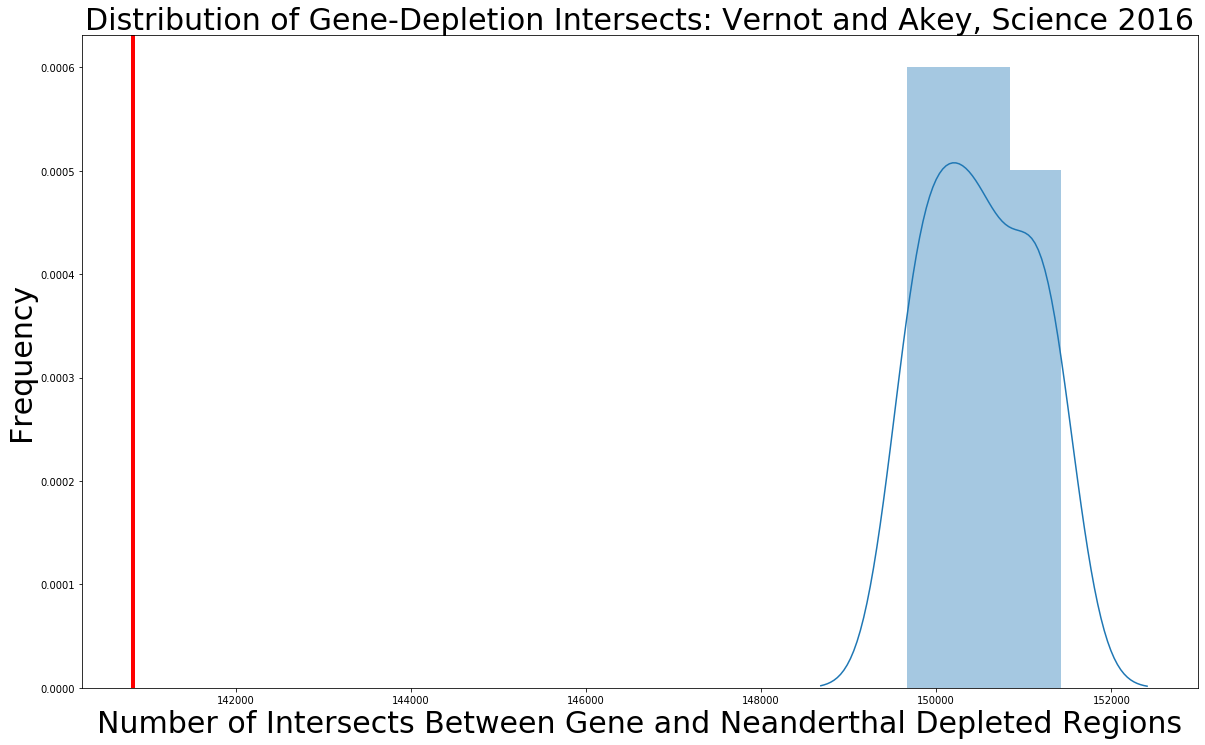

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.axvline(x = 140821, linewidth = 4, color = 'r')
sns.distplot(perm_n)
plt.title("Distribution of Gene-Depletion Intersects: Vernot and Akey, Science 2016", fontsize = 30)
plt.xlabel("Number of Intersects Between Gene and Neanderthal Depleted Regions", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.show()

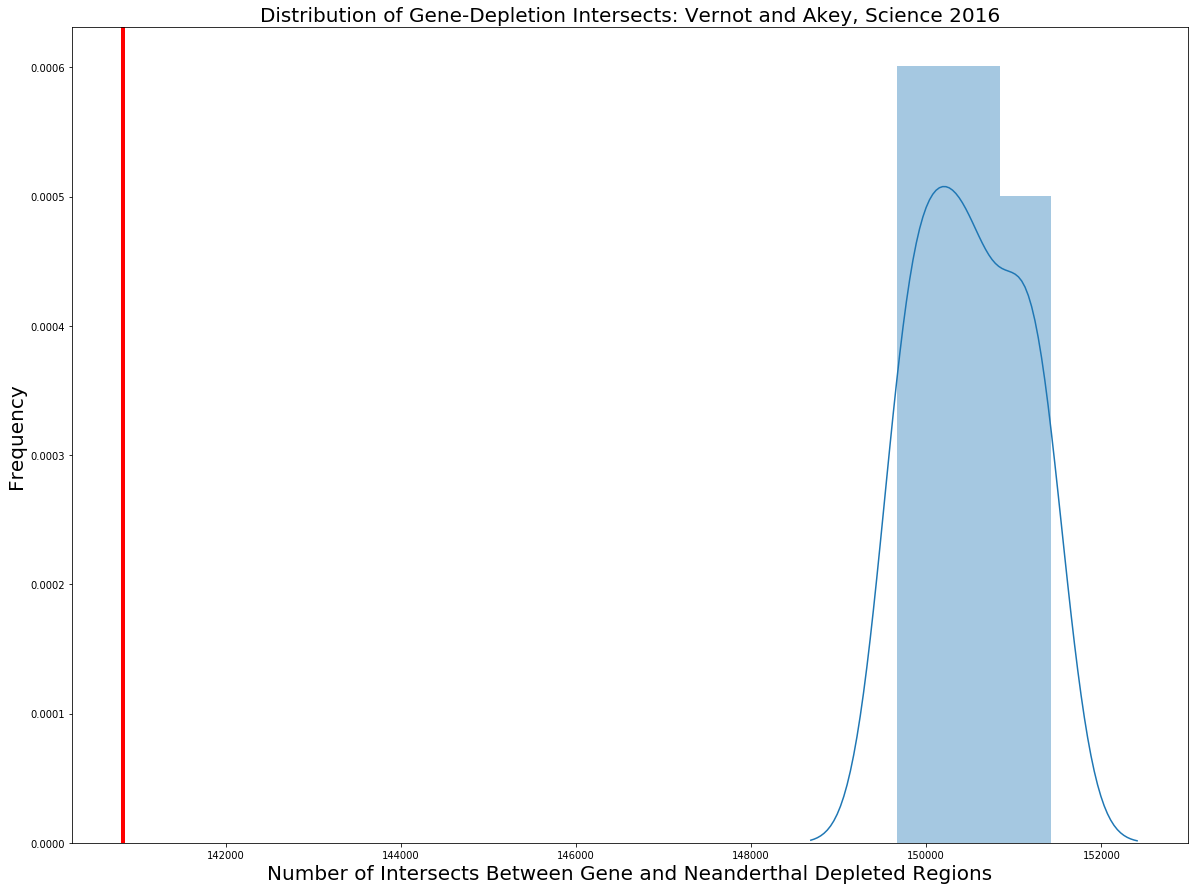

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.axvline(x = 140821, linewidth = 4, color = 'r')
sns.distplot(perm_n)
plt.title("Distribution of Gene-Depletion Intersects: Vernot and Akey, Science 2016", fontsize = 20)
plt.xlabel("Number of Intersects Between Gene and Neanderthal Depleted Regions", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

Here it is remarkable that none of the 17 drawings of depleted regions gives the number of intersects with genes which is below the number of intersects between the introgressed regions and the genes. If we were to calculate a p-value of the enrichment, this would be essentially but a more correct way to express it would pvalue < 1 / 17 = 0.06. This proves that genes predominantly overlap with the regions of depleted Neanderthal ancestry.

### Ranking Genes by Their GC- and AT-Content  <a class="anchor" id="Ranking-Genes-by-Their-GC--and-AT-Content"></a>

Now let us perform a simple exercise which will be very useful for us in the future. Here we are going to calculate GC-content of each gene from their sequences. We do have a fasta-file with sequences for each gene extracted from the hg19 build of human reference genome. Now it will be relatively easy to go throug those sequences one-by-one and count the percentages of C ad G nucleotides. The goal of this exercise is to figure out which genes in human genome are most GC-rich and most AT-rich, again, this we will need in the future.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/')

ids = []
seqs = []
GC_content = []
with open('hg19_gene_regions.fa','r') as fin:
    for line in fin:
        line = line.rstrip()
        if line[0] == '>' and len(seqs) == 0:
            ids.append(line)
        elif line[0] == '>' and len(seqs) > 0:
            my_seq = ''.join(seqs).upper()
            GC = round((my_seq.count('C') + my_seq.count('G')) / (len(my_seq) - my_seq.count('N')), 4) * 100
            GC_content.append(GC)
            seqs = []
            ids.append(line)
        else:
            seqs.append(line)
my_seq = ''.join(seqs).upper()
GC = round((my_seq.count('C') + my_seq.count('G')) / (len(my_seq) - my_seq.count('N')), 4) * 100
GC_content.append(GC)

GC_df = pd.DataFrame({'Coord': ids, 'GCcontent': GC_content})
GC_df = GC_df.sort_values(by = ['GCcontent'], ascending = False)
print('Most GC-rich genes:')
print(GC_df.head())
print('\n')
print('Most AT-rich genes:')
print(GC_df.tail())
GC_df.to_csv('genes_GC_content.txt', index = False, header = True, sep = '\t')

Most GC-rich genes:
                                Coord  GCcontent
32749  >chr6_cox_hap2:4729257-4729276      100.0
33853  >chr6_qbl_hap6:4517689-4517708      100.0
30984         >chr6:33285442-33285461      100.0
33032  >chr6_dbb_hap3:4566766-4566785      100.0
33562  >chr6_mcf_hap5:4759185-4759204      100.0


Most AT-rich genes:
                            Coord  GCcontent
10653    >chr14:37421514-37421596      24.10
31972   >chr6:140526389-140526463      21.33
9227   >chr12:116586365-116586459      21.05
10579    >chr14:28102411-28102484      20.27
28113   >chr4:126428414-126428462      16.33


In [4]:
%%bash
cd /home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/
samtools faidx hg19.fa.gz chr4:126428414-126428462 | sed '1d' | tr -d '\n'

CTGTAATATAAATTTAATTTATTCTCTATCATTAAAAAATGTATTACAG

In [5]:
my_str = 'CTGTAATATAAATTTAATTTATTCTCTATCATTAAAAAATGTATTACAG'
(my_str.count('C') + my_str.count('G')) / len(my_str)

0.16326530612244897

Ok, it would be nice to see the gene symbols. It is trange to see genes with 100% GC-content, those must be some non-coding RNAs.

In [6]:
import pandas as pd
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/'
gene_coords = pd.read_csv(Path + 'gene_coords.txt', header=None, sep="\t")
gene_coords['Coord'] = '>' + gene_coords[0].astype(str) + ':' \
+ gene_coords[1].astype(str) + '-' + gene_coords[2].astype(str)
gene_coords.head()

0      1      2          3              Coord
0  chr1  11874  14409    DDX11L1  >chr1:11874-14409
1  chr1  14362  29370     WASH7P  >chr1:14362-29370
2  chr1  17369  17436  MIR6859-1  >chr1:17369-17436
3  chr1  17369  17436  MIR6859-2  >chr1:17369-17436
4  chr1  17369  17436  MIR6859-3  >chr1:17369-17436

In [16]:
GC_df_gene = pd.merge(GC_df, gene_coords, on = 'Coord')
GC_df_gene = GC_df_gene[[3, 0, 1, 2, 'GCcontent']]
GC_df_gene.columns = ['Gene', 'Chr', 'Start', 'End', 'GCcontent']
GC_df_gene.head()

Gene            Chr     Start       End  GCcontent
0  MIR1234  chr6_cox_hap2   4729257   4729276      100.0
1  MIR1234  chr6_qbl_hap6   4517689   4517708      100.0
2  MIR1234           chr6  33285442  33285461      100.0
3  MIR1234  chr6_dbb_hap3   4566766   4566785      100.0
4  MIR1234  chr6_mcf_hap5   4759185   4759204      100.0

In [17]:
GC_df_gene.tail()

Gene    Chr      Start        End  GCcontent
44993  MIR4503  chr14   37421514   37421596      24.10
44994  MIR3668   chr6  140526389  140526463      21.33
44995   MIR620  chr12  116586365  116586459      21.05
44996  MIR3171  chr14   28102411   28102484      20.27
44997  MIR2054   chr4  126428414  126428462      16.33

Yes, indeed, the micro-RNAs (the MIR-genes) seem to be extreme in the GC-content. Let us filter them out and display most GC-rich and and most AT-rich genes again without the MIR-genes, LINC-genes or SNOR-genes which are the small non-coding RNAs. 

In [22]:
GC_df_gene_noMIR = GC_df_gene[~GC_df_gene['Gene'].str.contains('MIR')]
GC_df_gene_noMIR = GC_df_gene_noMIR[~GC_df_gene_noMIR['Gene'].str.contains('LINC')]
GC_df_gene_noMIR = GC_df_gene_noMIR[~GC_df_gene_noMIR['Gene'].str.contains('SNOR')]
GC_df_gene_noMIR.head(10)

Gene    Chr      Start        End  GCcontent
81     BHLHA9  chr17    1173858    1174565      78.67
93       UTF1  chr10  135043778  135045062      76.96
105    RNF225  chr19   58907457   58908446      75.96
108       NPB  chr17   79859985   79860781      75.66
126  LKAAEAR1  chr20   62714733   62715712      75.20
127    LRRC26   chr9  140063212  140064491      75.16
132     CTXN1  chr19    7989381    7991051      74.93
140   ZNRF2P2   chr7   29724388   29725437      74.38
141      HES4   chr1     934344     935552      74.36
142      HES4   chr1     934342     935552      74.32

In [36]:
GC_df_gene_noMIR.to_csv('genes_GC_content.txt', index = False, header = True, sep = '\t')
GC_df_gene_noMIR.tail(10)

Gene    Chr      Start        End  GCcontent
44833            SI   chr3  164696686  164796283      31.26
44836  LOC105374704   chr5   29880667   29882210      31.22
44910   SPATA17-AS1   chr1  217954540  217958462      30.82
44912         GPR22   chr7  107110502  107116125      30.58
44916         CYLC2   chr9  105757593  105780770      30.37
44925     HIF1A-AS2  chr14   62213757   62215807      29.99
44937       ANGPTL3   chr1   63063158   63071976      29.49
44939           NTS  chr12   86268073   86276770      29.39
44975  LOC102467226   chr5  120658245  120661532      27.43
44981       DEFB114   chr6   49928005   49931818      26.85

It is very interesting that there are human genes (that are not small non-coding RNAs) with GC-content as large as ~80% and there are genes with as little as ~30% of GC-content. Let us display the distribution of the GC-content across genes. 

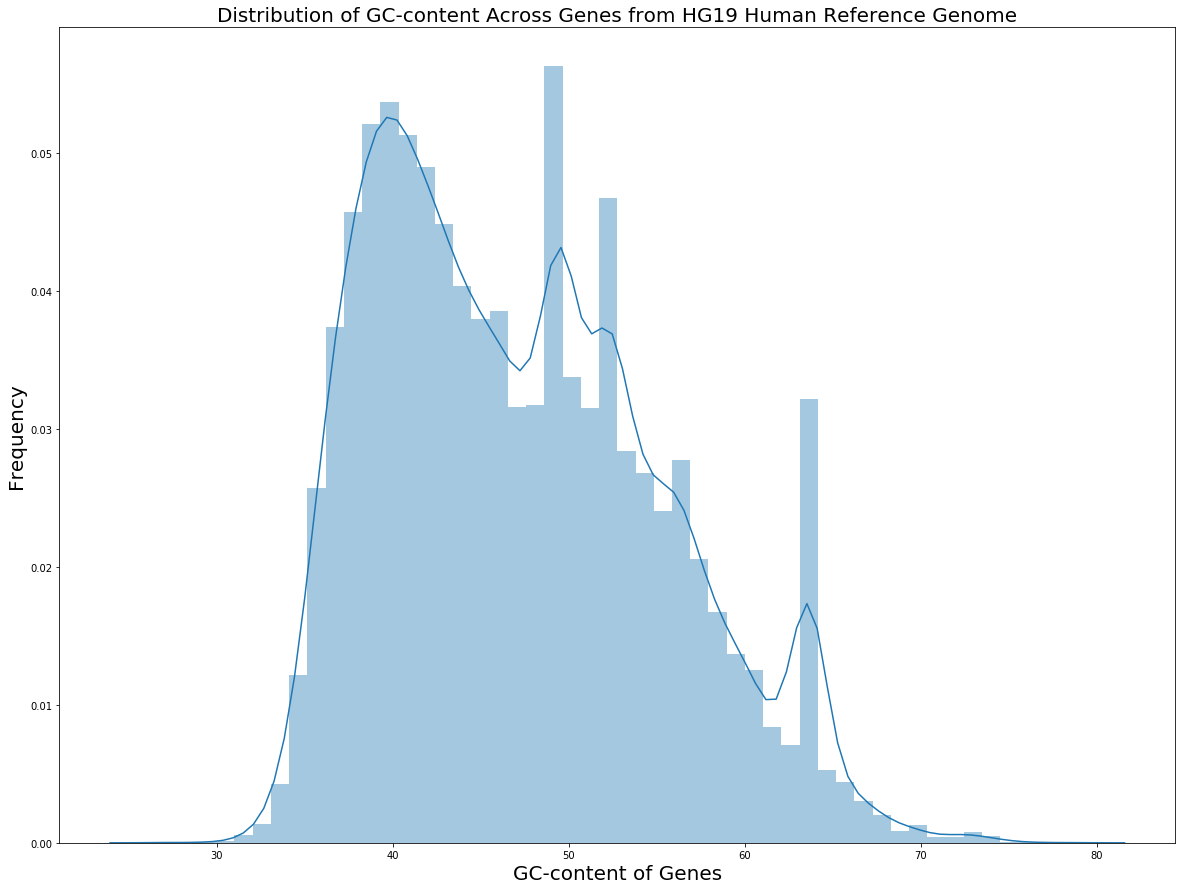

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
sns.distplot(GC_df_gene_noMIR['GCcontent'])
plt.title("Distribution of GC-content Across Genes from HG19 Human Reference Genome", fontsize = 20)
plt.xlabel("GC-content of Genes", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

We can see that the mode is indeed at aroud 41% as it is expected to be, however the distribution does not look very symmetric and seems to have much more genes with GC-content larger than 41% than those with GC-content below 41%. This probably reflects the known statement that genes are ingeneral GC-rich regions. If we calculate the mean GC-content of the gene regions, it will be arounf 47% which is much higher than 41% across the whole human reference genome.

In [38]:
np.mean(GC_df_gene_noMIR['GCcontent'])

47.254267483922824

Another very interesting observation is that there is **ANGPTL3** gene which is very AT-rich with GC-content only ~30%. This gene has a very strong link to [**HDL cholesterol**](https://en.wikipedia.org/wiki/ANGPTL3) levels in human blood which is one of determnant factors for genetics of **Type 2 Diabetes (T2D) Mellitus**. Indeed, if we display a piece of the ANGPTL3 gene we observe that it is an extremely GC-poor gene.

In [34]:
%%bash
cd /home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/
samtools faidx hg19.fa.gz chr1:63063158-63071976 | sed '1d' | tr -d '\n' | cut -c1-500

ATATATAGAGTTAAGAAGTCTAGGTCTGCTTCCAGAAGAAAACAGTTCCACGTTGCTTGAAATTGAAAATCAAGATAAAAATGTTCACAATTAAGCTCCTTCTTTTTATTGTTCCTCTAGTTATTTCCTCCAGAATTGATCAAGACAATTCATCATTTGATTCTCTATCTCCAGAGCCAAAATCAAGATTTGCTATGTTAGACGATGTAAAAATTTTAGCCAATGGCCTCCTTCAGTTGGGACATGGTCTTAAAGACTTTGTCCATAAGACGAAGGGCCAAATTAATGACATATTTCAAAAACTCAACATATTTGATCAGTCTTTTTATGATCTATCGCTGCAAACCAGTGAAATCAAAGAAGAAGAAAAGGAACTGAGAAGAACTACATATAAACTACAAGTCAAAAATGAAGAGGTAAAGAATATGTCACTTGAACTCAACTCAAAACTTGAAAGCCTCCTAGAAGAAAAAATTCTACTTCAACAAAAAGTGAAATAT


Below we will show that AT-rich regions predominantly came to the human genome from Neanderthals. Particularly, the ANGPTL3 gene will be predicted to be a Neanderthal gene that was introgressed into the modern human genome ~2000 generations ago when humans migrated out of Africa and bred with Neanderthals in Europe and Asia.

### Bag of Words for Neanderthal Introgressed vs. Depleted Sequence Classification  <a class="anchor" id="Bag-of-Words-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification"></a>

Here we are going to use elements of the Natural Language Processing (NLP) and K-mer analysis in order to find DNA motifs that differ between Neanderthal introgressed and depleted regions of human genome. DNA sequence is essentially a text so we can apply the whole power of NLP apparatus to DNA analysis. However, where are sentences and words in one large DNA sequence? It turns out that a sequence can be split into K-mers which represent words / tokens and those K-mers can be concatenated in a space-dilimited manner so that we get a sentence at the end. Now we are done, we cen use NLP!

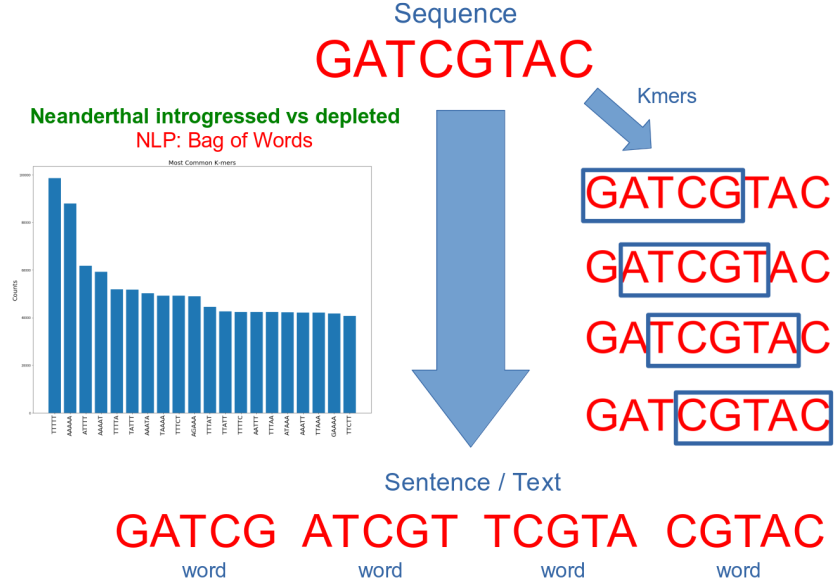

In [1]:
from IPython.display import Image
Path = '/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/'
Image(Path + 'Kmers.png', width=2000)

Here we will start with the simplest Bag of Words model that simply counts frequencies of words / K-mers between two different classes of texts / sequences. In our case we are asking: do Neanderthal introgressed regions contain more frequent K-mers compared to the regions of depleted Neanderthal ancestry? To answer this question we are going to read the introgressed and depleted sequences and split them into K-mers:

In [2]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 500
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    #my_intr_reverse_compliment_seq = str(Seq(my_intr_seq).reverse_complement())
    #intr_seqs.append(my_intr_reverse_compliment_seq)
    
    depl_seqs.append(my_depl_seq)
    #my_depl_reverse_compliment_seq = str(Seq(my_depl_seq).reverse_complement())
    #depl_seqs.append(my_depl_reverse_compliment_seq)
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


Now, after we have read the introgressed and depleted sequences into the memory, we will need to define a function that splits each given sequence into K-mers, and use it for preprocessing the sequences and converting them into **sentences** via K-mers construction. Suppose the sequences in the list above are different texts. It is natural to consider k-mers as words of those texts. Different sequences can share the same k-mers indicating that the same words can be used in different texts. However, there are words / k-mers that are specific for certain texts / sequences, or their number can say something about the topic of the text / biology of the sequence. Here we are going to split each sequence into k-mers and construct **sentences** which represent lists of words / k-mers.

In [3]:
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

In [4]:
kmer = 5

print('Building Neanderthal introgressed sequences')
intr_sentences = []
for i in range(len(intr_seqs)):
    intr_sentences.append(getKmers(intr_seqs[i], kmer))

print('Building Neanderthal depleted sequences')
depl_sentences = []
for i in range(len(depl_seqs)):
    depl_sentences.append(getKmers(depl_seqs[i], kmer))

Building Neanderthal introgressed sequences
Building Neanderthal depleted sequences


The words / k-mers provide a vocabulary, we will determine its size later. We can also use the **Counter** class for an efficient counting of the words as well as displaying and making barplots of the most common words for Neanderthal introgressed and depleted regions. 

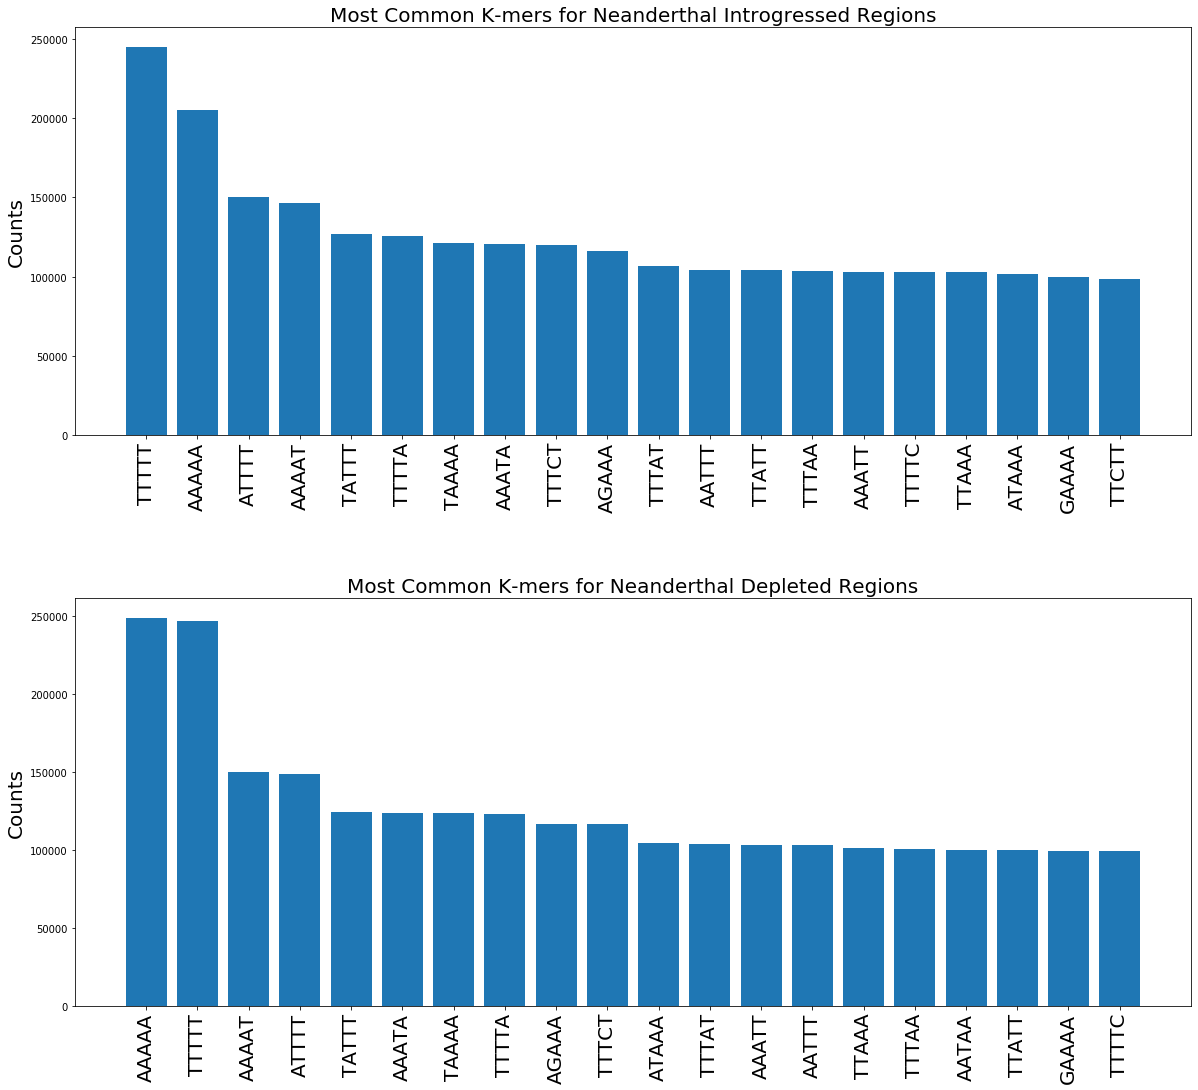

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,18))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

plt.subplot(2, 1, 1)
D = dict(Counter([item for sublist in intr_sentences for item in sublist]).most_common(20))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.title('Most Common K-mers for Neanderthal Introgressed Regions', fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.xticks(rotation = 90)
plt.xticks(range(len(D)), list(D.keys()), fontsize = 20)

plt.subplot(2, 1, 2)
D = dict(Counter([item for sublist in depl_sentences for item in sublist]).most_common(20))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.title('Most Common K-mers for Neanderthal Depleted Regions', fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.xticks(rotation = 90)
plt.xticks(range(len(D)), list(D.keys()), fontsize = 20)

plt.show()

We can see that A- and T-rich K-mers seem to be most common for both Neanderthal introgressed and depleted regions. However, there are small differences in their counts that might be indicative for different composition between them. We can also build the data frames of K-mer counts for both Neanderthal introgressed and depleted regions and display them:

In [7]:
import pandas as pd
intr_counts = dict(Counter([item for sublist in intr_sentences for item in sublist]))
kmers = list(intr_counts.keys())
counts = list(intr_counts.values())
intr_df = pd.DataFrame({'Kmer': kmers, 'Count': counts})
intr_df = intr_df.sort_values(['Count'], ascending = False)
intr_df.head(10)

Kmer   Count
814  TTTTT  245205
365  AAAAA  205526
176  ATTTT  150409
571  AAAAT  146619
673  TATTT  126974
177  TTTTA  125572
466  TAAAA  121201
747  AAATA  120879
458  TTTCT  120240
421  AGAAA  116255

In [8]:
import pandas as pd
depl_counts = dict(Counter([item for sublist in depl_sentences for item in sublist]))
kmers = list(depl_counts.keys())
counts = list(depl_counts.values())
depl_df = pd.DataFrame({'Kmer': kmers, 'Count': counts})
depl_df = depl_df.sort_values(['Count'], ascending = False)
depl_df.head(10)

Kmer   Count
733  AAAAA  249058
402  TTTTT  246971
396  AAAAT  149885
401  ATTTT  148656
678  TATTT  124002
20   AAATA  123933
632  TAAAA  123646
496  TTTTA  122720
382  AGAAA  116562
349  TTTCT  116292

Both data frames contain the same K-mer vacabulary in the Kmer column but in different order due to different counts of the K-mers. Now we are going to merge the two data frames and calculate odds ratios between the counts for each K-mer. Then we will order the K-mers by the highest Odds ratio between depleted and introgressed regions. The highest Odds ratio shows which K-mers are most discriminative between the two classes of genomic regions.

In [9]:
merge_df = pd.merge(intr_df, depl_df, on = 'Kmer')
merge_df.columns = ['Kmer','Count_Intr','Count_Depl']
merge_df['Odds_Depl2Intr'] = merge_df['Count_Depl'] / merge_df['Count_Intr']
sorted_merge_df = merge_df.sort_values(['Odds_Depl2Intr'], ascending = False)
sorted_merge_df.head()

Kmer  Count_Intr  Count_Depl  Odds_Depl2Intr
1015  CCGCG        1926        3143        1.631880
1014  CGCGC        2185        3531        1.616018
865   GCGCC        5761        8439        1.464850
1017  CGGCG        1904        2649        1.391282
834   CGGCC        6758        9360        1.385025

In [10]:
sorted_merge_df.tail()

Kmer  Count_Intr  Count_Depl  Odds_Depl2Intr
588   GTCAT       32957       30285        0.918925
518   GGCTT       35933       32746        0.911307
1002  GCGTA        2967        2702        0.910684
905   TTACG        5006        4526        0.904115
999   TACGC        2974        2656        0.893073

We can easily see that the most discriminative K-mers between Neanderthal depleted and introgressed regions that are overrepresented in depleted regions are very GC-rich. This gives us a hint that ragions of depleted Neanderthal ancestry have something to do with the high GC-content. We remember from the previous section that Human Genes are typically GC-rich (47% GC-content against 41% GC-content genome-wide). Here we conclude that regions of depleted Neanderthal ancestry fall predominantly within human genes. This confirms the result of the section about intersects between gene regions and Neanderthal introgressed / depleted regions.

We can rank all the K-mers by the deviation of their Odds ratios from 1. This will demostrate feature importances or predictive power of each K-mer:

In [11]:
sorted_merge_df['PredictPower'] = abs(sorted_merge_df['Odds_Depl2Intr'] - 1)
sorted_merge_df.head()

Kmer  Count_Intr  Count_Depl  Odds_Depl2Intr  PredictPower
1015  CCGCG        1926        3143        1.631880      0.631880
1014  CGCGC        2185        3531        1.616018      0.616018
865   GCGCC        5761        8439        1.464850      0.464850
1017  CGGCG        1904        2649        1.391282      0.391282
834   CGGCC        6758        9360        1.385025      0.385025

In [12]:
sorted_merge_df.tail()

Kmer  Count_Intr  Count_Depl  Odds_Depl2Intr  PredictPower
588   GTCAT       32957       30285        0.918925      0.081075
518   GGCTT       35933       32746        0.911307      0.088693
1002  GCGTA        2967        2702        0.910684      0.089316
905   TTACG        5006        4526        0.904115      0.095885
999   TACGC        2974        2656        0.893073      0.106927

In [81]:
import os
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')
sorted_merge_df.to_csv('BagOfWords_Neand_Intr_vs_Depleted.txt', header = True, index = False, sep = '\t')

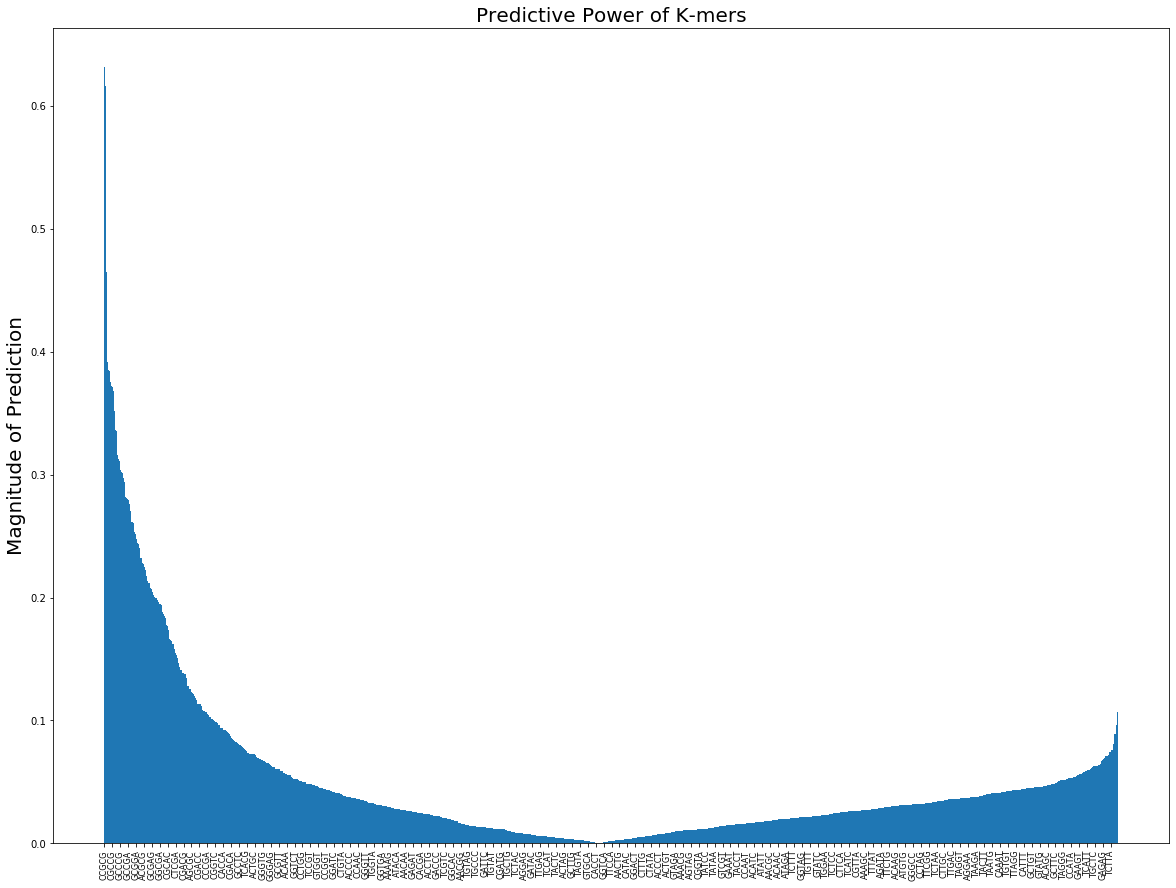

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.bar(range(len(list(sorted_merge_df['Kmer']))), 
        list(sorted_merge_df['PredictPower']), align = 'center', width = 1)
plt.title('Predictive Power of K-mers', fontsize = 20)
plt.ylabel("Magnitude of Prediction", fontsize = 20)
plt.xticks(rotation = 90)
plt.xticks(list(range(len(list(sorted_merge_df['Kmer']))))[0::8], 
           list(sorted_merge_df['Kmer'])[0::8], fontsize = 8)
plt.show()

The y-axis of the barplot shows the amplitude of the deviation from 1 of the Odds ratios for each K-mer. The large is the deviation of the Odds ratio from 1, the more frequent is the K-mer in either depleted Neanderthal ancestry regions (left tail of the barplot) or introgressed Neanderthal regions (right tail of the barplot). Here I display every 8-th bar label for better visibility. Nevertheless, one can notice that the left tail of the barplot (K-mers frequent in the regions of depleted Neanderthal ancestry) contains mostly GC-rich K-mers. This implies that the regions of depleted Neanderthal ancestry are more likely to be the Human Gene regions as they are known to have higher GC-content compared to the average genome-wide level.

Out of curiosity, let us check what K-mers are most frequent in the ANGPTL3 gene which had a very low GC-content, i.e. was extremely AT-rich. Fist we read it sequence and split it inro K-mers, then we use the class **Counter** to count K-mers in the sequence which was previously converted to a list of K-mers.

In [70]:
%%bash
cd /home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/
samtools faidx hg19.fa.gz chr1:63063158-63071976 | sed '1d' | tr -d '\n' > ANGPTL3_sequence.txt

In [75]:
import os
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/')
with open('ANGPTL3_sequence.txt','r') as fin:
    ANGPTL3_seq = fin.read().upper()

In [78]:
import pandas as pd
ANGPTL3_counts = dict(Counter(getKmers(ANGPTL3_seq, 5)))
kmers = list(ANGPTL3_counts.keys())
counts = list(ANGPTL3_counts.values())
ANGPTL3_df = pd.DataFrame({'Kmer': kmers, 'Count': counts})
ANGPTL3_df = ANGPTL3_df.sort_values(['Count'], ascending = False)
ANGPTL3_df.head(10)

Kmer  Count
57   AAAAT     83
67   TAAAA     79
194  TTAAA     78
68   AAAAA     74
318  AAATA     73
54   AAATT     59
366  TTTAA     59
348  AATAA     57
396  ATTAT     53
93   TTTTA     52

In [79]:
ANGPTL3_df.tail(10)

Kmer  Count
784  ACACG      1
160  CGATG      1
777  ACGGA      1
169  TAGCC      1
46   CGTTG      1
44   CACGT      1
766  GGGGT      1
765  TGGGG      1
415  CGGTT      1
882  CCCCC      1

As we can see, the ANGPTL3 gene is indeed very AT-rich. The most frequent K-mers seems to contain only A and T nucleotides. In contrast, it seems that GC-rich K-mers are not very common in the ANGPTL3 gene.


#### CountVectorizer and Random Forest Classification  <a class="anchor" id="CountVectorizer-and-Random-Forest-Classification"></a>

Now we are going to use the Bag Of Words model, i.e. K-mer counting, for training a simple Random Forest classifier that should learn to classify sequences to belong to Neanderthal introgressed or depleted regions. As previously, we start with reading the two fasta-files with the introgressed and depleted sequences into the memory.

In [1]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 8800
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    #my_intr_reverse_compliment_seq = str(Seq(my_intr_seq).reverse_complement())
    #intr_seqs.append(my_intr_reverse_compliment_seq)
    
    depl_seqs.append(my_depl_seq)
    #my_depl_reverse_compliment_seq = str(Seq(my_depl_seq).reverse_complement())
    #depl_seqs.append(my_depl_reverse_compliment_seq)
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


Now we will use the **getKmers** function that splits the sequences into K-mers. We apply this function to each sequence and concatenate the K-mers on the fly in space-delimited manner in order to build **sentences** out of sequences. K-mers are the words in those sentences.

In [2]:
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

In [3]:
kmer = 5
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]

In [4]:
intr_texts[0][0:155]

'AATGA ATGAC TGACA GACAT ACATT CATTA ATTAC TTACT TACTA ACTAT CTATG TATGA ATGAC TGACA GACAA ACAAT CAATT AATTT ATTTG TTTGC TTGCT TGCTT GCTTG CTTGA TTGAG TGAGA'

In [5]:
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

In [6]:
depl_texts[0][0:155]

'CTGCC TGCCA GCCAT CCATT CATTG ATTGC TTGCC TGCCT GCCTC CCTCT CTCTC TCTCC CTCCA TCCAC CCACA CACAC ACACA CACAA ACAAA CAAAT AAATA AATAC ATACA TACAC ACACA CACAT'

Thus we have built two lists (intr_texts and depl_texts) of sentences, one for introgressed sequences, the other one is for depleted sequences. One can say that e.g. intr_texts is a text with many sentences, those sentences consist of K-mers as words or tokens. The words are all of the same length and are space-delimited in each sentence. We are goint to merge the two texts into a single big list / text of sentences, and create a list of labels for each sentence where 1 corresponds to sentences coming from Neanderthal introgressed texts and 0 corresponds to sequences coming from Neanderthal depleted texts.

In [7]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

147468

In [8]:
import numpy as np
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

147468


Now we are going to apply a simple aka one-hot-encoding transfrom to each word in the vocabulary of size 4^kmer in order to convert the words / K-mers in each sentence into a numeric / computer-friendly form. Essentially we are building a matrix of counts for each word / K-mer where columns are the K-mers and rows are the sentences / sequences split into K-mers. The elements of the matrix are how many times each word / K-ner is found at each sentence / sequence. This can be done via scikitlearn class **CountVectorizer**. We will now have a look at how the transformed data looks like as well the dimensions of the transformed data matrix:

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

cv = CountVectorizer()
X = cv.fit_transform(merge_texts)

#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(merge_texts)
#encoded_docs = tokenizer.texts_to_sequences(merge_texts)
#max_length = max([len(s.split()) for s in merge_texts])
#X = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

print(X.toarray())
print('\n')
print(X.shape)

[[42 10 13 ... 17 19 29]
 [61 27 26 ... 12  8 16]
 [61 27 26 ... 12  8 16]
 ...
 [33 16 17 ... 36 20 50]
 [53  4 13 ... 10 14 15]
 [59 18 26 ... 22 15 28]]


(147468, 1024)


Now we have built the input X matrix and the list of labels to be fed into the classifier. Next, per standard, we are going to randomly split the data set X into training, X_train, and testing, X_test, sub-sets. The same random split will be simultaneously done for the labels.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), labels, test_size=0.20, random_state=42)

In [12]:
print(X_train.shape)
print(X_test.shape)

(117974, 1024)
(29494, 1024)


Now we will train the Random Foresr classifier and evaluate it on the test data set.

In [13]:
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#classifier = GaussianNB()
#classifier = LinearSVC()
#classifier = LogisticRegression()
classifier = RandomForestClassifier(n_estimators = 500)
#classifier = XGBClassifier(n_estimators = 100)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
y_pred = classifier.predict(X_test)

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print('\n')
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted    0.0    1.0
Actual                 
0.0        14857     56
1.0         4521  10060


accuracy = 0.845 
precision = 0.879 
recall = 0.845 
f1 = 0.841


In [19]:
import os
import pickle
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')
pickle.dump(classifier, open('RF_model_Neand_Intr_vs_Depl.sav', 'wb'))

Let us now read the weights of the Random Forest classifier and display the Confusion Matrix and a final evaluation accuracy calculated on the test data set.

In [13]:
import os
import pickle
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

classifier = pickle.load(open('RF_model_Neand_Intr_vs_Depl.sav', 'rb'))
predicted_labels = classifier.predict(X_test)

In [16]:
predicted_labels

array([1., 0., 1., ..., 0., 1., 0.])

Confusion matrix:
 [[14857    56]
 [ 4521 10060]]


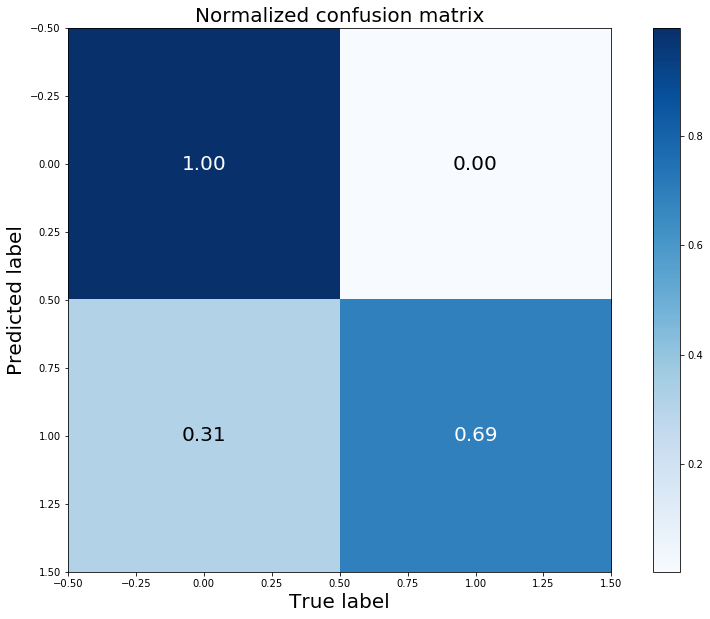

In [17]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15,10))

cm = confusion_matrix(y_test, [np.round(i) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

From the Confusion Matrix for Random Forest Classifier (above) it becomes clear that the model had a very high accuracy when predicting segments of depleted Neanderthal ancestry, however performed very poorly (worse than the neural network) on classifying introgressed regions.

In [20]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, predicted_labels)
print("Accuracy: %.2f%%" % (score*100))

Accuracy: 84.48%


In [21]:
classifier.feature_importances_

array([0.00213581, 0.00140425, 0.00127744, ..., 0.00131052, 0.0013646 ,
       0.00160065])

Surprisingly, we achieve very high accuracy with the simple Random Forest classifier using the Bag Of Words (basically K-mer frequencies) NLP model. We can display feature importances which any Machine Learning algorithm delivers, including the Random Forest:

In [16]:
names = cv.get_feature_names()
names = [i.upper() for i in names]
feature_import = sorted(zip(map(lambda x: str(round(x, 5)), classifier.feature_importances_), names), 
                        reverse = True)
feature_import[0:20]

[('0.00214', 'AAAAA'),
 ('0.00169', 'CAAAA'),
 ('0.00162', 'CATTT'),
 ('0.0016', 'TTTTT'),
 ('0.00155', 'ATGCA'),
 ('0.00147', 'TGTGT'),
 ('0.00147', 'CCTTC'),
 ('0.00147', 'AAATG'),
 ('0.00146', 'TTCTG'),
 ('0.00146', 'ACACA'),
 ('0.00145', 'CTTCT'),
 ('0.00144', 'GCTTT'),
 ('0.00143', 'AAAAT'),
 ('0.00142', 'ACAAA'),
 ('0.00141', 'GTGTG'),
 ('0.00141', 'CCAGC'),
 ('0.00141', 'ATATA'),
 ('0.00141', 'AATGA'),
 ('0.0014', 'AAAAC'),
 ('0.00138', 'TCTCT')]

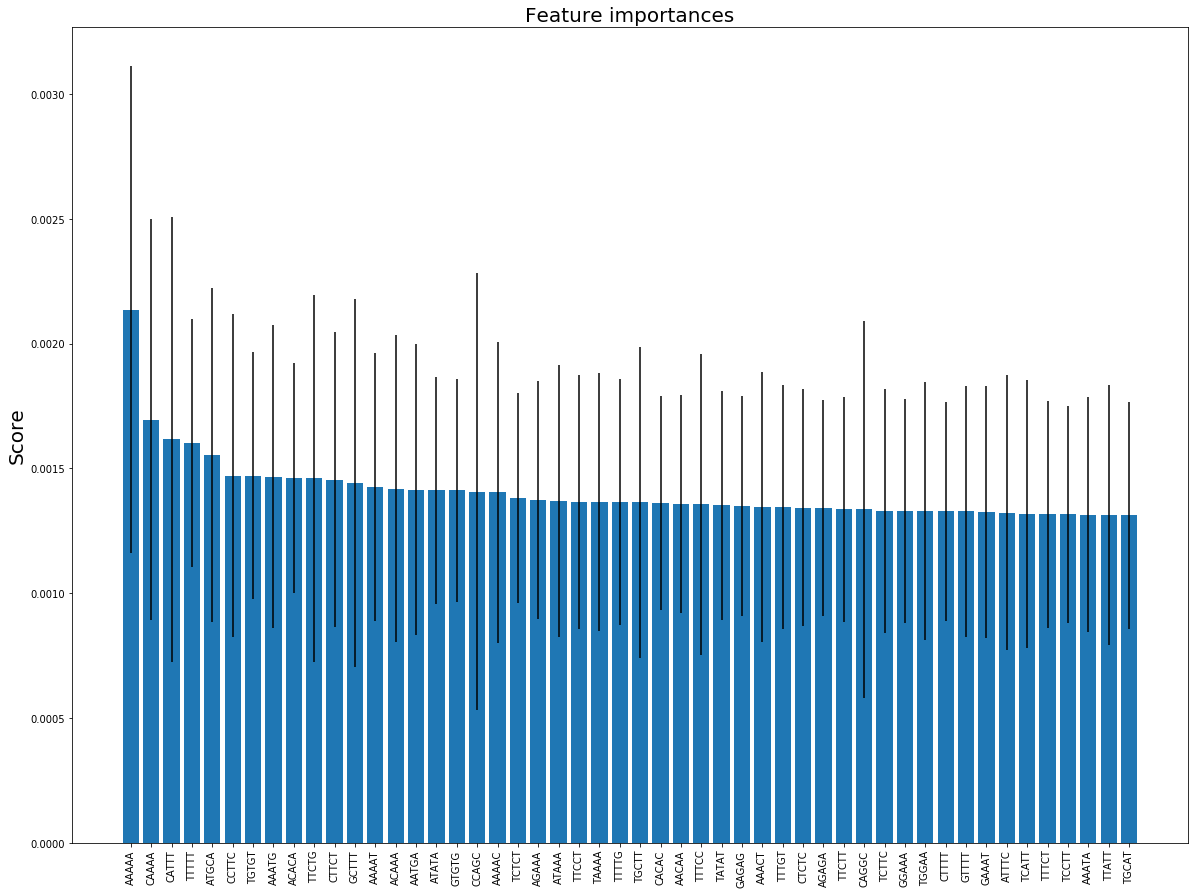

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))

importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.title("Feature importances", fontsize = 20)
plt.bar(range(X_train.shape[1])[0:50], importances[indices][0:50], 
        yerr = std[indices][0:50], align = "center")
plt.xticks(rotation = 90)
plt.ylabel('Score', fontsize = 20)
plt.xticks(range(X_train.shape[1])[0:50], np.array(names)[indices][0:50])
plt.show()

We can see that the most common AT-rich K-mers turn out to be most informative for the Random Forest classifier within the Bag Of Words NLP model. Therefore, despite those AT-rich K-mers are most frequent in both Neanderthal introgressed and depleted sequences, small differences between the two types of sequences make the Random Forest accurately classify each given sequence. Let us take the ANGPTL3 sequence and make a prediction for that sequence:

In [1]:
import os
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/')
with open('ANGPTL3_sequence.txt','r') as fin:
    ANGPTL3_seq = fin.read().upper()

In [2]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 8800
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    #my_intr_reverse_compliment_seq = str(Seq(my_intr_seq).reverse_complement())
    #intr_seqs.append(my_intr_reverse_compliment_seq)
    
    depl_seqs.append(my_depl_seq)
    #my_depl_reverse_compliment_seq = str(Seq(my_depl_seq).reverse_complement())
    #depl_seqs.append(my_depl_reverse_compliment_seq)
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [5]:
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

classifier = pickle.load(open('RF_model_Neand_Intr_vs_Depl.sav', 'rb'))
cv = CountVectorizer()
merge_texts = intr_texts + depl_texts
merge_texts.append(' '.join(getKmers(ANGPTL3_seq[0:cutoff], kmer)))
X_ANGPTL3 = cv.fit_transform(merge_texts)
int(classifier.predict(X_ANGPTL3[-1,:].toarray()))

0

In [6]:
classifier.predict_proba(X_ANGPTL3[-1,:].toarray())

array([[0.658, 0.342]])

We can see that the Random Forest classifier gives 66% probability that this gene was not inherited from Neanderthals, 0 predicted label means the ANGPTL3 sequence most likely falls within the regions of depleted Neanderthal ancestry. This is not a high probability, and we know from the confusion matrix that when we predict 0, it can be actually 1 in almost 14% of cases, so the prediction for ANGPTL3 might not be accurate enough. So we can not make a confident prediction for ANGPTL3 but perhaps there will be other genes that can be predicted to be inherited from Neanderthal. We can actually make a loop and use the trained Random Forest classifier model for making prediction for each gene.

#### Detecting Genes Inherited from Neanderthals  <a class="anchor" id="Detecting-Genes-Inherited-from-Neanderthals"></a>

Now we will use the trained Random Forest classifier in order to make predictions for all genes in the hg19 human reference genome. For this purpose we will have to 1) select quite long genes with length > cut, 2) merge the gene sentences together with the introgressed and depleted sentences in order to process them all together through the **CountVectorizer** so that the sentences for prediction are prepared in identical way as the data used for training the Random Forest classifier. As usually, we will start with reading the introgressed and depleted sequences, split them into K-mers and building sentences / texts.

In [1]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 8800
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    depl_seqs.append(my_depl_seq)
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [2]:
print(len(intr_texts))
print(len(depl_texts))

73734
73734


Now we will do the same for the gene sequences, i.e. read them, split into K-mers and build sentences / texts:

In [1]:
import os
from Bio import SeqIO

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/Genes/')

gene_file = 'hg19_gene_clean.fa'

a = 0
gene_seqs = []
gene_ids = []
for gene in SeqIO.parse(gene_file, 'fasta'):
    cut = 8800
    if len(str(gene.seq)) < cut:
        continue
    s_gene = str(gene.seq)[0:cut]
    if s_gene.count('A')>0 and s_gene.count('C')>0 and s_gene.count('G')>0 and s_gene.count('T')>0:
        gene_seqs.append(s_gene)
        gene_ids.append(str(gene.id))
    a = a + 1
    if a%10000 == 0:
        print('Finished ' + str(a) + ' genes')

def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
gene_texts = [' '.join(getKmers(i, kmer)) for i in gene_seqs]

Finished 10000 genes
Finished 20000 genes


In [2]:
print(len(gene_texts))
print(len(gene_ids))

21503
21503


In [3]:
gene_ids[0:10]

['chr1:14362-29370',
 'chr1:700245-714068',
 'chr1:762971-778984',
 'chr1:762971-794826',
 'chr1:763178-794826',
 'chr1:861121-879961',
 'chr1:879583-894679',
 'chr1:1017198-1051736',
 'chr1:1152288-1167447',
 'chr1:1189292-1209234']

In [4]:
import os
import pickle
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

with open('gene_ids.txt', 'w') as f:
    for item in gene_ids:
        f.write("%s\n" % item)

In [6]:
merge_texts = intr_texts + gene_texts

In [7]:
import os
import pickle
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

with open('merge_texts.txt', 'wb') as fp:
    pickle.dump(merge_texts, fp)

Here we need to restsrt the Kernel in order to release memory, and then read the merge_texts list into the memory again:

In [1]:
import os
import pickle
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

with open ('merge_texts.txt', 'rb') as fp:
    merge_texts = pickle.load(fp)

In [5]:
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

classifier = pickle.load(open('RF_model_Neand_Intr_vs_Depl.sav', 'rb'))
cv = CountVectorizer()
X_gene = cv.fit_transform(gene_texts)
gene_predictions = classifier.predict(X_gene.toarray())
gene_predictions_prob = classifier.predict_proba(X_gene.toarray())
#gene_predictions = classifier.predict(X_gene[-X_gene.shape[0]:21503,:].toarray())
#gene_predictions_prob = classifier.predict_proba(X_gene[-X_gene.shape[0]:21503,:].toarray())

In [6]:
len(gene_predictions)

21503

In [7]:
X_gene.shape

(21503, 1024)

In [8]:
gene_predictions

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
import numpy as np
print(np.sum(gene_predictions==0))
print(np.sum(gene_predictions==1))

21026
477


In [9]:
gene_predictions_prob

array([[0.674, 0.326],
       [0.694, 0.306],
       [0.592, 0.408],
       ...,
       [0.574, 0.426],
       [0.574, 0.426],
       [0.584, 0.416]])

In [10]:
gene_predictions_prob_0 = [i[0] for i in gene_predictions_prob]

In [11]:
gene_predictions_prob_1 = [i[1] for i in gene_predictions_prob]

In [23]:
import os
os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')
gene_ids = []
gene_symbol = []
with open('gene_ids.txt','r') as fin:
    for line in fin:
        line = line.split('\t')
        gene_ids.append(line[0])
        gene_symbol.append(line[1].rstrip())

In [31]:
import pandas as pd
gene_pred_df = pd.DataFrame({'Gene': gene_ids, 'Gene_Symbol': gene_symbol, 'Predict': gene_predictions, 
                             'Prob_0': gene_predictions_prob_0, 'Prob_1': gene_predictions_prob_1})
gene_pred_df = gene_pred_df.sort_values(['Prob_1'], ascending = False)
gene_pred_df.head(30)

Gene   Gene_Symbol  Predict  Prob_0  Prob_1
12554     chr3:19988572-20026667         RAB5A      1.0   0.032   0.968
16186        chr6:961241-1101567     LINC01622      1.0   0.046   0.954
2966       chr11:4665156-4676716        OR51E1      1.0   0.066   0.934
15270     chr5:57878871-58155222         RAB3C      1.0   0.094   0.906
10923   chr2:179694484-179914786       CCDC141      1.0   0.094   0.906
6014   chr14:101355986-101465450          MEG8      1.0   0.100   0.900
16252       chr6:8435856-8785678  LOC100506207      1.0   0.136   0.864
2440     chr10:87359312-88126250         GRID1      1.0   0.136   0.864
16251       chr6:8435856-8712526  LOC100506207      1.0   0.136   0.864
382       chr1:33231235-33240571      KIAA1522      1.0   0.154   0.846
12301    chr22:32870707-32894818         FBXO7      1.0   0.158   0.842
19128     chr8:17154306-17271040         MTMR7      1.0   0.168   0.832
4853     chr12:96043031-96067770       PGAM1P5      1.0   0.168   0.832
12597     chr3:29322803-30032809         RBMS3      1.0   0.174   0.826
12598     chr3:29322803-30051886         RBMS3      1.0   0.174   0.826
16047   chr5:169064251-169510386         DOCK2      1.0   0.176   0.824
13843   chr3:191857182-192445388         FGF12      1.0   0.178   0.822
13842   chr3:191857182-192126838         FGF12      1.0   0.178   0.822
16878     chr6:80340822-80413387      SH3BGRL2      1.0   0.180   0.820
3739     chr11:95523625-95565857         CEP57      1.0   0.182   0.818
10325     chr2:86730553-86790620         CHMP3      1.0   0.186   0.814
10326     chr2:86730553-86948245  RNF103-CHMP3      1.0   0.186   0.814
2238     chr10:61786056-61900774          ANK3      1.0   0.192   0.808
2239     chr10:61786056-62149742          ANK3      1.0   0.192   0.808
2240     chr10:61786056-62332714          ANK3      1.0   0.192   0.808
2241     chr10:61786056-62493284          ANK3      1.0   0.192   0.808
3761   chr11:102391239-102401484          MMP7      1.0   0.194   0.806
13506   chr3:147795946-147805816     LINC02032      1.0   0.200   0.800
10404     chr2:99235569-99279936        MGAT4A      1.0   0.214   0.786
10405     chr2:99235569-99347589        MGAT4A      1.0   0.214   0.786

In [30]:
gene_pred_df[gene_pred_df['Prob_1']>0.8].shape

(27, 5)

In [32]:
gene_pred_df[gene_pred_df['Gene_Symbol']=="ANGPTL3"]

Gene Gene_Symbol  Predict  Prob_0  Prob_1
634  chr1:63063158-63071976     ANGPTL3      0.0   0.658   0.342

In [33]:
gene_pred_df.tail(30)

Gene   Gene_Symbol  Predict  Prob_0  Prob_1
9274         chr19:42901280-42912604  LOC101930071      0.0   0.876   0.124
18              chr1:1413495-1431584        ATAD3B      0.0   0.876   0.124
18318         chr7:66147078-66276448       RABGEF1      0.0   0.876   0.124
9412         chr19:48958964-48969367        KCNJ14      0.0   0.878   0.122
12785         chr3:47537130-47555199          ELP6      0.0   0.880   0.120
4110           chr12:6420099-6437672       PLEKHG6      0.0   0.880   0.120
1149        chr1:155204239-155214653           GBA      0.0   0.884   0.116
1744        chr1:235330210-235491532        ARID4B      0.0   0.884   0.116
1743        chr1:235330210-235490802        ARID4B      0.0   0.884   0.116
13              chr1:1288069-1298921         MXRA8      0.0   0.884   0.116
3471         chr11:64948686-64979477         CAPN1      0.0   0.886   0.114
5137       chr12:123259056-123311927        CCDC62      0.0   0.886   0.114
17953           chr7:5965777-6010314       RSPH10B      0.0   0.888   0.112
19927       chr8:145597704-145618453         ADCK5      0.0   0.888   0.112
6054       chr14:105956192-105965585      C14orf80      0.0   0.888   0.112
17952           chr7:5965777-6010314       RSPH10B      0.0   0.888   0.112
8047         chr17:73720776-73753899         ITGB4      0.0   0.890   0.110
19920       chr8:145106167-145115606         OPLAH      0.0   0.892   0.108
11708        chr20:32319566-32380075        ZNF341      0.0   0.894   0.106
8634             chr19:496490-505343       MADCAM1      0.0   0.898   0.102
1759        chr1:236558716-236648008       EDARADD      0.0   0.904   0.096
20487       chr9:131857073-131873077          CRAT      0.0   0.906   0.094
6935         chr16:66638228-66647795         CMTM3      0.0   0.906   0.094
17725  chr6_mcf_hap5:3144866-3154459          LSM2      0.0   0.908   0.092
17803  chr6_qbl_hap6:3058814-3068398          LSM2      0.0   0.908   0.092
17608  chr6_dbb_hap3:3050751-3060344          LSM2      0.0   0.910   0.090
6055       chr14:105956520-105965585      C14orf80      0.0   0.910   0.090
17513  chr6_cox_hap2:3274737-3284332          LSM2      0.0   0.910   0.090
16482         chr6:31765169-31774761          LSM2      0.0   0.910   0.090
19906       chr8:144873090-144897549         SCRIB      0.0   0.916   0.084

In [35]:
gene_pred_df.to_csv('Neanderthal_Genes.txt', header=True, index = False, sep = "\t")

### Multilayer Perceptron for Neanderthal Introgressed vs. Depleted Sequence Classification  <a class="anchor" id="Multilayer-Perceptron-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification"></a>

Here we will still use the Bag of Words model but implement a Multilayer Perceptron model for classification of sequences coming from Neanderthal introgressed vs. depleted Neanderthal ancestry regions. We again start with reading the sequences from the two fasta-files (introgressed and depleted regions), split them into words / K-mers and build sentences out of them.

In [1]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 10000
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    #my_intr_reverse_compliment_seq = str(Seq(my_intr_seq).reverse_complement())
    #intr_seqs.append(my_intr_reverse_compliment_seq)
    
    depl_seqs.append(my_depl_seq)
    #my_depl_reverse_compliment_seq = str(Seq(my_depl_seq).reverse_complement())
    #depl_seqs.append(my_depl_reverse_compliment_seq)
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


As we did previously, we will use **CountVectorizer** in order to convert words / K-mers into numeric representation, the elements of the obtained matrix X show how often each word / K-mer occurs in each sentence / sequence.

In [2]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

147468

In [3]:
import numpy as np
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

147468


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

cv = CountVectorizer()
X = cv.fit_transform(merge_texts)

#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(merge_texts)
#X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')

#encoded_docs = tokenizer.texts_to_sequences(merge_texts)
#max_length = max([len(s.split()) for s in merge_texts])
#X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

X = np.int32(X.toarray())

print(X)
print('\n')
print(X.shape)

[[47 11 15 ... 29 25 49]
 [61 27 27 ... 13 10 16]
 [61 27 27 ... 13 10 16]
 ...
 [43 23 22 ... 40 24 52]
 [54  4 13 ... 10 14 15]
 [63 20 27 ... 27 17 34]]


(147468, 1024)


Again, we split the data set into training, X_train, and testing, X_test, subsets:

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(117974, 1024)
(29494, 1024)


Now the data is prepared to be fed into the Multilayer Perceptron model for classification of sequences coming from Neandertal introgressed vs. depleted Neanderthal ancestry regions.

In [44]:
from keras.models import Sequential
from keras.regularizers import l2, l1
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation

model = Sequential()
model.add(Dense(3000, input_shape=(X.shape[1],), activation = 'sigmoid', 
                kernel_regularizer = l1(0.00001)))
#model.add(Dense(1000, activation = 'sigmoid'))
#model.add(Dense(100, activation = 'sigmoid'))
#model.add(Dense(10, activation = 'sigmoid'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 200
lrate = 0.0001
#decay = lrate / epochs
#sgd = SGD(lr = lrate, momentum = 0.99, nesterov = True)
sgd = SGD(lr = lrate, momentum = 0.9, nesterov = False)
#sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = lrate), metrics = ['binary_accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['binary_accuracy'])
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_binary_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'max')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 3000)              3075000   
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 3001      
Total params: 3,078,001
Trainable params: 3,078,001
Non-trainable params: 0
_________________________________________________________________


In [46]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 94379 samples, validate on 23595 samples
Epoch 1/200
94379/94379 [==============================] - 115s 1ms/step - loss: 1.2779 - binary_accuracy: 0.5527 - val_loss: 1.2716 - val_binary_accuracy: 0.5641

Epoch 00001: val_binary_accuracy improved from -inf to 0.56414, saving model to weights.best.hdf5
Epoch 2/200
94379/94379 [==============================] - 116s 1ms/step - loss: 1.2655 - binary_accuracy: 0.5768 - val_loss: 1.2732 - val_binary_accuracy: 0.5548

Epoch 00002: val_binary_accuracy did not improve from 0.56414
Epoch 3/200
94379/94379 [==============================] - 118s 1ms/step - loss: 1.2584 - binary_accuracy: 0.5889 - val_loss: 1.2709 - val_binary_accuracy: 0.5630

Epoch 00003: val_binary_accuracy did not improve from 0.56414
Epoch 4/200
94379/94379 [==============================] - 117s 1ms/step - loss: 1.2533 - binary_accuracy: 0.5975 - val_loss: 1.2838 - val_binary_accuracy: 0.5494

Epoch 00004: val_binary_accuracy did not improve from 0.56414
Epoch 5/20


Epoch 00034: val_binary_accuracy did not improve from 0.67362
Epoch 35/200
94379/94379 [==============================] - 112s 1ms/step - loss: 1.0720 - binary_accuracy: 0.7689 - val_loss: 1.1541 - val_binary_accuracy: 0.6855

Epoch 00035: val_binary_accuracy improved from 0.67362 to 0.68553, saving model to weights.best.hdf5
Epoch 36/200
94379/94379 [==============================] - 115s 1ms/step - loss: 1.0611 - binary_accuracy: 0.7787 - val_loss: 1.1516 - val_binary_accuracy: 0.6812

Epoch 00036: val_binary_accuracy did not improve from 0.68553
Epoch 37/200
94379/94379 [==============================] - 113s 1ms/step - loss: 1.0545 - binary_accuracy: 0.7840 - val_loss: 1.1474 - val_binary_accuracy: 0.6885

Epoch 00037: val_binary_accuracy improved from 0.68553 to 0.68849, saving model to weights.best.hdf5
Epoch 38/200
94379/94379 [==============================] - 115s 1ms/step - loss: 1.0481 - binary_accuracy: 0.7855 - val_loss: 1.1465 - val_binary_accuracy: 0.6804

Epoch 00038: 

94379/94379 [==============================] - 113s 1ms/step - loss: 0.6418 - binary_accuracy: 0.9870 - val_loss: 1.0382 - val_binary_accuracy: 0.7423

Epoch 00103: val_binary_accuracy did not improve from 0.80233
Epoch 104/200
94379/94379 [==============================] - 114s 1ms/step - loss: 0.6342 - binary_accuracy: 0.9901 - val_loss: 1.0129 - val_binary_accuracy: 0.7584

Epoch 00104: val_binary_accuracy did not improve from 0.80233
Epoch 105/200
94379/94379 [==============================] - 114s 1ms/step - loss: 0.6329 - binary_accuracy: 0.9900 - val_loss: 1.0402 - val_binary_accuracy: 0.7402

Epoch 00105: val_binary_accuracy did not improve from 0.80233
Epoch 106/200
94379/94379 [==============================] - 111s 1ms/step - loss: 0.6279 - binary_accuracy: 0.9914 - val_loss: 0.9977 - val_binary_accuracy: 0.7734

Epoch 00106: val_binary_accuracy did not improve from 0.80233
Epoch 107/200
94379/94379 [==============================] - 112s 1ms/step - loss: 0.6263 - binary_acc

94379/94379 [==============================] - 113s 1ms/step - loss: 0.5054 - binary_accuracy: 1.0000 - val_loss: 0.9424 - val_binary_accuracy: 0.8003

Epoch 00174: val_binary_accuracy did not improve from 0.81945
Epoch 175/200
94379/94379 [==============================] - 116s 1ms/step - loss: 0.5042 - binary_accuracy: 1.0000 - val_loss: 0.9429 - val_binary_accuracy: 0.8157

Epoch 00175: val_binary_accuracy did not improve from 0.81945
Epoch 176/200
94379/94379 [==============================] - 112s 1ms/step - loss: 0.5034 - binary_accuracy: 1.0000 - val_loss: 0.9420 - val_binary_accuracy: 0.8038

Epoch 00176: val_binary_accuracy did not improve from 0.81945
Epoch 177/200
94379/94379 [==============================] - 114s 1ms/step - loss: 0.5022 - binary_accuracy: 1.0000 - val_loss: 0.9407 - val_binary_accuracy: 0.8126

Epoch 00177: val_binary_accuracy did not improve from 0.81945
Epoch 178/200
94379/94379 [==============================] - 114s 1ms/step - loss: 0.5011 - binary_acc

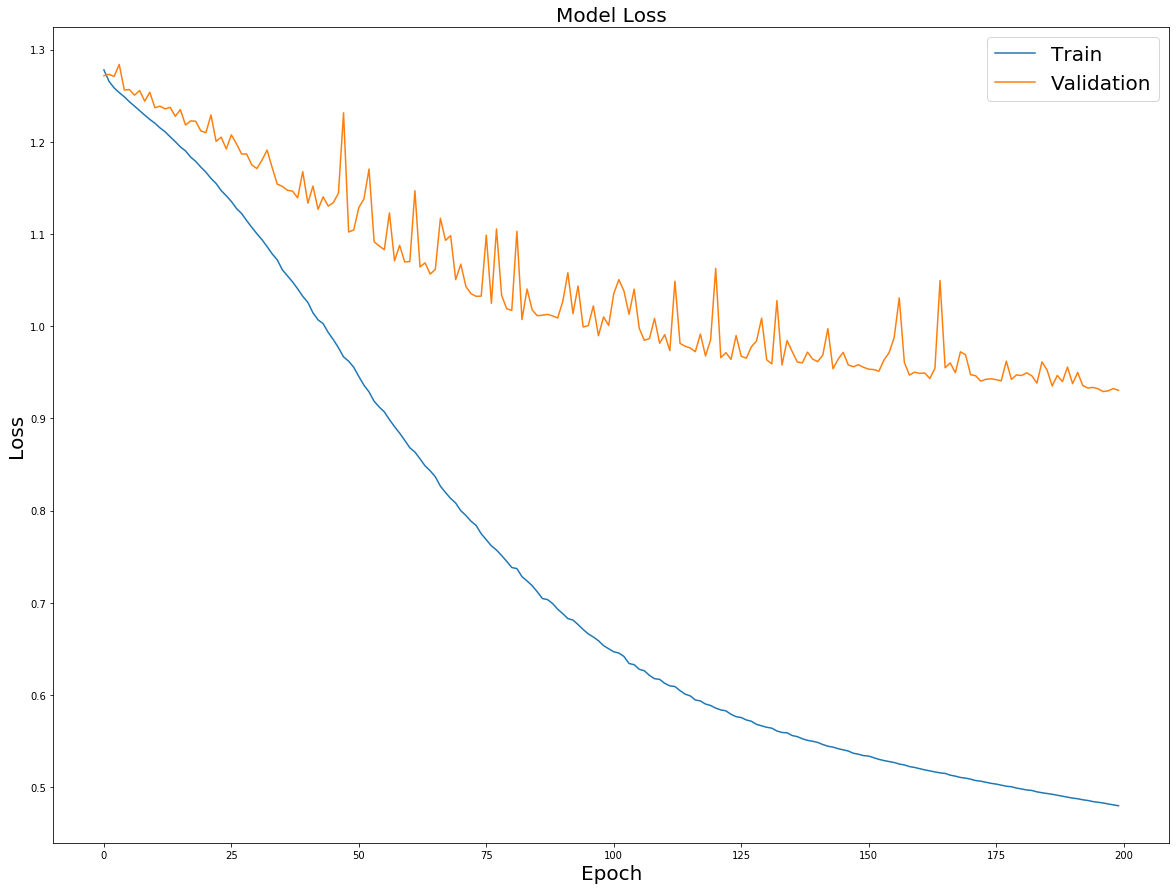

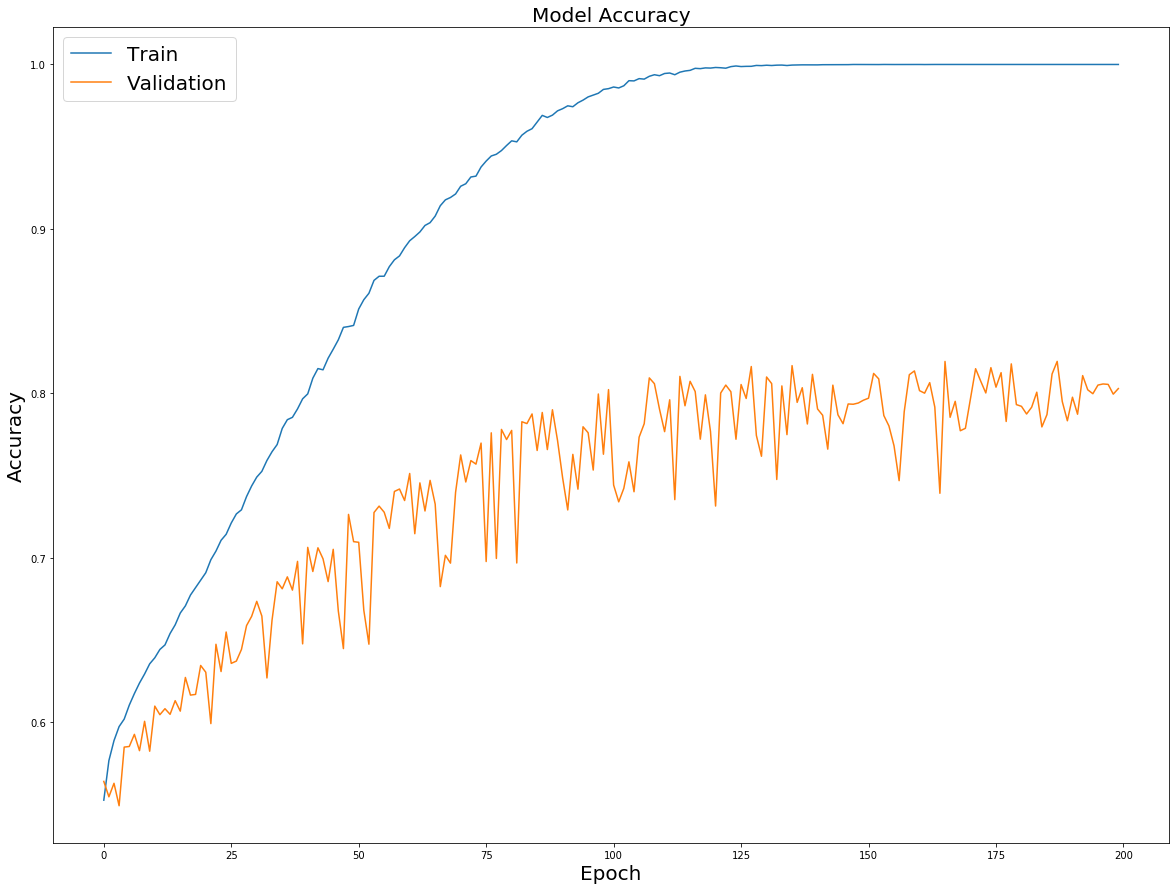

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

In [48]:
model.load_weights("weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])

Confusion matrix:
 [[13232  1681]
 [ 3580 11001]]


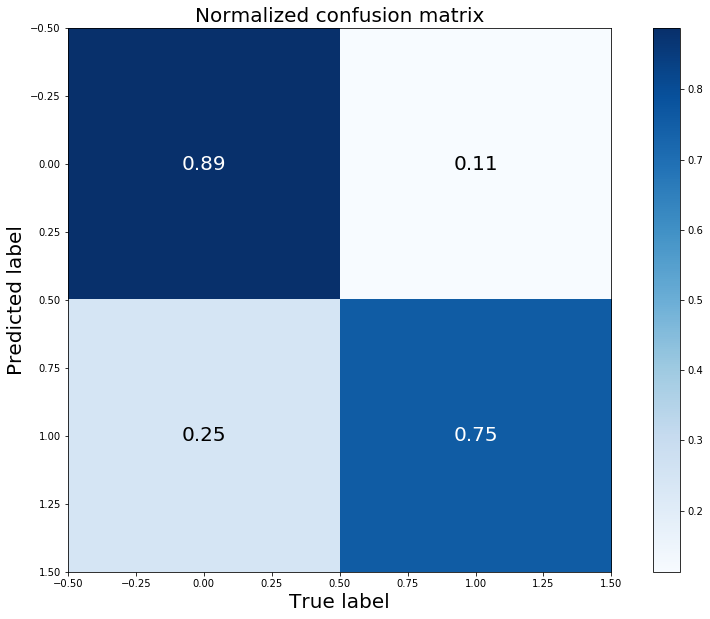

In [49]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [50]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.16%


We reached quite a good accuracy of classification, however still worse than the Random Forest model on the same Bag Of Words (frequencies of K-mers) data set. Let us see whether more advanced Word Embeddings models can improve the accuracy of Neanderthal introgressed vs. depleted sequence / sentence / text classification. 

### Multilayer Perceptron + Embedding Layer for Neanderthal Introgressed vs. Depleted Sequence Classification  <a class="anchor" id="Multilayer-Perceptron-+-Embedding-Layer-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification"></a>

Here instead of the Bag of Words model we will implement a Multilayer Perceptron model with an Embedding Layer which is supposed to learn the Word Embeddings, i.e. finding correspondence between words with similar meaning. This is a model where the order of the words will be taken into account for classification of sequences coming from Neanderthal introgressed vs. depleted Neanderthal ancestry regions. We again start with reading the sequences from the two fasta-files (introgressed and depleted regions), split them into words / K-mers and build sentences out of them.

In [1]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 4000
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    depl_seqs.append(my_depl_seq)

    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


Hhere we will use the **Tokenizer** class from Kears in order to convert words / K-mers into integers.

In [2]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

147468

In [3]:
import numpy as np
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

147468


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

#cv = CountVectorizer()
#X = cv.fit_transform(merge_texts)

#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)

#X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

#X = X.toarray()

print(X)
print('\n')
print(X.shape)

Using TensorFlow backend.


[[ 76 633 356 ... 320 548 845]
 [578 167 569 ... 535 613 144]
 [578 167 569 ... 535 613 144]
 ...
 [346 188 516 ... 671  61  25]
 [856 987 997 ... 633 435 648]
 [ 48 409 456 ...  29  55  39]]


(147468, 3996)


Again, we split the data set into training, X_train, and testing, X_test, subsets:

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

In [6]:
print(X_train.shape)
print(y_train[0:10])
print(X_test.shape)
print(y_test[0:10])

(117974, 3996)
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]
(29494, 3996)
[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]


In [7]:
print(max_length)

3996


In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

1025


Now the data is prepared to be fed into the Multilayer Perceptron model for classification of sequences coming from Neandertal introgressed vs. depleted Neanderthal ancestry regions.

In [11]:
from keras.models import Sequential
from keras.regularizers import l2, l1
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, GlobalAveragePooling1D

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_length)) #W_regularizer = l1(0.000001)
#model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu'))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(10, activation = 'sigmoid')) #kernel_regularizer = l1(0.00004)
#model.add(Dropout(0.5))
#model.add(Dense(10, activation = 'sigmoid'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 20
#lrate = 0.0001
#decay = lrate / epochs
#sgd = SGD(lr = lrate, momentum = 0.9, nesterov = False)
#sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = lrate), metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3996, 100)         102500    
_________________________________________________________________
flatten_2 (Flatten)          (None, 399600)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3996010   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 4,098,521
Trainable params: 4,098,521
Non-trainable params: 0
_________________________________________________________________


In [12]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 94379 samples, validate on 23595 samples
Epoch 1/20
94379/94379 [==============================] - 288s 3ms/step - loss: 0.6920 - acc: 0.5306 - val_loss: 0.6900 - val_acc: 0.5848

Epoch 00001: val_acc improved from -inf to 0.58478, saving model to weights.best.hdf5
Epoch 2/20
94379/94379 [==============================] - 301s 3ms/step - loss: 0.6845 - acc: 0.6789 - val_loss: 0.6860 - val_acc: 0.6557

Epoch 00002: val_acc improved from 0.58478 to 0.65569, saving model to weights.best.hdf5
Epoch 3/20
94379/94379 [==============================] - 298s 3ms/step - loss: 0.6746 - acc: 0.7963 - val_loss: 0.6797 - val_acc: 0.6869

Epoch 00003: val_acc improved from 0.65569 to 0.68688, saving model to weights.best.hdf5
Epoch 4/20
94379/94379 [==============================] - 303s 3ms/step - loss: 0.6586 - acc: 0.8511 - val_loss: 0.6695 - val_acc: 0.6896

Epoch 00004: val_acc improved from 0.68688 to 0.68960, saving model to weights.best.hdf5
Epoch 5/20
94379/94379 [=================

In [13]:
model.load_weights("weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

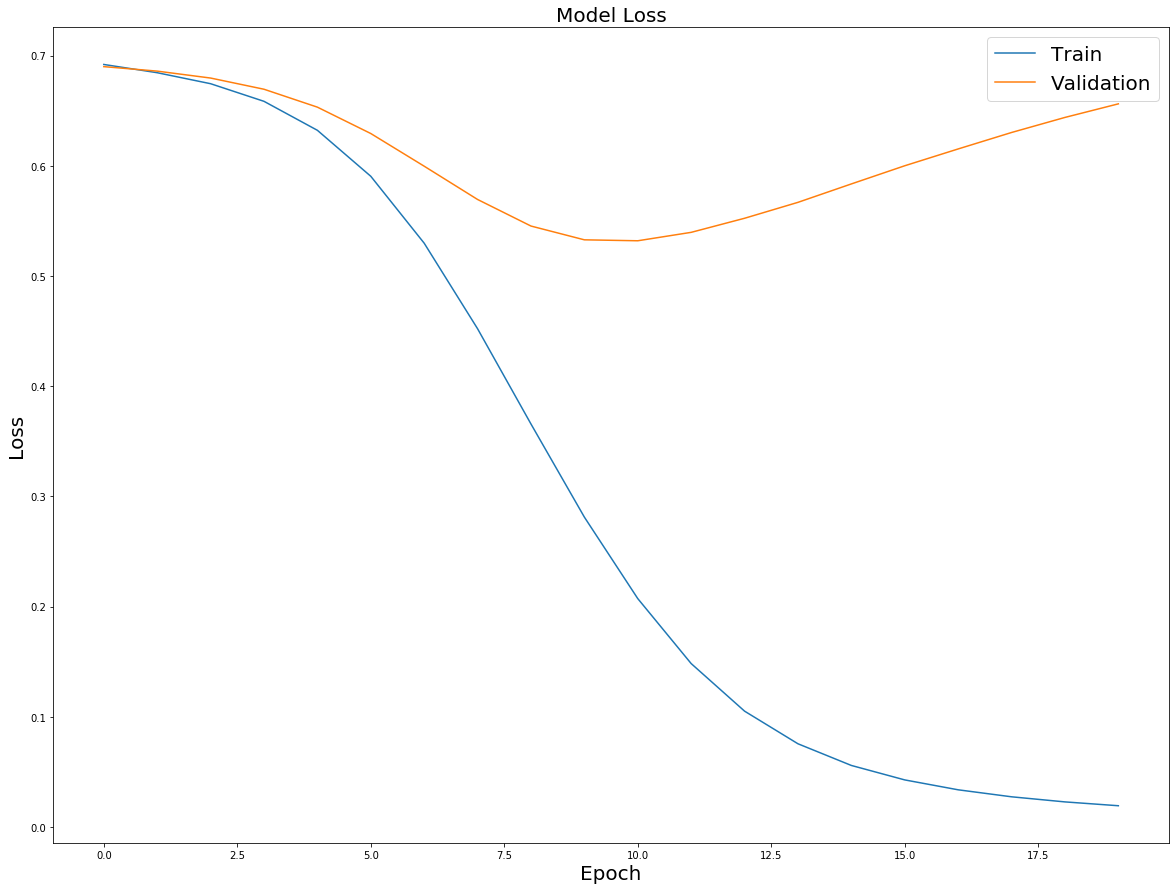

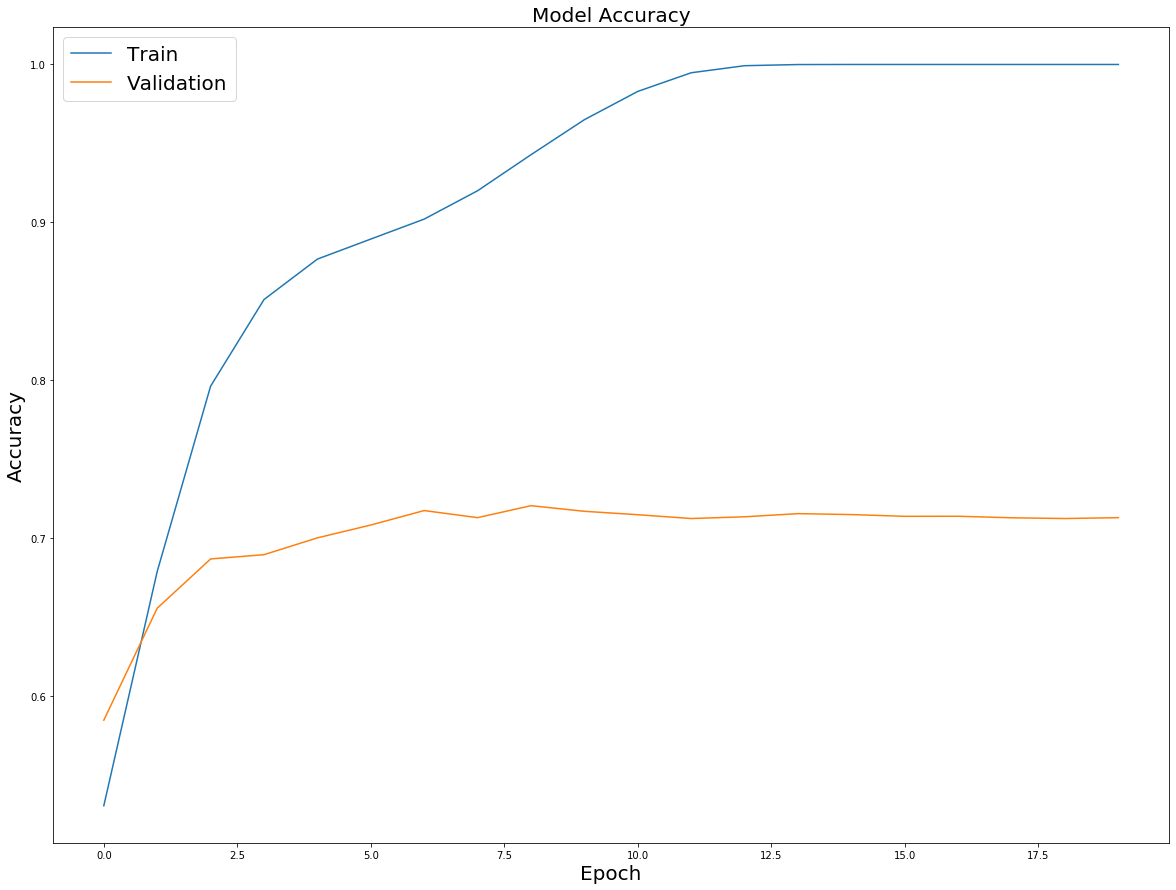

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

We can see that the model clearly overfits but still reaches quite high accuracies on the validation data set. Some regularization with Dropout or L1 / L2 would be good to test here, there is a potential for improvements.

Confusion matrix:
 [[11816  3097]
 [ 4986  9595]]


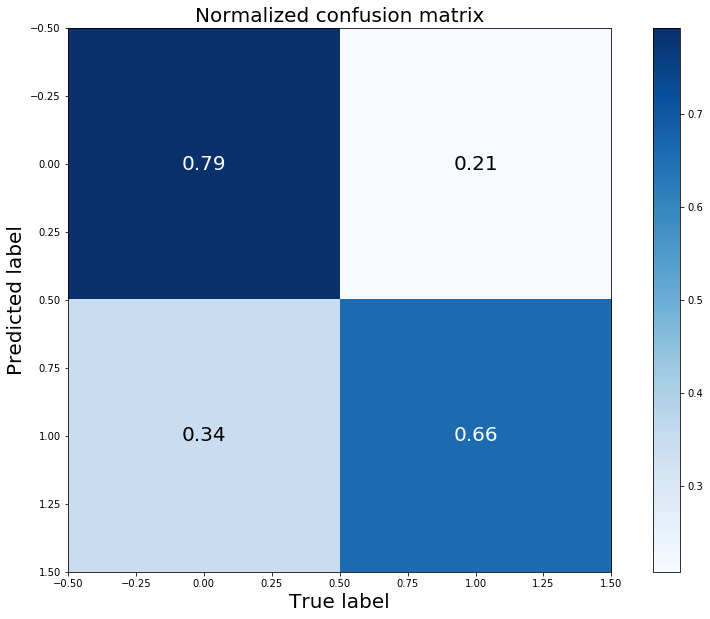

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [17]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 72.59%


We conclude again that the Embedding Layer did not improve the classification accuracy compared to the Bag of Words model. It could not outperform the Random Forest model either.

### AutoML Approach with Autokeras

Apparently the Autokeras in its current form is super memory-hungry. I did not manage to fit even a moderate IMDB data set into my memory. So in theory AutoML is a very cool concept, however currently too imatture to be used for real-world applications.

In [1]:
import numpy as np
import tensorflow as tf
import autokeras as ak

index_offset = 3  # word index offset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words = 20,maxlen = 180,
                                                                        index_from = index_offset)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
x_train[0][0:10]

[1, 14, 2, 8, 2, 2, 7, 4, 2, 2]

In [3]:
x_test[0][0:10]

[1, 13, 16, 2, 8, 2, 6, 2, 7, 14]

In [4]:
x_train = x_train
y_train = y_train.reshape(-1, 1)
x_test = x_test
y_test = y_test.reshape(-1, 1)
y_train.shape

(25000, 1)

In [5]:
word_to_id = tf.keras.datasets.imdb.get_word_index()
word_to_id = {k: (v + index_offset) for k, v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

In [6]:
id_to_word = {value: key for key, value in word_to_id.items()}

In [7]:
x_train = list(map(lambda sentence: ' '.join(id_to_word[i] for i in sentence), x_train))
x_test = list(map(lambda sentence: ' '.join(id_to_word[i] for i in sentence), x_test))
x_train = np.array(x_train, dtype=np.str)
x_test = np.array(x_test, dtype=np.str)

In [8]:
x_train.shape

(25000,)

In [9]:
x_train[0]

'<START> this <UNK> to <UNK> <UNK> of the <UNK> <UNK> of the <UNK> <UNK> <UNK> <UNK> i <UNK> <UNK> this <UNK> <UNK> the <UNK> <UNK> it was <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> the <UNK> <UNK> <UNK> <UNK> with <UNK> <UNK> <UNK> the <UNK> <UNK> <UNK> <UNK> it <UNK> was the <UNK> of the <UNK> <UNK> <UNK> in the <UNK> <UNK> <UNK> <UNK> to <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> that <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> to <UNK> this <UNK> <UNK> for a <UNK> it <UNK> <UNK> <UNK> <UNK> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> it <UNK> <UNK> <UNK> <UNK> in the <UNK> <UNK> a <UNK> <UNK> is <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> i <UNK> <UNK> <UNK> <UNK> <UNK> this is to <UNK> <UNK> <UNK> <UNK> <UNK> a <UNK> of <UNK> <UNK>'

In [10]:
y_train.shape

(25000, 1)

In [11]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [12]:
x_test[0]

'<START> i was <UNK> to <UNK> a <UNK> of this <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> the <UNK> <UNK> <UNK> in <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> a <UNK> <UNK> <UNK> as <UNK> <UNK> <UNK> of the <UNK> <UNK> <UNK> <UNK> and <UNK> <UNK> <UNK> <UNK> <UNK> the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and a <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK> <UNK> <UNK> as the <UNK> <UNK> and in <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> to <UNK> a <UNK> with a <UNK> <UNK> i <UNK> this <UNK> <UNK> <UNK> <UNK> <UNK> a <UNK> <UNK> <UNK> <UNK> to <UNK> <UNK> <UNK> as this <UNK> <UNK> <UNK> <UNK> <UNK> it <UNK> <UNK> <UNK> it'

In [ ]:
clf = ak.TextClassifier(verbose=True)
clf.fit(x_train, y_train, time_limit = 60)
#clf.final_fit(x_train, y_train, x_test, y_test, retrain=True)

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

***** Running training *****
Num examples = %d 25000
Batch size = %d 32
Num steps = %d 3125



Iteration:   0%|          | 1/782 [00:25<5:29:36, 25.32s/it]

In [ ]:
clf.evaluate(x_test, y_test)

Agains same problem. I could not run the TextClassifier either on the benchmark IMDB data or my Neanderthal introgressed vs. depleted texts. Need to wait for better releases of TextClassifier. Still there is not guarantee that AutoML will beat my manual tuning of the Neural Networks, based on the analysis from this blog https://www.pyimagesearch.com/2019/01/07/auto-keras-and-automl-a-getting-started-guide/.

In [8]:
import autokeras as ak
from autokeras import TextClassifier

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [16]:
classifier = TextClassifier(verbose = True)
classifier.fit(X_train, y_train, time_limit = 60 * 60)
classifier.final_fit(X_train, y_train, X_test, y_test, retrain = True)

TypeError: object of type 'int' has no len()

In [15]:
y_train = [int(i) for i in y_train]

In [ ]:
scores = classifier.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

### CNN + Embedding Layer for Neanderthal Introgressed vs. Depleted Sequence Classification  <a class="anchor" id="CNN-+-Embedding-Layer-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification"></a>

Bag of Words is a good model that compares K-mer frequencies between Neanderthal introgressed vs. depleted regions, it achieves quite a high accuracy of sequence classification. However, it does not take connections between the words / K-mers into account. We can do a more advanced classification using Convolutional Neural Networks (CNNs) with special Embedding Layer in order to incorporate more **memory** into our model, so that the words / K-mers remember their order in the sentence / sequence. The Embedding layer provides a way to learn word embeddings / numeric representations while performing the classification task. We again start with reading the sequences from the two fasta-files (introgressed and depleted regions), split them into words / K-mers and build sentences out of them.

In [1]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 4000
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    depl_seqs.append(my_depl_seq)

    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [2]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

147468

In [3]:
import numpy as np
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

147468


Now we are going to convert the Neanderthal introgressed and depleted texts into integers to be input into the Kears Embedding Layer. After this all the unique words will be reprsented by an integer. For this we are using **fit_on_texts** function from the Tokenizer class of Keras. The Keras Embedding layer requires all individual documents to be of same length. Hence we wil pad the shorter documents with 0 for now. Therefore now in Keras Embedding layer the **input_length** will be equal to the length (i.e. number of words) of the document with maximum length or maximum number of words. To pad the shorter documents I am using **pad_sequences** functon from the Keras library.

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

#cv = CountVectorizer()
#X = cv.fit_transform(merge_texts)

#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)

#X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

#X = np.int32(X.toarray())

print(X)
print('\n')
print(X.shape)

Using TensorFlow backend.


[[ 76 633 356 ... 320 548 845]
 [578 167 569 ... 535 613 144]
 [578 167 569 ... 535 613 144]
 ...
 [346 188 516 ... 671  61  25]
 [856 987 997 ... 633 435 648]
 [ 48 409 456 ...  29  55  39]]


(147468, 3996)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)
print('Train input data dimensions:')
print(X_train.shape)
print(len(y_train))
print('\n')
print('Test input data dimensions:')
print(X_test.shape)
print(len(y_test))

Train input data dimensions:
(117974, 3996)
117974


Test input data dimensions:
(29494, 3996)
29494


In [7]:
print("The maximum number of words in any document: ", max_length)

The maximum number of words in any document:  3996


In [8]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size, i.e. number of unique words in the text: ', vocab_size)

Vocabulary size, i.e. number of unique words in the text:  1025


Now all the documents are of same length (after padding). And so now we are ready to create and use the embeddings. Here I will design the Convolutional Neural Network (CNN) with an Embedding Layer. I will embed the words into vectors of 100 dimensions.

In [25]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout, Embedding, Activation

import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length = max_length))
#model.add(Dropout(0.5))
model.add(Conv1D(filters = 16, kernel_size = 5, activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))

model.add(Flatten())
#model.add(Dense(8, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 50
lrate = 0.0001
decay = lrate / epochs
#sgd = SGD(lr = lrate, momentum = 0.99, nesterov = True)
sgd = SGD(lr = lrate, momentum = 0.9, nesterov = False)
#sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr = lrate), metrics=['binary_accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['binary_accuracy'])
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_binary_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'max')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 3996, 10)          10250     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 3992, 16)          816       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1996, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 31936)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 31937     
Total params: 43,003
Trainable params: 43,003
Non-trainable params: 0
_________________________________________________________________


In [26]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 94379 samples, validate on 23595 samples
Epoch 1/50
94379/94379 [==============================] - 209s 2ms/step - loss: 0.6932 - binary_accuracy: 0.5005 - val_loss: 0.6931 - val_binary_accuracy: 0.5014

Epoch 00001: val_binary_accuracy improved from -inf to 0.50142, saving model to weights.best.hdf5
Epoch 2/50
94379/94379 [==============================] - 216s 2ms/step - loss: 0.6931 - binary_accuracy: 0.5041 - val_loss: 0.6931 - val_binary_accuracy: 0.5055

Epoch 00002: val_binary_accuracy improved from 0.50142 to 0.50549, saving model to weights.best.hdf5
Epoch 3/50
94379/94379 [==============================] - 215s 2ms/step - loss: 0.6929 - binary_accuracy: 0.5093 - val_loss: 0.6930 - val_binary_accuracy: 0.5076

Epoch 00003: val_binary_accuracy improved from 0.50549 to 0.50765, saving model to weights.best.hdf5
Epoch 4/50
94379/94379 [==============================] - 218s 2ms/step - loss: 0.6927 - binary_accuracy: 0.5150 - val_loss: 0.6929 - val_binary_accuracy: 0.5086


Epoch 00034: val_binary_accuracy did not improve from 0.56656
Epoch 35/50
94379/94379 [==============================] - 212s 2ms/step - loss: 0.6846 - binary_accuracy: 0.6122 - val_loss: 0.6887 - val_binary_accuracy: 0.5711

Epoch 00035: val_binary_accuracy improved from 0.56656 to 0.57114, saving model to weights.best.hdf5
Epoch 36/50
94379/94379 [==============================] - 213s 2ms/step - loss: 0.6842 - binary_accuracy: 0.6143 - val_loss: 0.6890 - val_binary_accuracy: 0.5313

Epoch 00036: val_binary_accuracy did not improve from 0.57114
Epoch 37/50
94379/94379 [==============================] - 214s 2ms/step - loss: 0.6839 - binary_accuracy: 0.6184 - val_loss: 0.6882 - val_binary_accuracy: 0.5791

Epoch 00037: val_binary_accuracy improved from 0.57114 to 0.57911, saving model to weights.best.hdf5
Epoch 38/50
94379/94379 [==============================] - 218s 2ms/step - loss: 0.6834 - binary_accuracy: 0.6120 - val_loss: 0.6880 - val_binary_accuracy: 0.5786

Epoch 00038: val_

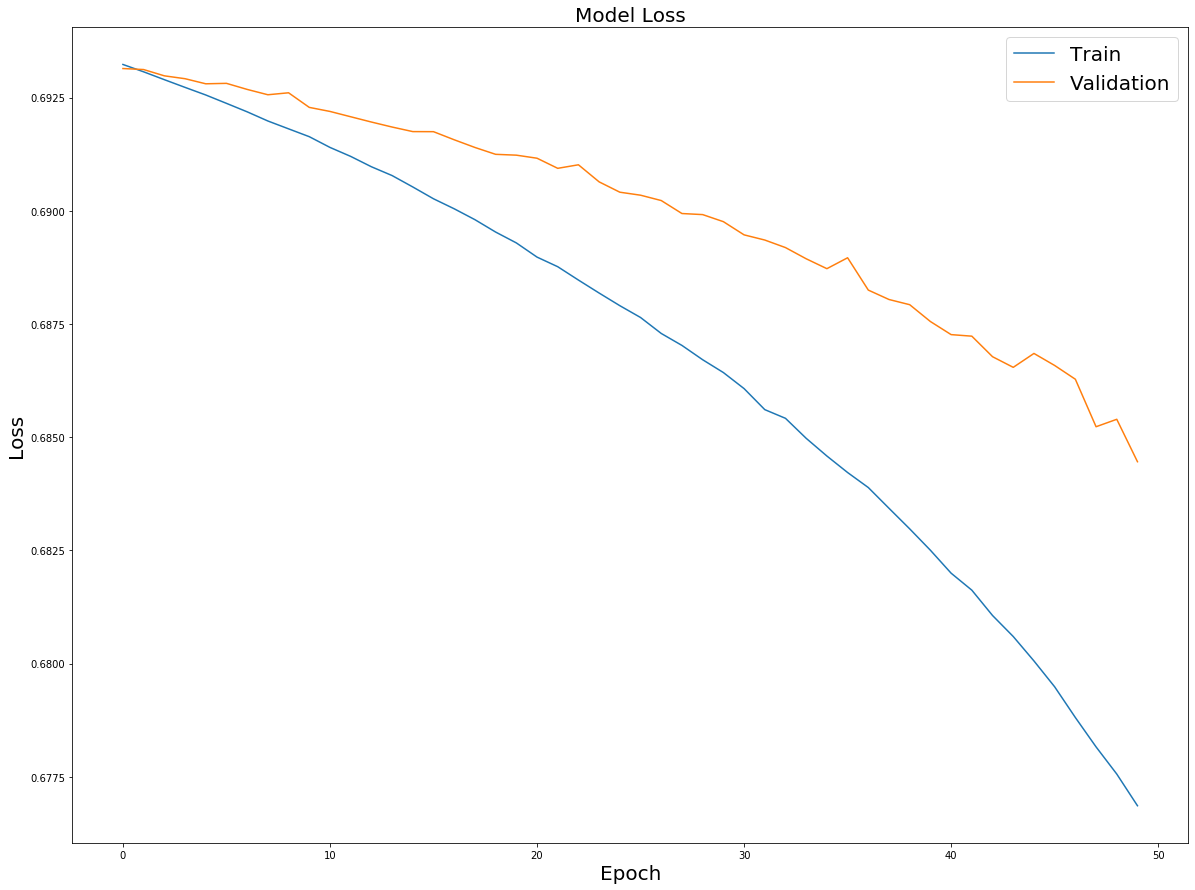

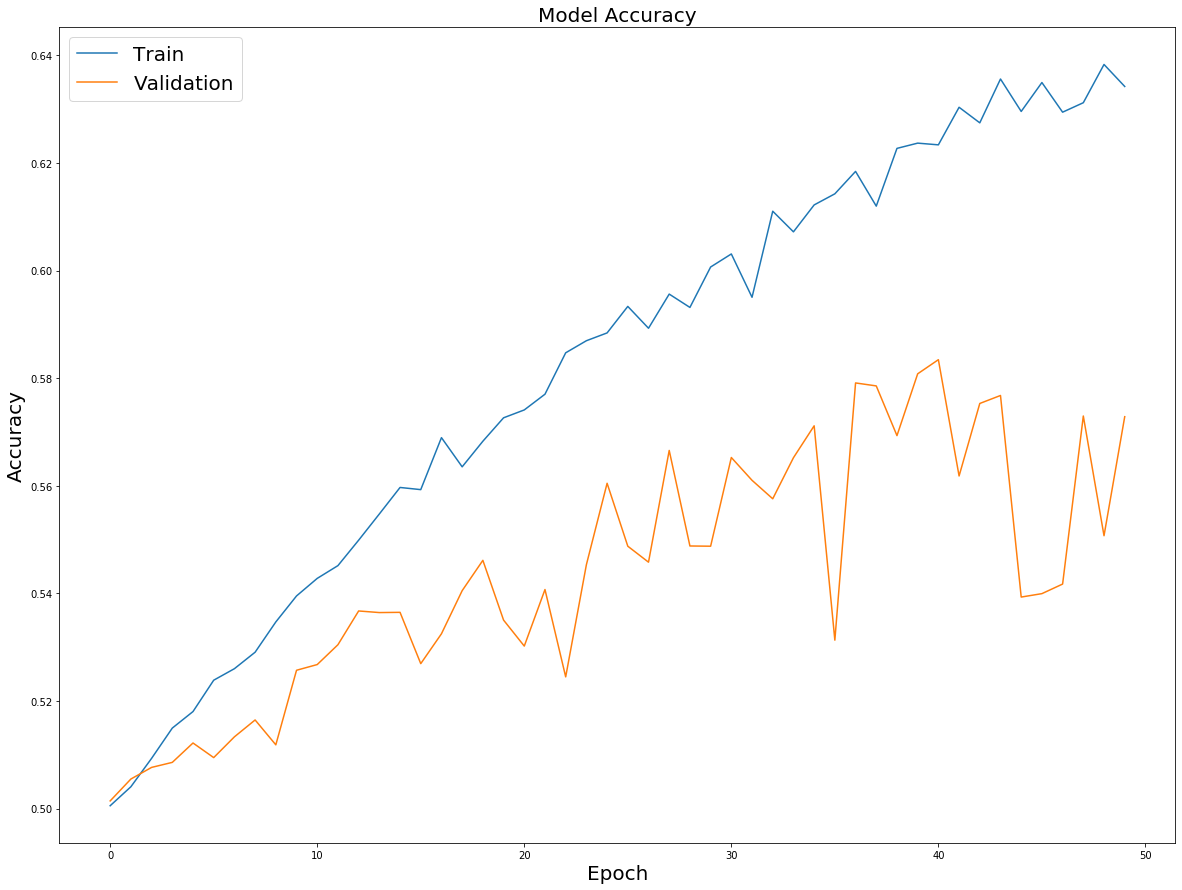

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Confusion matrix:
 [[ 6318  8595]
 [ 3905 10676]]


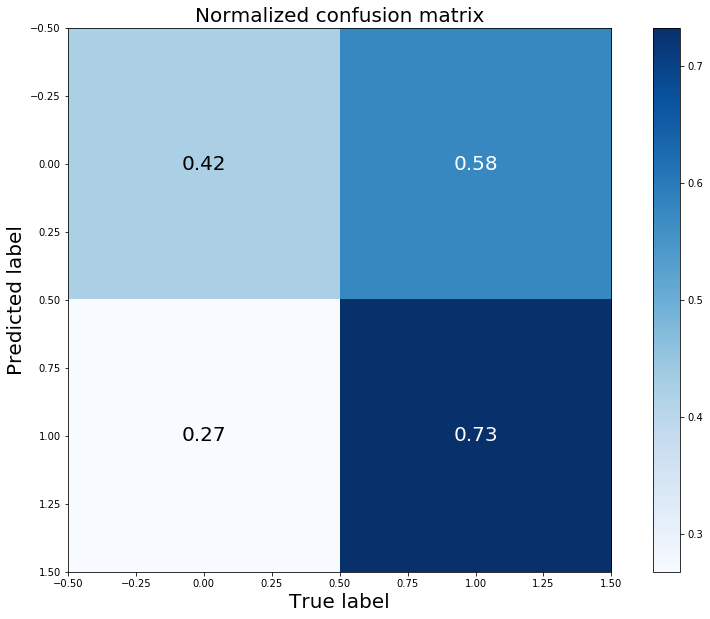

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [30]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 57.62%


### LSTM + Embedding Layer for Neanderthal Introgressed vs. Depleted Sequence Classification  <a class="anchor" id="LSTM-+-Embedding-Layer-for-Neanderthal-Introgressed-vs.-Depleted-Sequence-Classification"></a>

Bag of Words is a good model that compares K-mer frequencies between Neanderthal introgressed vs. depleted regions, it achieves quite a high accuracy of sequence classification. However, it does not take connections between the words / K-mers into account. We can do a more advanced classification using LSTM with special Embedding Layer in order to incorporate more **memory** into our model, so that the words / K-mers remember their order in the sentence / sequence. The Embedding layer provides a way to learn word embeddings / numeric representations while performing the classification task. We again start with reading the sequences from the two fasta-files (introgressed and depleted regions), split them into words / K-mers and build sentences out of them.

In [1]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 3000
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    depl_seqs.append(my_depl_seq)
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 10
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [2]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

147468

In [3]:
import numpy as np
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

147468


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

#cv = CountVectorizer()
#X = cv.fit_transform(merge_texts)

#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)
#X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

print(X)
print('\n')
print(X.shape)

Using TensorFlow backend.


[[ 69143 302251 282466 ... 180188 414035 167300]
 [ 47515  53231  22181 ...  80457 104350  98074]
 [ 47515  53231  22181 ...  80457 104350  98074]
 ...
 [549687 454439 347292 ... 258484 561554 414582]
 [562330 677629 616718 ... 743665 809770 419906]
 [367865 327393 334816 ...  46210 119017 308738]]


(147468, 2991)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

In [6]:
print(X_train.shape)
print(X_test.shape)

(117974, 2991)
(29494, 2991)


In [7]:
max_length = max([len(s.split()) for s in merge_texts])
print(max_length)

2991


In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

1047282


In [14]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU

model = Sequential()
#model.add(Dense(3000, input_shape = (X.shape[1],), activation = 'sigmoid'))
model.add(Embedding(vocab_size, 32, input_length = max_length, dropout = 0.2))
#model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu'))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(LSTM(10)) #dropout = 0.2, recurrent_dropout = 0.2
#model.add(GRU(10))
model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))
#model.add(Flatten())
#model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.0001), metrics = ['accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2991, 32)          33513024  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                430       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 33,513,465
Trainable params: 33,513,465
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 94379 samples, validate on 23595 samples
Epoch 1/5
94379/94379 [==============================] - 2374s 25ms/step - loss: 0.6895 - acc: 0.5375 - val_loss: 0.6628 - val_acc: 0.6132

Epoch 00001: val_acc improved from -inf to 0.61322, saving model to weights.best.hdf5
Epoch 2/5
94379/94379 [==============================] - 2351s 25ms/step - loss: 0.5714 - acc: 0.7069 - val_loss: 0.6236 - val_acc: 0.6465

Epoch 00002: val_acc improved from 0.61322 to 0.64654, saving model to weights.best.hdf5
Epoch 3/5
94379/94379 [==============================] - 2456s 26ms/step - loss: 0.4049 - acc: 0.8189 - val_loss: 0.6428 - val_acc: 0.6628

Epoch 00003: val_acc improved from 0.64654 to 0.66281, saving model to weights.best.hdf5
Epoch 4/5
94379/94379 [==============================] - 2473s 26ms/step - loss: 0.2831 - acc: 0.8868 - val_loss: 0.6725 - val_acc: 0.6704

Epoch 00004: val_acc improved from 0.66281 to 0.67044, saving model to weights.best.hdf5
Epoch 5/5
94379/94379 [==============

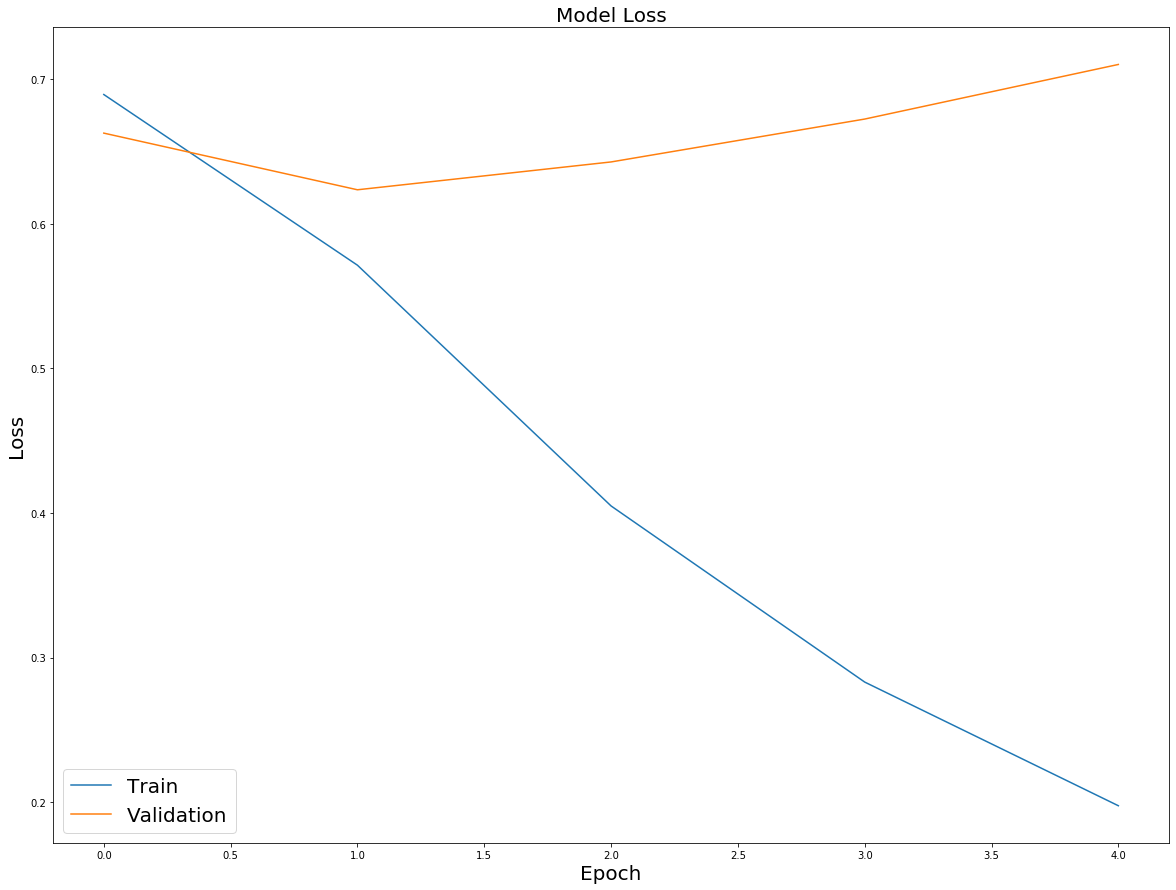

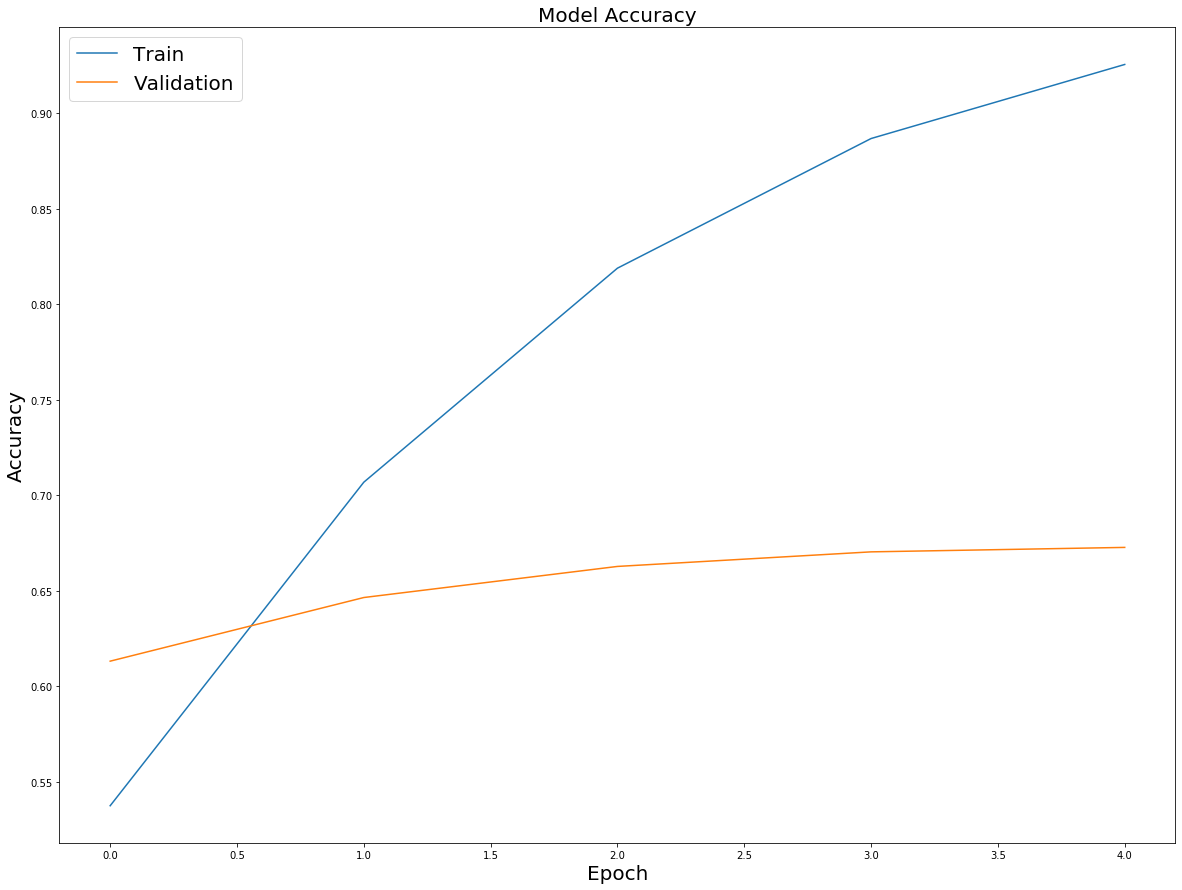

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

In [21]:
model.load_weights("weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

Confusion matrix:
 [[ 9672  5241]
 [ 4264 10317]]


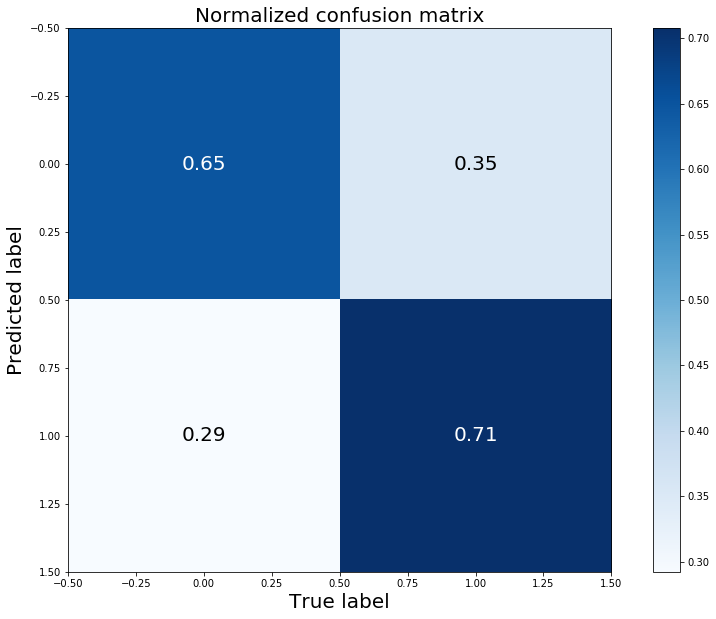

In [22]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize = (15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [23]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 67.77%


### Visualization of K-mer Word2Vec Embeddings  <a class="anchor" id="Visualization-of-K-mer-Word2Vec-Embeddings"></a>

Here we will try to use the pre-trained Google's Word2Vec word embeddings algorithm to visualize the dictionary of the Neanderthal introgressed and depleted texts. We will again start with reading the two fasta-files and concerting the sequences to sentences for later usage with Gensim Python library for Word2Vec:

In [1]:
import os
from Bio import SeqIO
from Bio.Seq import Seq

os.chdir('/home/nikolay/Documents/Medium/DeepLearningNeanderthalIntrogression/NeandIntr/')

intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 500
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)    
    depl_seqs.append(my_depl_seq)

    e = e + 1
    if e%10000 == 0:
        print('Finished ' + str(e) + ' entries')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries
Finished 40000 entries
Finished 50000 entries
Finished 60000 entries
Finished 70000 entries


In [2]:
sequences = intr_seqs + depl_seqs
len(sequences)

147468

In [3]:
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

In [4]:
print('Building Neanderthal introgressed sequences')
intr_sentences = []
for i in range(len(intr_seqs)):
    intr_sentences.append(getKmers(intr_seqs[i], 5))

print('Building Neanderthal depleted sequences')
depl_sentences = []
for i in range(len(depl_seqs)):
    depl_sentences.append(getKmers(depl_seqs[i], 5))

print('Building merged Neanderthal introgressed and depleted sequences')
sentences = []
for i in range(len(sequences)):
    sentences.append(getKmers(sequences[i], 5))

Building Neanderthal introgressed sequences
Building Neanderthal depleted sequences
Building merged Neanderthal introgressed and depleted sequences


In [13]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
model = Word2Vec(sentences, min_count = 2, workers = 4)
print(model)

Word2Vec(vocab=1024, size=100, alpha=0.025)


In [14]:
X = model[model.wv.vocab]
X.shape

(1024, 100)

Now each word is one observation, this observation has 100 coordinates, i.e. the default number of latent variables for word2vec. Next we can try to use the constructed word vectors and visualize the k-mers space using PCA, tSNE and UMAP. We will highlight most predictive k-mers from the Random Forest classification by green color.

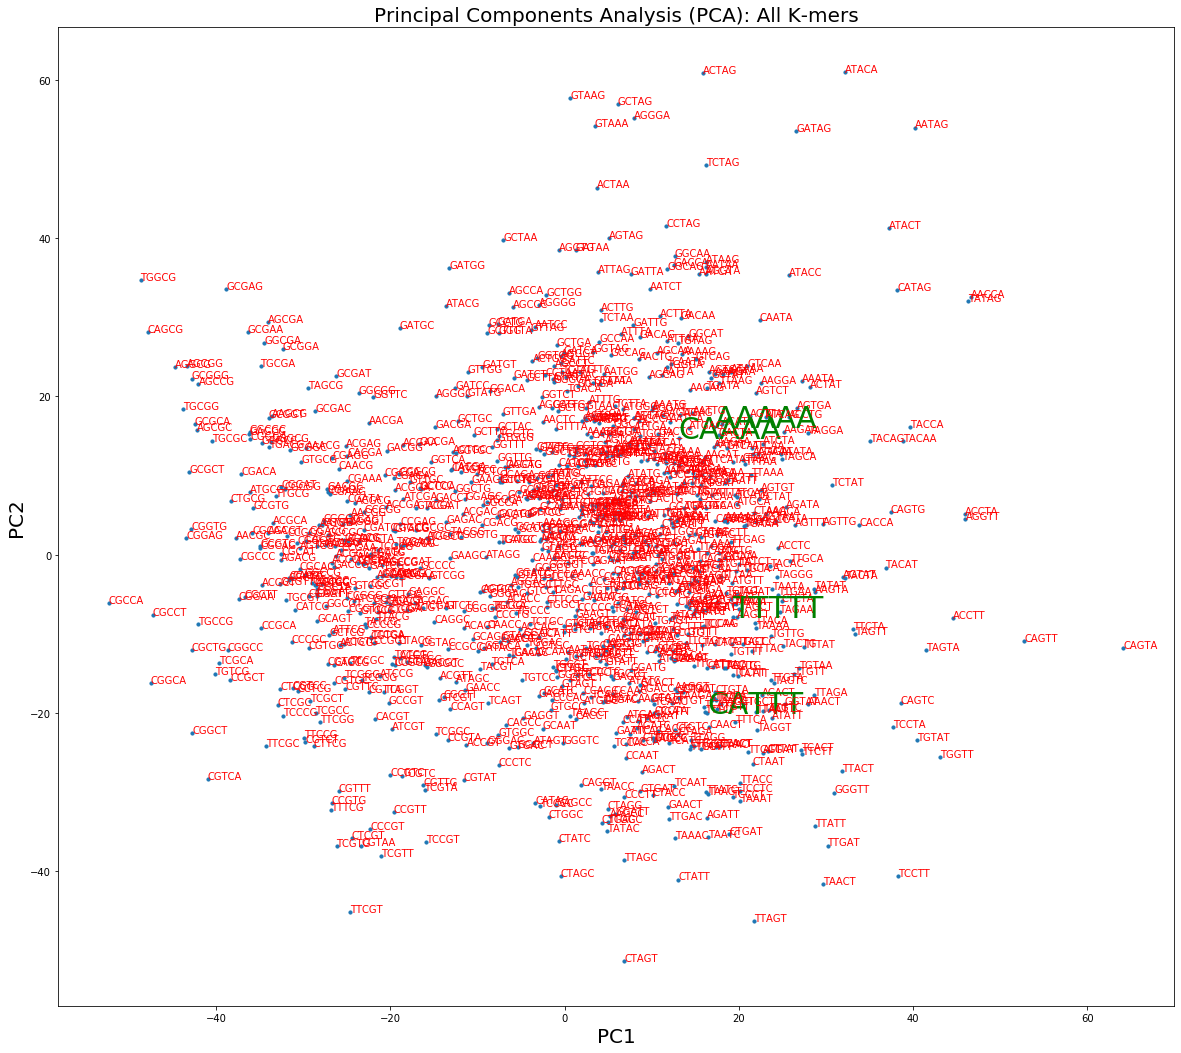

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X = model[model.wv.vocab]
pca = PCA(n_components = 2)
result = pca.fit_transform(X)

plt.figure(figsize = (20,18))
plt.scatter(result[:, 0], result[:, 1], s = 10, cmap = 'tab10')
plt.title('Principal Components Analysis (PCA): All K-mers', fontsize = 20)
plt.xlabel("PC1", fontsize = 20)
plt.ylabel("PC2", fontsize = 20)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(result[i, 0], result[i, 1], word, fontsize = 10, c = 'red')
plt.show()

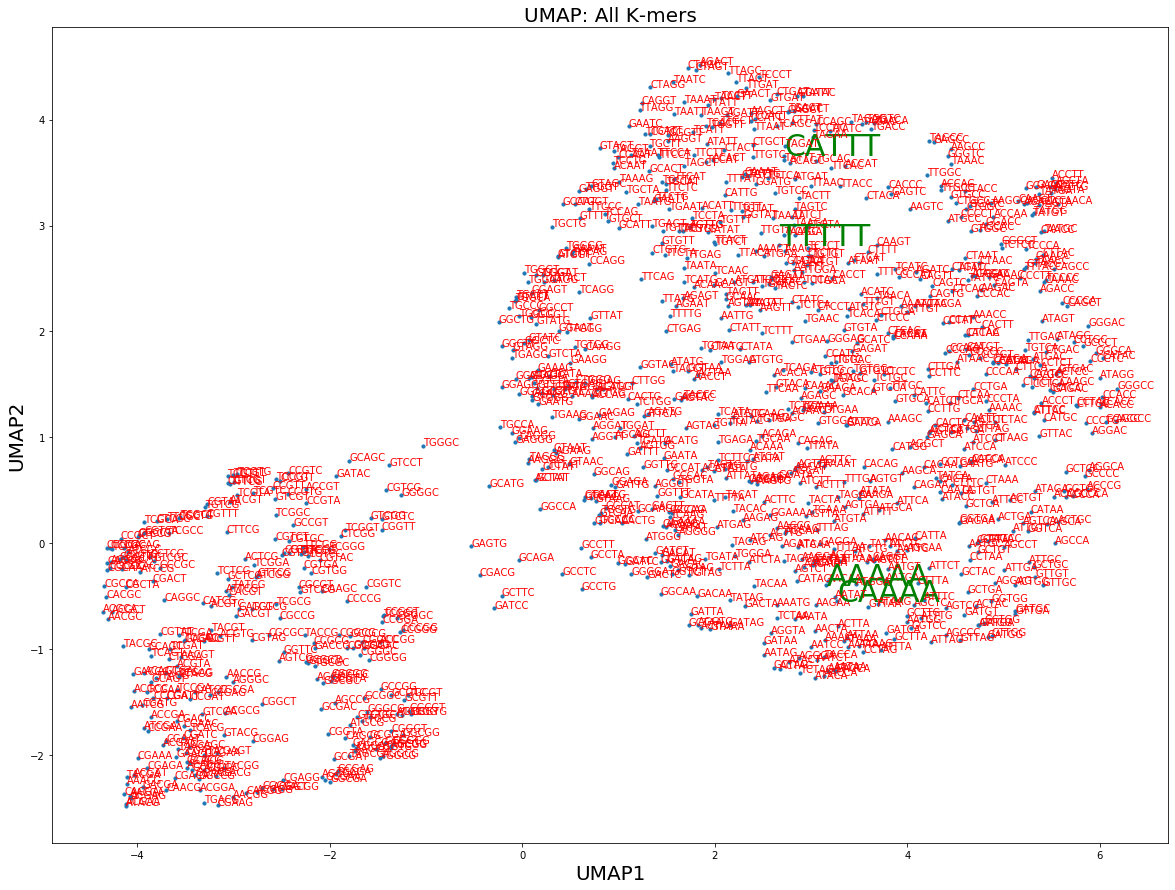

In [49]:
from umap import UMAP
import matplotlib.pyplot as plt
X = model[model.wv.vocab]
X_reduced = PCA(n_components = 5).fit_transform(X)
umap_model = UMAP(n_neighbors = 30, min_dist = 0.2, n_components = 2)
umap = umap_model.fit_transform(X_reduced)
plt.figure(figsize=(20,15))
plt.scatter(umap[:, 0], umap[:, 1], s = 10, cmap = 'tab10')
plt.title('UMAP: All K-mers', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 10, c = 'red')
plt.show()

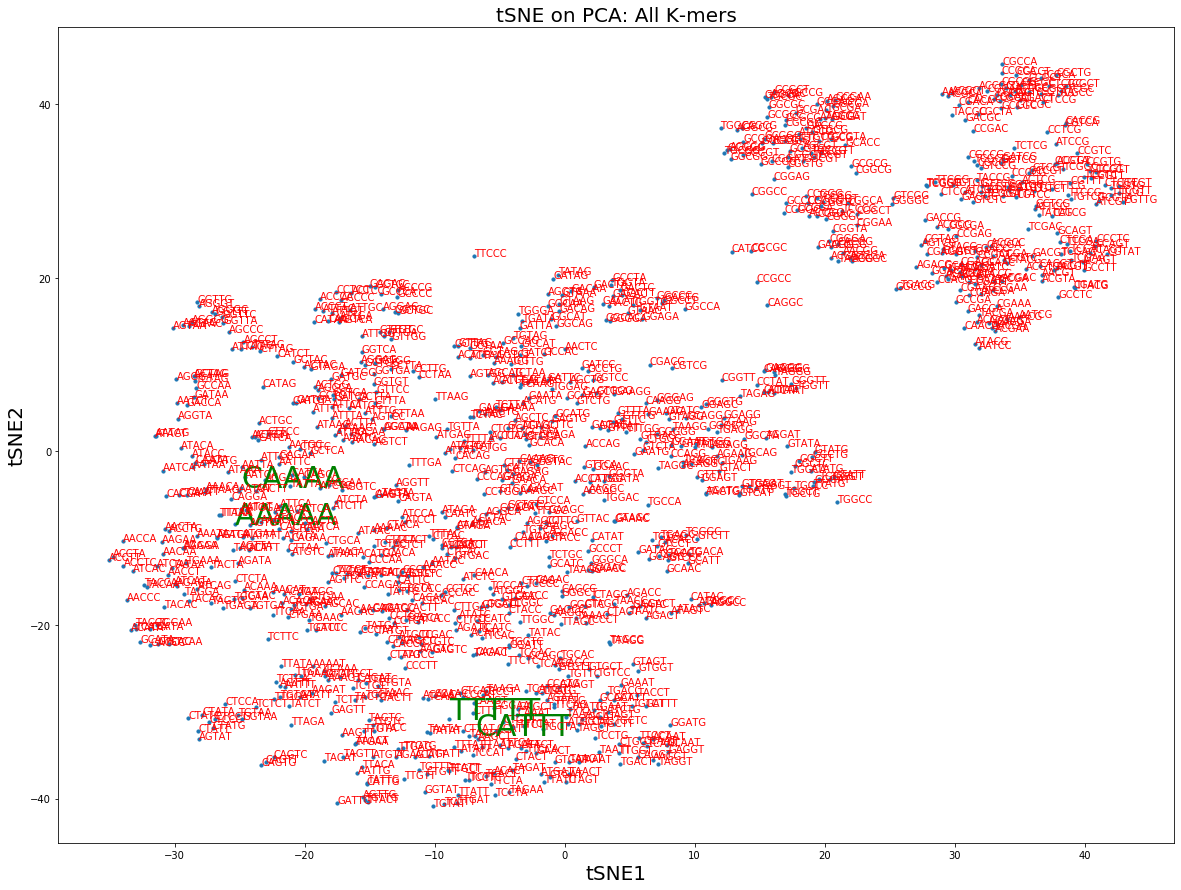

In [53]:
from sklearn.manifold import TSNE

plt.figure(figsize=(20, 15))
X_reduced = PCA(n_components = 5).fit_transform(X)
tsne_model = TSNE(learning_rate = 500, n_components = 2, random_state = 123, perplexity = 30)
tsne = tsne_model.fit_transform(X_reduced)
plt.scatter(tsne[:, 0], tsne[:, 1], cmap = 'tab10', s = 10)
plt.title('tSNE on PCA: All K-mers', fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20)
plt.ylabel("tSNE2", fontsize = 20)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 10, c = 'red')
plt.show()

Now let us compare the Word2Vec K-mer embeddings for Neanderthal introgressed vs. depleted texts. We start with the introgressed regions:

In [20]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
model_intr = Word2Vec(intr_sentences, min_count = 2, workers = 4)
print(model_intr)

Word2Vec(vocab=1024, size=100, alpha=0.025)


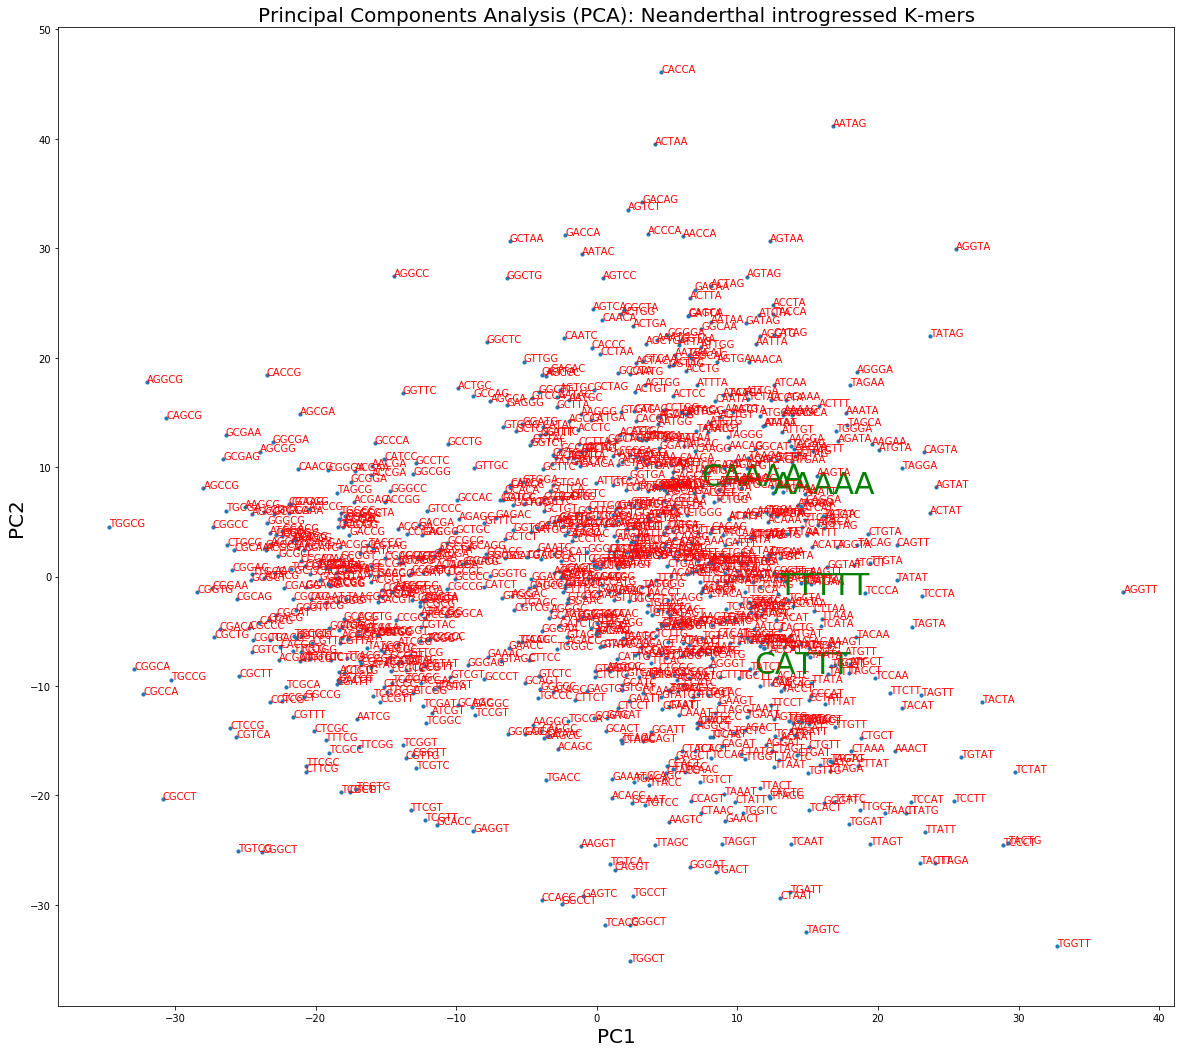

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X_intr = model_intr[model_intr.wv.vocab]
pca = PCA(n_components = 2)
result = pca.fit_transform(X_intr)

plt.figure(figsize = (20,18))
plt.scatter(result[:, 0], result[:, 1], s = 10, cmap = 'tab10')
plt.title('Principal Components Analysis (PCA): Neanderthal introgressed K-mers', fontsize = 20)
plt.xlabel("PC1", fontsize = 20)
plt.ylabel("PC2", fontsize = 20)
words = list(model_intr.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(result[i, 0], result[i, 1], word, fontsize = 10, c = 'red')
plt.show()

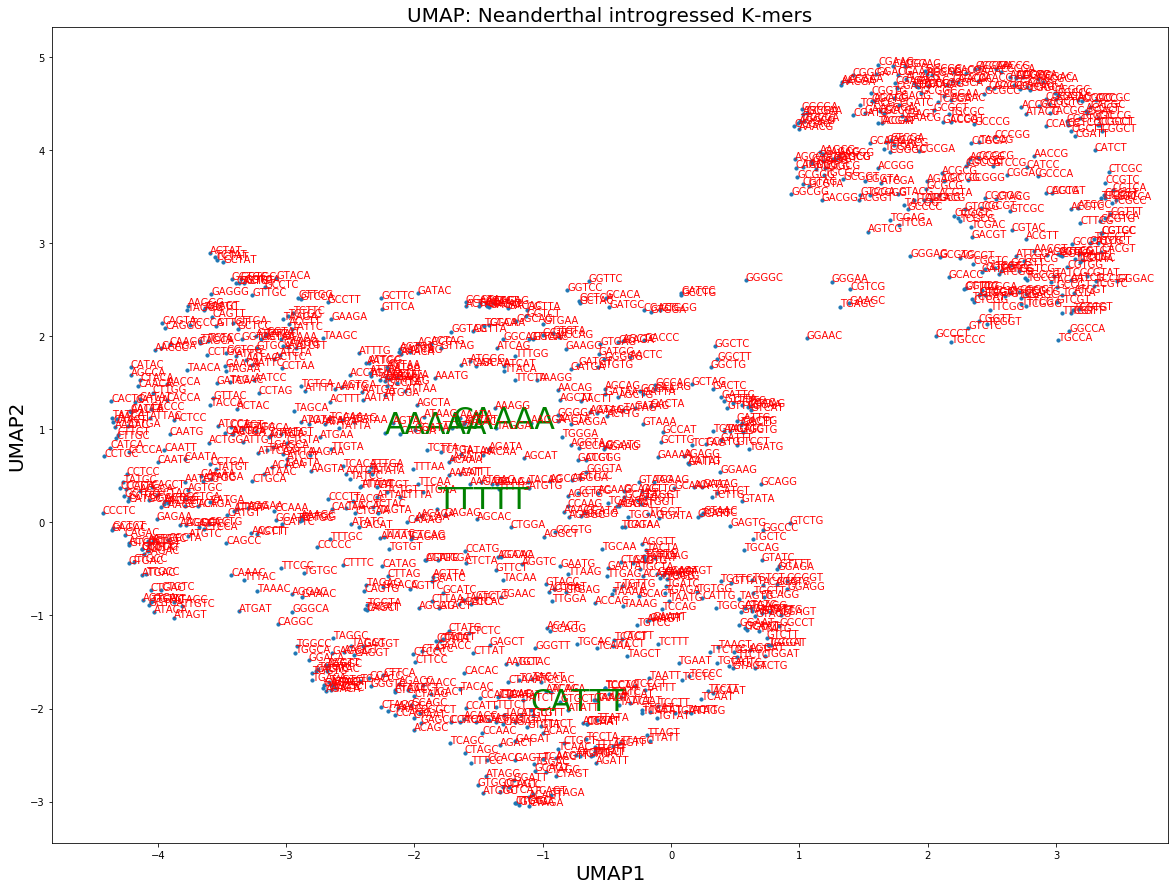

In [30]:
from umap import UMAP
import matplotlib.pyplot as plt
X_intr = model_intr[model_intr.wv.vocab]
X_reduced = PCA(n_components = 5).fit_transform(X_intr)
umap_model = UMAP(n_neighbors = 30, min_dist = 0.1, n_components = 2)
umap = umap_model.fit_transform(X_reduced)
plt.figure(figsize=(20,15))
plt.scatter(umap[:, 0], umap[:, 1], s = 10, cmap = 'tab10')
plt.title('UMAP: Neanderthal introgressed K-mers', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
words = list(model_intr.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 10, c = 'red')
plt.show()

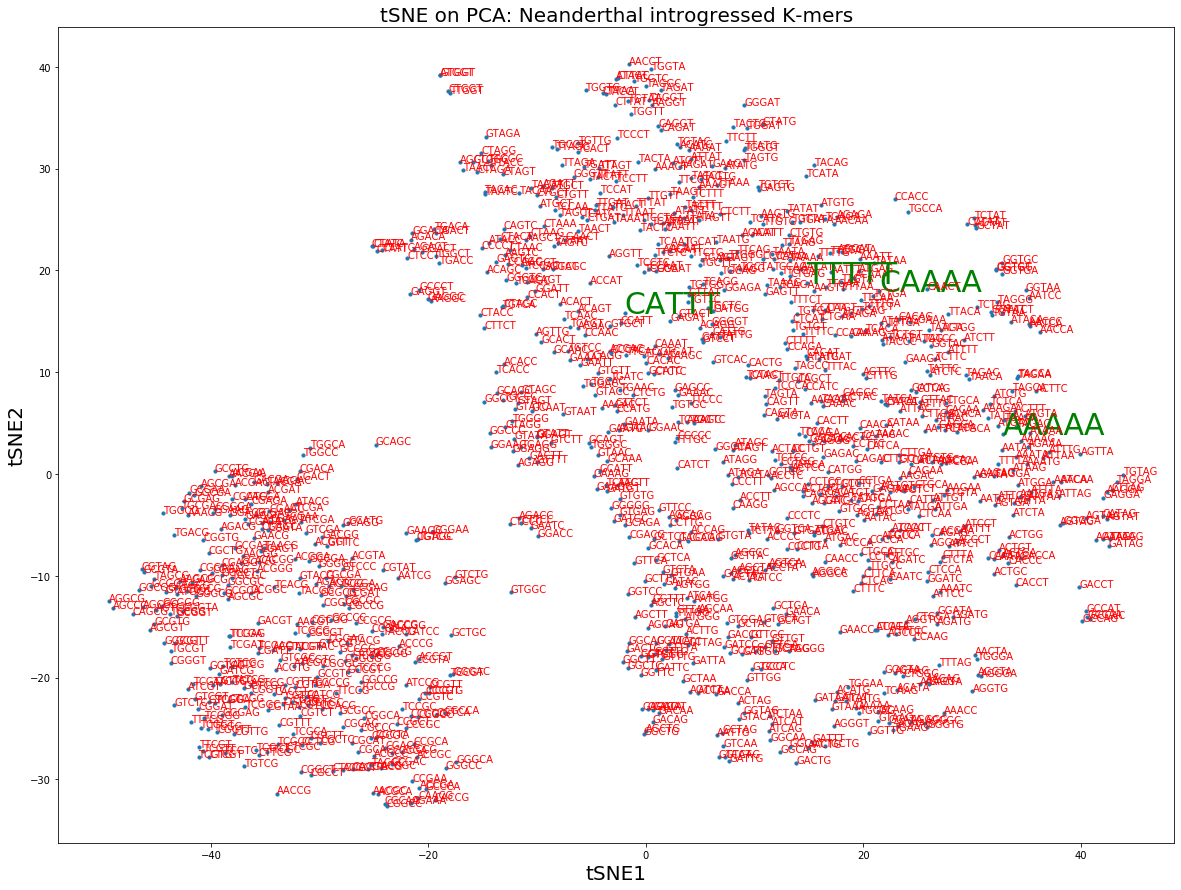

In [31]:
from sklearn.manifold import TSNE

plt.figure(figsize=(20, 15))
X_reduced = PCA(n_components = 5).fit_transform(X_intr)
tsne_model = TSNE(learning_rate = 500, n_components = 2, random_state = 123, perplexity = 30)
tsne = tsne_model.fit_transform(X_reduced)
plt.scatter(tsne[:, 0], tsne[:, 1], cmap = 'tab10', s = 10)
plt.title('tSNE on PCA: Neanderthal introgressed K-mers', fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20)
plt.ylabel("tSNE2", fontsize = 20)
words = list(model_intr.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 10, c = 'red')
plt.show()

And now we will visualize the word embeddings vocabulary for the depleted Neanderthal regions:

In [25]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
model_depl = Word2Vec(depl_sentences, min_count = 2, workers = 4)
print(model_depl)

Word2Vec(vocab=1024, size=100, alpha=0.025)


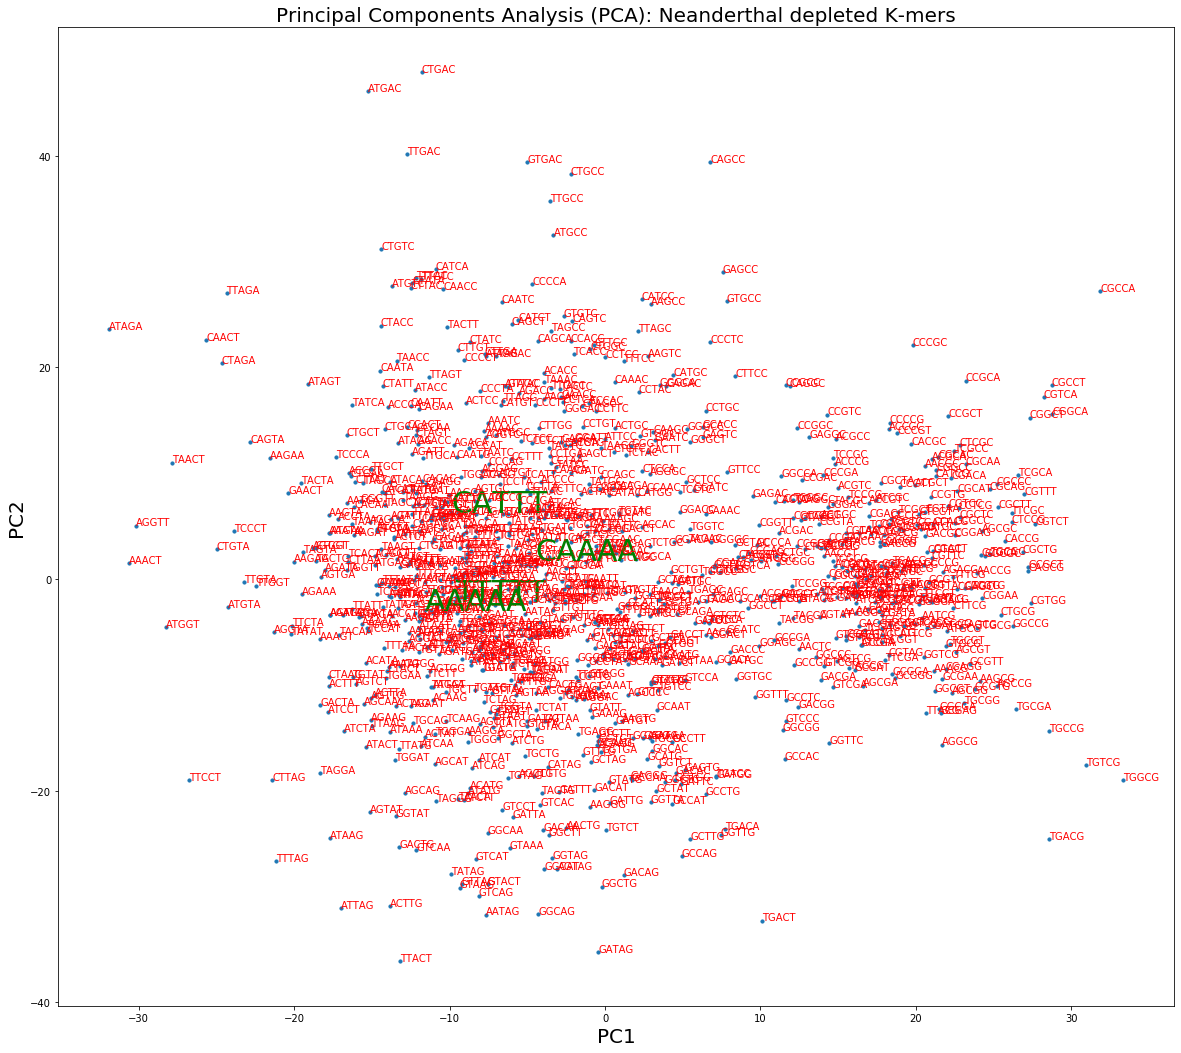

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X_depl = model_depl[model_depl.wv.vocab]
pca = PCA(n_components = 2)
result = pca.fit_transform(X_depl)

plt.figure(figsize = (20,18))
plt.scatter(result[:, 0], result[:, 1], s = 10, cmap = 'tab10')
plt.title('Principal Components Analysis (PCA): Neanderthal depleted K-mers', fontsize = 20)
plt.xlabel("PC1", fontsize = 20)
plt.ylabel("PC2", fontsize = 20)
words = list(model_depl.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(result[i, 0], result[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(result[i, 0], result[i, 1], word, fontsize = 10, c = 'red')
plt.show()

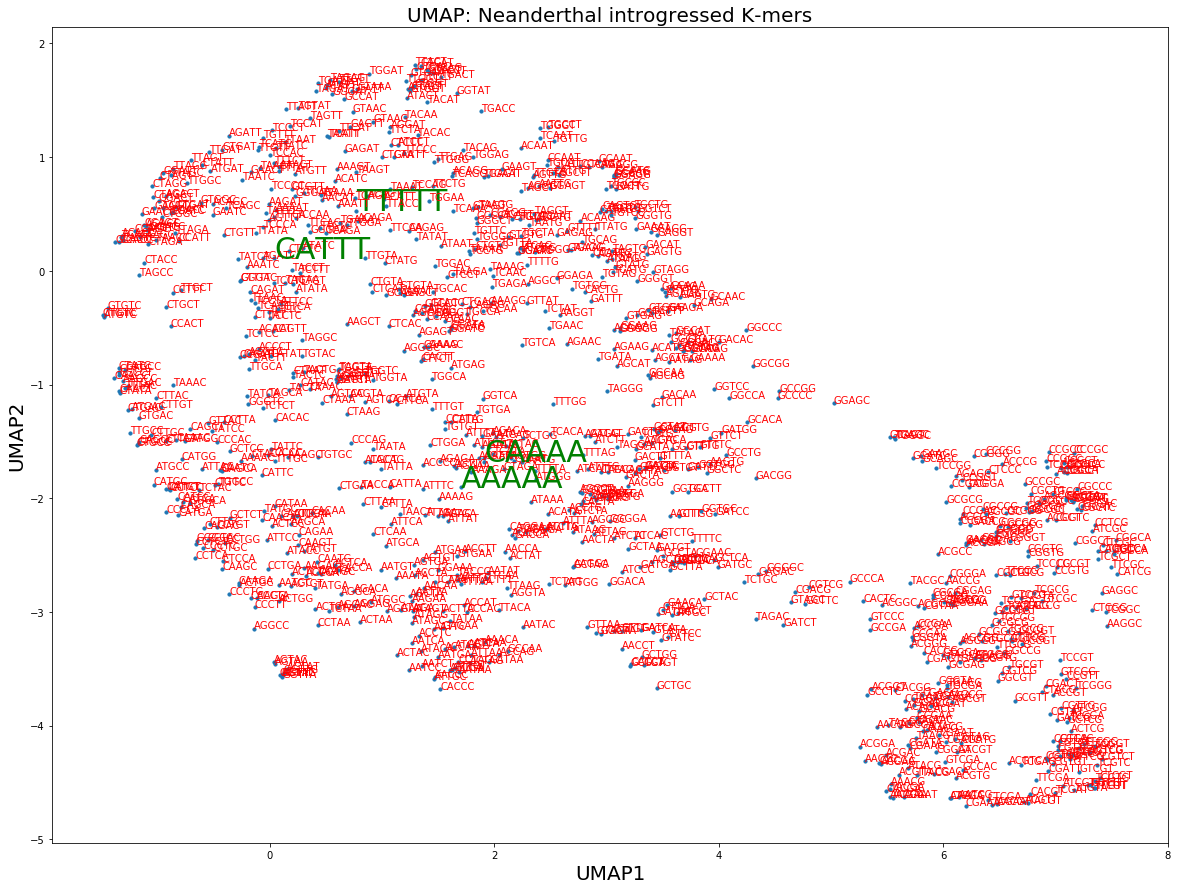

In [33]:
from umap import UMAP
import matplotlib.pyplot as plt
X_depl = model_depl[model_depl.wv.vocab]
X_reduced = PCA(n_components = 5).fit_transform(X_depl)
umap_model = UMAP(n_neighbors = 30, min_dist = 0.1, n_components = 2)
umap = umap_model.fit_transform(X_reduced)
plt.figure(figsize=(20,15))
plt.scatter(umap[:, 0], umap[:, 1], s = 10, cmap = 'tab10')
plt.title('UMAP: Neanderthal introgressed K-mers', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
words = list(model_depl.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(umap[i, 0], umap[i, 1], word, fontsize = 10, c = 'red')
plt.show()

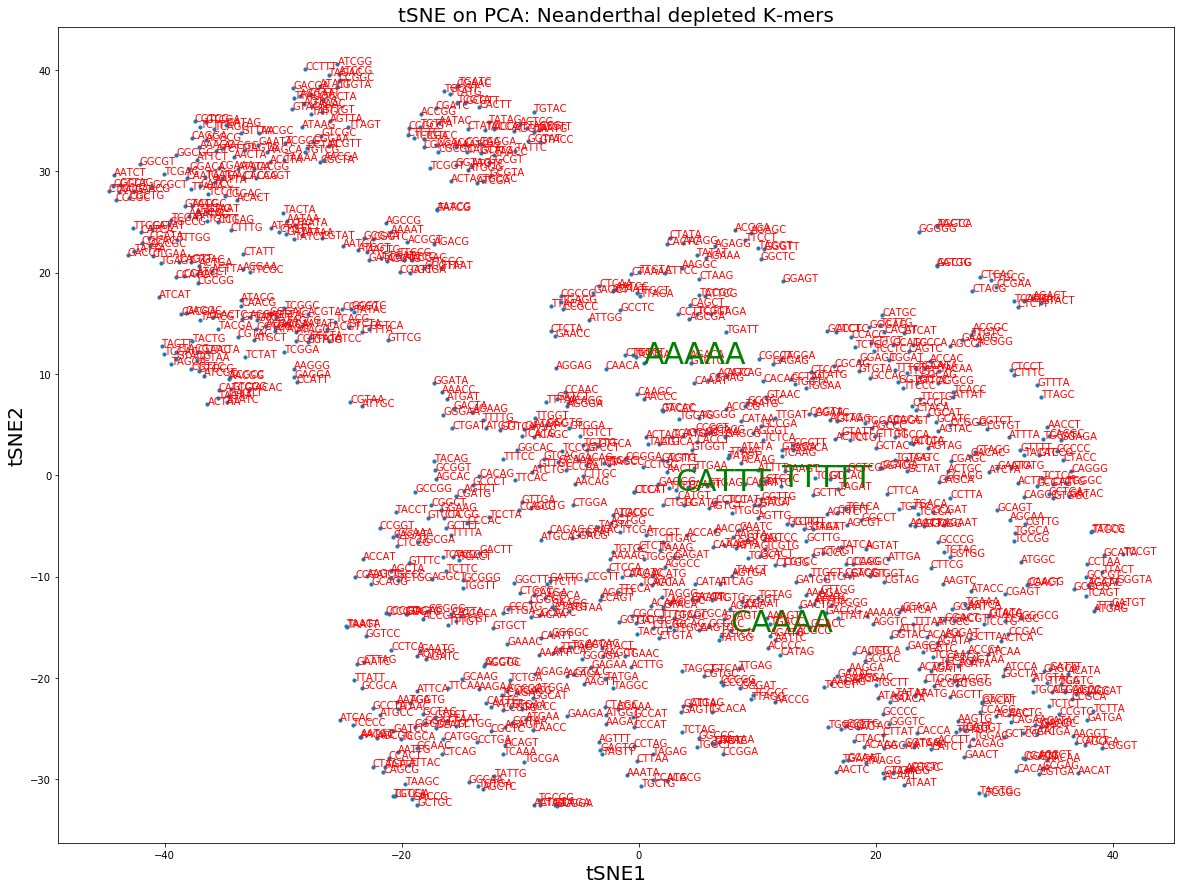

In [28]:
from sklearn.manifold import TSNE

plt.figure(figsize=(20, 15))
X_reduced = PCA(n_components = 5).fit_transform(X_depl)
tsne_model = TSNE(learning_rate = 500, n_components = 2, random_state = 123, perplexity = 30)
tsne = tsne_model.fit_transform(X_reduced)
plt.scatter(tsne[:, 0], tsne[:, 1], cmap = 'tab10', s = 10)
plt.title('tSNE on PCA: Neanderthal depleted K-mers', fontsize = 20)
plt.xlabel("tSNE1", fontsize = 20)
plt.ylabel("tSNE2", fontsize = 20)
words = list(model_depl.wv.vocab)
for i, word in enumerate(words):
    if word == 'AAAAA':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CAAAA':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'CATTT':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    elif word == 'TTTTT':
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 30, c = 'green')
    else:
        plt.text(tsne[i, 0], tsne[i, 1], word, fontsize = 10, c = 'red')
plt.show()

And now for comparison let us put Neanderthal introgressed and depleted k-mers on the same PCA plot coloring introgressed k-mers by red and depleted k-mers by blue:

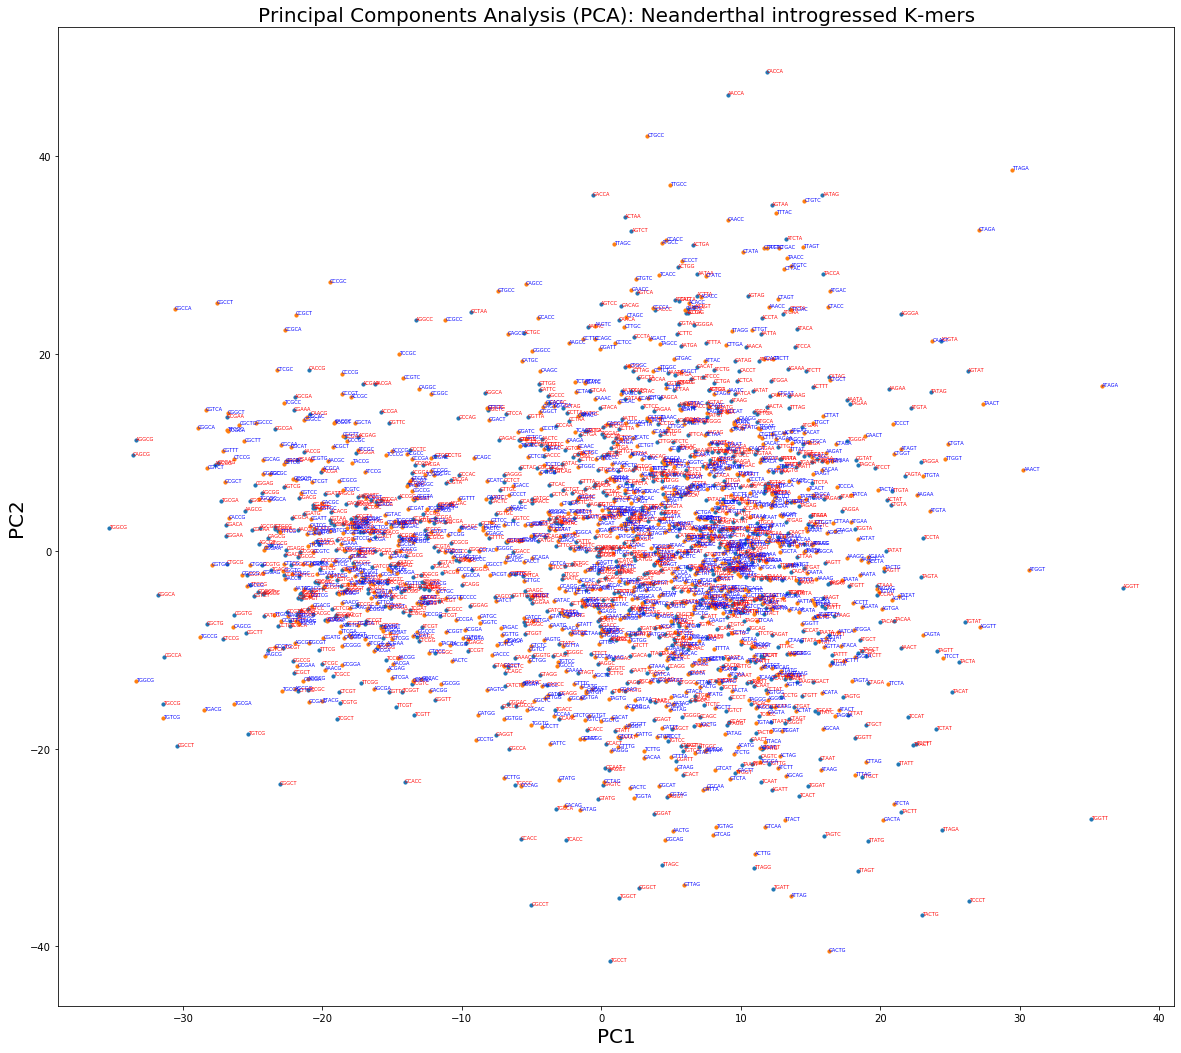

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_intr = model_intr[model_intr.wv.vocab]
pca_intr = PCA(n_components = 2)
result_intr = pca_intr.fit_transform(X_intr)

X_depl = model_depl[model_depl.wv.vocab]
pca_depl = PCA(n_components = 2)
result_depl = pca_depl.fit_transform(X_depl)

plt.figure(figsize = (20,18))
plt.scatter(result_intr[:, 0], result_intr[:, 1], s = 10, cmap = 'tab10')
plt.scatter(result_depl[:, 0], result_depl[:, 1], s = 10, cmap = 'tab10')
plt.title('Principal Components Analysis (PCA): Neanderthal introgressed K-mers', fontsize = 20)
plt.xlabel("PC1", fontsize = 20)
plt.ylabel("PC2", fontsize = 20)
words_intr = list(model_intr.wv.vocab)
words_depl = list(model_depl.wv.vocab)
for i_intr, word_intr in enumerate(words_intr):
    plt.text(result_intr[i_intr, 0], result_intr[i_intr, 1], word_intr, fontsize = 5, c = 'red')
for i_depl, word_depl in enumerate(words_depl):
    plt.text(result_depl[i_depl, 0], result_depl[i_depl, 1], word_depl, fontsize = 5, c = 'blue')
plt.show()

The introgressed and depleted k-mers seem to be overlapping although it is probably a good idea to merge the X_intr and X_depl and perform PCA on the merged data set.